# ===========================================================
# Full pipeline for the influence matrix estimation problem on the supervised dataset from the Jeopardy-like logs for comparison on different models
# ===========================================================

Goals:
1. Split the data into test and train, and validation for multiple runs
2. Formulate all different models of convex optimization, neural networks, and tower models.
3. Give the same splits to all models, tune the hyperparameters with validation set, and report train and test erros as a pickle, a table, and a figure

#### Started on: 30 Dec 2019
#### Last update: 07 Jan 2020

# Imports

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals

import imp
import sys
import scipy as sp
import cvxpy as cp
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Concatenate, Reshape, Embedding, Dot
from tensorflow.keras.models import Model
sys.path.insert(0, '../src/')
%matplotlib inline

import utils
import mytools
from mytools import Timer
from mytools import Tee

/home/omid/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/omid/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Parameters

In [2]:
DATA_FILE_PATH = '/home/omid/Datasets/Jeopardy/supervised_data.pk'
# DATA_FILE_PATH = '/home/omid/Datasets/Jeopardy/supervised_data_roberta.pk'
TEST_FRACTION = 0.2
RUNS = 6

# Helper functions

## General functions 

In [3]:
def reload():
    imp.reload(utils)
    imp.reload(mytools)

In [4]:
# def get_eigvec_of_laplacian(A: np.matrix) -> np.matrix:
# #     D = np.diag(np.array(np.sum(A, axis=0))[0])
# #     L = D - A
# #     return np.matrix(np.linalg.eig(L)[1])
#     n, m = A.shape
#     diags = A.sum(axis=1).flatten()
#     D = sp.sparse.spdiags(diags, [0], m, n, format='csr')
#     L = D - A
#     with sp.errstate(divide='ignore'):
#         diags_sqrt = 1.0/sp.sqrt(diags)
#     diags_sqrt[sp.isinf(diags_sqrt)] = 0
#     DH = sp.sparse.spdiags(diags_sqrt, [0], m, n, format='csr')
#     DH = DH.todense()
#     normalized_L = DH.dot(L.dot(DH))
#     return normalized_L

## Models

### Boilerplate model functions

In [5]:
def comput_error(y_train_or_validation_or_test_true, y_train_or_validation_or_test_predicted, estimation_name, error_type_str):
    """Computes the error."""
    err = 0
    for index in range(len(y_train_or_validation_or_test_true)):
        groundtruth = y_train_or_validation_or_test_true[index][estimation_name]
        predicted = y_train_or_validation_or_test_predicted[index]
        # TODO(@Omid): CHECK WHETHER THIS IS JUST AN INT THEN FIND THE MOST INFLUENTIAL PERSON FROM THE ESTIAMTED MATRIX.
        err += utils.matrix_estimation_error(
            true_matrix=groundtruth, pred_matrix=predicted, type_str=error_type_str)
    err /= len(y_train_or_validation_or_test_true)
    return err


def model_builder(
        X_train,
        y_train,
        X_test,
        y_test,
        feature_names,
        estimation_name='influence_matrix',
        error_type_str='normalized_frob_norm',
        tune_hyperparameters_by_validation=True,
        with_replication=True,
        lambdas = [0, 0.1, 1, 10, 100, 1000],
        model_func='average',
        params={'with_constraints': True, 'n_splits': 3}):
    
    # For the baseline models.
    if model_func == 'average':
        mats = []
        for i in range(len(y_train)):
            mats.append(y_train[i][estimation_name])
        y_baseline_predicted = [np.matrix(np.mean(mats, axis=0)) for _ in range(len(y_train))]
    elif model_func == 'uniform':
        y_baseline_predicted = [np.matrix(np.ones((4, 4)) * 0.25) for _ in range(len(y_train))]
    elif model_func == 'random':
        y_baseline_predicted = [np.matrix(
            utils.make_matrix_row_stochastic(
                np.random.rand(4, 4))) for _ in range(len(y_train))]
    if model_func in ['average', 'uniform', 'random']:
        y_train_average = []
        train_error = comput_error(
            y_train, y_baseline_predicted, estimation_name=estimation_name, error_type_str=error_type_str)
        test_error = comput_error(
            y_test, y_baseline_predicted, estimation_name=estimation_name, error_type_str=error_type_str)
        return train_error, test_error, _
    
    # For the proposed models.
    validation_errors = defaultdict(lambda: 0)
    if tune_hyperparameters_by_validation:
        print('{}-fold validation ...'.format(params['n_splits']))
        kf = KFold(n_splits=params['n_splits'])
        for train_index, validation_index in kf.split(X_train):
            X_train_subset, X_validation = X_train[train_index], X_train[validation_index]
            y_train_subset, y_validation = y_train[train_index], y_train[validation_index]
            if with_replication:
                X_train_subset, y_train_subset = utils.replicate_matrices_in_train_dataset_with_reordering(
                    X_train_subset, y_train_subset)
                X_train_subset = np.array(X_train_subset)
                y_train_subset = np.array(y_train_subset)
            print('Shapes of train: {}, validation: {}, test: {}.'.format(
                X_train_subset.shape, X_validation.shape, X_test.shape))
            for lambdaa in lambdas:
                validation_errors[lambdaa] += model_func(
                    X_train=X_train_subset,
                    y_train=y_train_subset,
                    X_validation_or_test=X_validation,
                    y_validation_or_test=y_validation,
                    feature_names=feature_names,
                    estimation_name=estimation_name,
                    lambdaa=lambdaa,
                    error_type_str=error_type_str,
                    params=params)[1]
        best_lambda = min(validation_errors, key=validation_errors.get)
    else:
        best_lambda = 0.1
    print('Training with the best lambda: {} on entire training set...'.format(best_lambda))
    X_train, y_train = utils.replicate_matrices_in_train_dataset_with_reordering(
        X_train, y_train)
    train_error, test_error = model_func(
        X_train=X_train,
        y_train=y_train,
        X_validation_or_test=X_test,
        y_validation_or_test=y_test,
        feature_names=feature_names,
        estimation_name=estimation_name,
        lambdaa=best_lambda,
        error_type_str=error_type_str,
        params=params)
    return train_error, test_error, validation_errors

### Specific model functions

In [6]:
def convex_optimization_model_func(
        X_train,
        y_train,
        X_validation_or_test,
        y_validation_or_test,
        feature_names,
        estimation_name,
        lambdaa,
        error_type_str,
        params={'with_constraints': True}):
    
    def predict(data_element, feature_names, B, Ws, is_solved=False):
        """Defines the prediction function."""
        predicted = 0
        if is_solved:
            predicted += B.value
        else:
            predicted += B
        for feature_name in feature_names:
            if is_solved:
                W_for_this_feature = Ws[feature_name].value
            else:
                W_for_this_feature = Ws[feature_name]
            if len(data_element[feature_name].shape) == 1:
                # If it was a vector, it makes a matrix with it.
                p = data_element[feature_name]
                data_element_matrix = np.row_stack([p, p, p, p])
            else:
                # Unless it is already a matrix.
                data_element_matrix = data_element[feature_name]
            predicted += (data_element_matrix * W_for_this_feature)
        return predicted
    
    def predict_all_after_solving(X_train_or_validation_or_test, B, Ws, feature_names):
        """Predicts for all data points in the given set."""
        return [
            predict(
                data_element=data_element,
                feature_names=feature_names,
                B=B,
                Ws=Ws,
                is_solved=True) 
            for data_element in X_train_or_validation_or_test]

    # Creating variables.
    Ws = {}
    for feature_name in feature_names:
        if len(X_train[0][feature_name].shape) == 1:
            # If it was a vector, it makes a matrix with it.
            Ws[feature_name] = cp.Variable(
                len(X_train[0][feature_name]), len(X_train[0][feature_name]))
        else:
            # Unless it is already a matrix.
            Ws[feature_name] = cp.Variable(
                X_train[0][feature_name].shape[1], X_train[0][feature_name].shape[0])
    B = cp.Variable(4, 4)

    # Computing loss.
    constraints = []
    losses = 0
    for index in range(len(X_train)):
        element = X_train[index]
        estimation_groundtruth = y_train[index][estimation_name]

        # Defining the estimation function.
        estimation_predicted = predict(
            data_element=element, feature_names=feature_names, B=B, Ws=Ws, is_solved=False)

        # Defining the loss function.
        loss = cp.sum_squares(estimation_predicted - estimation_groundtruth)

        losses += loss
        if params['with_constraints']:
            constraints += [estimation_predicted >= 0]
            constraints += [cp.sum_entries(estimation_predicted, axis=1) == 1]

    # Computing regularization.
    regluarization = cp.norm1(B)
    for feature_name in feature_names:
        regluarization += cp.norm1(Ws[feature_name])

    # Solving the convex problem.
    objective = cp.Minimize(losses + lambdaa * regluarization)
    prob = cp.Problem(objective, constraints)
    try:
        result = prob.solve(solver=cp.MOSEK)
    except cp.SolverError as e:
        print('Problem was not solved for lambda: {}'.format(lambdaa))
        return sys.maxsize, sys.maxsize
    print('The status of solution was: {} and the result was: {}'.format(prob.status, result))

    # Predicting and computing trian error.
    y_train_predicted = predict_all_after_solving(
        X_train_or_validation_or_test=X_train, B=B, Ws=Ws, feature_names=feature_names)
    train_error = comput_error(
        y_train_or_validation_or_test_true=y_train,
        y_train_or_validation_or_test_predicted=y_train_predicted,
        estimation_name=estimation_name,
        error_type_str=error_type_str)
    
    # Predicting and computing validation or test error.
    y_validation_or_test_predicted = predict_all_after_solving(
        X_train_or_validation_or_test=X_validation_or_test, B=B, Ws=Ws, feature_names=feature_names)
    validation_or_test_error = comput_error(
        y_train_or_validation_or_test_true=y_validation_or_test,
        y_train_or_validation_or_test_predicted=y_validation_or_test_predicted,
        estimation_name=estimation_name,
        error_type_str=error_type_str)
    
    return train_error, validation_or_test_error

In [7]:
# def my_init(shape, dtype=None):
#     return np.ones(shape) * 0.25


def concatinated_deep_neural_network_model_func(
        X_train,
        y_train,
        X_validation_or_test,
        y_validation_or_test,
        feature_names,
        estimation_name,
        lambdaa,
        error_type_str,
        params={'n_epochs': 10, 'batch_size': 32}):

    flatten_X_train = []
    flatten_y_train = []
    for i in range(len(X_train)):
        features = X_train[i]
        label = y_train[i][estimation_name]            
        flatten_X_train.append(np.hstack(
            [np.array(features[feature_name].flatten())[0] for feature_name in feature_names]))
        flatten_y_train.append(np.array(label.flatten())[0])
    flatten_X_train = np.array(flatten_X_train)
    flatten_y_train = np.array(flatten_y_train)

    flatten_X_validation_or_test = []
    flatten_y_validation_or_test = []
    for i in range(len(X_validation_or_test)):
        features = X_validation_or_test[i]
        label = y_validation_or_test[i][estimation_name]
        flatten_X_validation_or_test.append(np.hstack(
            [np.array(features[feature_name].flatten())[0] for feature_name in feature_names]))
        flatten_y_validation_or_test.append(np.array(label.flatten())[0])
    flatten_X_validation_or_test = np.array(flatten_X_validation_or_test)
    flatten_y_validation_or_test = np.array(flatten_y_validation_or_test)
                              
    _, input_size = flatten_X_train.shape
    print('Input size for the neural network was: {}'.format(input_size))

    model = Sequential([
        Dense(
            units=32,
            kernel_initializer='he_normal',
            activation='elu',
            input_shape=(input_size,),
            kernel_regularizer=regularizers.l1(lambdaa),
            activity_regularizer=regularizers.l1(lambdaa)),
#         Dropout(0.5),
        Dense(
            units=64,
            kernel_initializer='he_normal',
            activation='elu',
            kernel_regularizer=regularizers.l1(lambdaa),
            activity_regularizer=regularizers.l1(lambdaa)),
#         Dropout(0.5),
        Dense(
            units=32,
            kernel_initializer='he_normal',
            activation='elu',
            kernel_regularizer=regularizers.l1(lambdaa),
            activity_regularizer=regularizers.l1(lambdaa)),
#         Dropout(0.5),
        Dense(16, kernel_initializer='glorot_uniform', activation='sigmoid')])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(flatten_X_train, flatten_y_train, epochs=params['n_epochs'], batch_size=params['batch_size'])

    # Predicting and computing trian error.
    y_train_predicted = [utils.make_matrix_row_stochastic(
        np.matrix(np.reshape(element, (4, 4)))) for element in model.predict(flatten_X_train)]
    train_error = comput_error(
        y_train_or_validation_or_test_true=y_train,
        y_train_or_validation_or_test_predicted=y_train_predicted,
        estimation_name=estimation_name,
        error_type_str=error_type_str)

    # Predicting and computing trian error.
    y_test_predicted = [utils.make_matrix_row_stochastic(
        np.matrix(np.reshape(element, (4, 4)))) for element in model.predict(flatten_X_validation_or_test)]
    validation_or_test_error = comput_error(
        y_train_or_validation_or_test_true=y_test,
        y_train_or_validation_or_test_predicted=y_test_predicted,
        estimation_name=estimation_name,
        error_type_str=error_type_str)

    return train_error, validation_or_test_error

# Loading the data

In [8]:
data = utils.load_it(DATA_FILE_PATH)
print(len(data['X']))

264


### Just to see how much headroom there is:

In [9]:
mats = []
for i in range(len(data['y'])):
    mats.append(data['y'][i]['influence_matrix'])
np.mean(mats, axis=0)

array([[0.25784649, 0.25013211, 0.25917224, 0.23284916],
       [0.21997335, 0.3244428 , 0.22187468, 0.23370918],
       [0.21050033, 0.25039752, 0.31083892, 0.22826324],
       [0.25180346, 0.23839655, 0.24293584, 0.26686416]])

In [10]:
np.mean(mats, axis=0)

array([[0.25784649, 0.25013211, 0.25917224, 0.23284916],
       [0.21997335, 0.3244428 , 0.22187468, 0.23370918],
       [0.21050033, 0.25039752, 0.31083892, 0.22826324],
       [0.25180346, 0.23839655, 0.24293584, 0.26686416]])

In [11]:
np.std(mats, axis=0)

array([[0.11677549, 0.08129962, 0.08962429, 0.07536874],
       [0.08929333, 0.16587926, 0.08335618, 0.10916787],
       [0.08963767, 0.12213777, 0.16865608, 0.09193362],
       [0.09597464, 0.06509444, 0.05915974, 0.08748726]])

#### Message: It seems the std is small, and average is close to 0.25 everywhere but main diagonal which is slightly larger (due to having selfish people).

# Main body

In [12]:
data['X'][0].keys()

dict_keys(['emotion_valence', 'reply_duration', 'emotion_arousal', 'individual_performance_hardness_weighted', 'content_embedding_matrix', 'sentiment', 'average_of_previous_influence_matrices', 'individual_performance', 'first_influence_matrix', 'emotion_dominance'])

In [9]:
LAMBDAS = [0, 0.1, 1, 10, 100, 1000]
WITH_REPLICATION = True
ERROR_TYPE_STRS = ['normalized_frob_norm', 'mse', 'neg_corr', 'cosine_dist']
TUNE_HYPERPARAMETERS_BY_VALIDATION = True
SELECTED_MODEL_FUNCS = ['average', 'uniform', 'random', convex_optimization_model_func, concatinated_deep_neural_network_model_func]
FEATURE_NAMES_SET = [['individual_performance'], ['first_influence_matrix'], ['reply_duration'], ['emotion_dominance'], ['average_of_previous_influence_matrices']]  # ['content_embedding_matrix'],
ESTIMATION_NAME = 'influence_matrix' #'most_influentials'

TO_WRITE_LOGS_ON_FILE = True

## Estimation comparison pipeline

In [ ]:
if TO_WRITE_LOGS_ON_FILE:
    f = open('Outputs/output{}.txt'.format(str(datetime.datetime.now())), 'w')
    sys.stdout = Tee(sys.stdout, f)


with Timer():
    train_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    test_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    validation_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for run in range(RUNS):
        print('Run', run + 1, '=>>>')
        X_train, X_test, y_train, y_test = train_test_split(
            np.array(data['X']), np.array(data['y']), test_size=TEST_FRACTION)
        for feature_names in FEATURE_NAMES_SET:
            print('\tFeatures: ', feature_names, '...')
            for selected_model_func in SELECTED_MODEL_FUNCS:
                if isinstance(selected_model_func, str):
                    selected_model_func_str = selected_model_func
                else:
                    selected_model_func_str = selected_model_func.__name__
                print('\t\tModel: ', selected_model_func_str, '...')
                for error_type_str in ERROR_TYPE_STRS:
                    print('\t\t\tError type: ', error_type_str)
                    train_error = 0
                    test_error = 0
                    validation_errors = 0
                    try:
                        train_error, test_error, validation_errors = model_builder(
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test,
                            feature_names=feature_names,
                            estimation_name=ESTIMATION_NAME,
                            error_type_str=error_type_str,
                            tune_hyperparameters_by_validation=TUNE_HYPERPARAMETERS_BY_VALIDATION,
                            with_replication=WITH_REPLICATION,
                            lambdas=LAMBDAS,
                            model_func=selected_model_func,
                            params={'with_constraints': True, 'n_splits': 3, 'n_epochs': 10, 'batch_size': 32})
                    except Exception as e:
                        print('An exception was raised:')
                        print(type(e.args))
                        print(e)
                        print('\n')
                        continue
                    key_str = error_type_str + ':' + str(feature_names) + ':' + selected_model_func_str
                    train_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        train_error)
                    test_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        test_error)
                    validation_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        validation_errors)
        utils.save_it(
            obj=train_errors_in_runs,
            file_path='Outputs/train_errors{}.pkl'.format(run+1),
            verbose=True)
        utils.save_it(
            obj=test_errors_in_runs,
            file_path='Outputs/test_errors{}.pkl'.format(run+1),
            verbose=True)
        utils.save_it(
            obj=validation_errors_in_runs,
            file_path='Outputs/validation_errors{}.pkl'.format(run+1),
            verbose=True)
    print('ALL DONE SUCCESSFULLY.')

Run 1 =>>>
	Features:  ['individual_performance'] ...
		Model:  average ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  uniform ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  random ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr


/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


			Error type:  cosine_dist
		Model:  convex_optimization_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
The status of solution was: optimal and the result was: 584.5724904296417
The status of solution was: optimal and the result was: 585.0416235639728
The status of solution was: optimal and the result was: 589.2522419122297
The status of solution was: optimal and the result was: 630.1961813317669
The status of solution was: optimal and the result was: 993.7708944146527
The status of solution was: optimal and the result was: 4593.77075679675
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 572.9526095610804
The status of solution was: optimal and the result was: 573.4327120517144
The status of solution was: optimal and the result was: 577.7406795223621
The status of solution was: optimal and the result was: 619.5565719779536
The status of

Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.00 - ETA: 0s - loss: 0.7430 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7424 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7417 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7415 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7411 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7409 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.74

3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7410 - accuracy: 0.0120
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7410 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7408 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7408 - accuracy: 0.0120
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [=

3384/3384 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7404 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7404 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7403 - accuracy: 0.0115
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:18 - loss: 82.1547 - accuracy: 0.021 - ETA: 3s - loss: 77.1665 - accuracy: 0.0119  - ETA: 1s - loss: 72.6691 - accuracy: 0.011 - ETA: 0s - loss: 68.1291 - accuracy: 0.011 - ETA: 0s - loss: 63

Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.00 - ETA: 0s - loss: 0.7474 - accuracy: 0.01 - ETA: 0s - loss: 0.7463 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7460 - accuracy: 0.0112
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.00 - ETA: 0s - loss: 0.7434 - accuracy: 0.01 - ETA: 0s - loss: 0.7432 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7431 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7422 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7416 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.74

Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7412 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.02 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7409 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7409 - accuracy: 0.0120
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:32 - loss: 79.7968 - accuracy: 0.009 - ETA: 4s - loss: 75.5559 - accuracy: 0.0127  - ETA: 1s - loss: 70.8361 - accuracy: 0.012 - ETA: 0s - loss: 66.0352 - accuracy: 0.012 - ETA: 0s

Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7406 - accuracy: 0.0115
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 79.6456 - accuracy: 0.015 - ETA: 2s - loss: 75.4176 - accuracy: 0.0107  - ETA: 0s - loss: 70.5326 - accuracy: 0.011 - ETA: 0s - loss: 65.6225 - accuracy: 0.011 - ETA: 0s - loss: 60.2782 - accuracy: 0.011 - 1s 244us/sample - loss: 59.8299 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 42.4464 - accuracy: 0.005 - ETA: 0s - loss: 37.5668 - accuracy: 0.012 - ETA: 0s - loss: 33.4282 - accuracy: 0.012 - 0s 42us/sample - loss: 30.4919 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 20.4875 - accuracy: 0.033 - ETA: 0s - loss: 17.7918 - accuracy: 

3360/3360 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.00 - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7419 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - ETA: 0s - loss: 0.7417 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - 0s 36us/sample - loss: 0.7415 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7412 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7426 - accuracy: 0.00 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 36us/sample - loss: 0.7410 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7400 - accura

Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 215.4507 - accuracy: 0.01 - ETA: 0s - loss: 209.1200 - accuracy: 0.01 - ETA: 0s - loss: 204.4446 - accuracy: 0.01 - 0s 39us/sample - loss: 202.1321 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 191.2036 - accuracy: 0.02 - ETA: 0s - loss: 185.9001 - accuracy: 0.01 - ETA: 0s - loss: 181.3241 - accuracy: 0.01 - 0s 38us/sample - loss: 179.4625 - accuracy: 0.0112
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 170.8350 - accuracy: 0.00 - ETA: 0s - loss: 164.2653 - accuracy: 0.01 - ETA: 0s - loss: 160.3590 - accuracy: 0.01 - 0s 39us/sample - loss: 158.3046 - accuracy: 0.0112
Input size for the neural network was: 1
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:33 - loss: 83827.5312 - accuracy: 0.00 - ETA: 2s - loss: 77246.0402 - accuracy: 0.0126 - ETA: 1s - loss: 72350.1945 - accuracy: 0.01 - ETA: 0s - loss: 67144

Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:05 - loss: 81987.0859 - accuracy: 0.00 - ETA: 2s - loss: 77707.6641 - accuracy: 0.0108 - ETA: 1s - loss: 73055.7206 - accuracy: 0.01 - ETA: 0s - loss: 67924.1153 - accuracy: 0.01 - ETA: 0s - loss: 62461.7701 - accuracy: 0.01 - 1s 249us/sample - loss: 61460.9073 - accuracy: 0.0119
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 43432.8047 - accuracy: 0.00 - ETA: 0s - loss: 38528.3541 - accuracy: 0.01 - ETA: 0s - loss: 34175.1694 - accuracy: 0.01 - 0s 44us/sample - loss: 30520.8032 - accuracy: 0.0120
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 20118.3477 - accuracy: 0.01 - ETA: 0s - loss: 17407.1918 - accuracy: 0.01 - ETA: 0s - loss: 15127.7972 - accuracy: 0.01 - 0s 41us/sample - loss: 13751.4569 - accuracy: 0.0120
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 8761.0303 - accuracy: 0.029 - ETA: 0s - loss: 7585.0263 - accuracy: 

3384/3384 [==============================] - ETA: 0s - loss: 41525.7656 - accuracy: 0.01 - ETA: 0s - loss: 37358.8046 - accuracy: 0.01 - ETA: 0s - loss: 33389.4306 - accuracy: 0.01 - ETA: 0s - loss: 29809.2031 - accuracy: 0.01 - 0s 48us/sample - loss: 29455.7455 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 19423.5508 - accuracy: 0.00 - ETA: 0s - loss: 16999.4757 - accuracy: 0.01 - ETA: 0s - loss: 14983.5017 - accuracy: 0.01 - ETA: 0s - loss: 13306.7525 - accuracy: 0.01 - 0s 47us/sample - loss: 13180.0888 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 8260.5742 - accuracy: 0.019 - ETA: 0s - loss: 7315.8921 - accuracy: 0.012 - ETA: 0s - loss: 6534.2267 - accuracy: 0.012 - ETA: 0s - loss: 5926.9689 - accuracy: 0.011 - 0s 52us/sample - loss: 5751.3285 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 3864.7273 - accuracy: 0.021 - ETA: 0s - loss: 3524.9133 - acc

Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7410 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7409 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7407 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7406 - accuracy: 0.0112
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7

3384/3384 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7407 - accuracy: 0.0120
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 78.4370 - accuracy: 0.009 - ETA: 4s - loss: 75.5241 - accuracy: 0.0113  - ETA: 1s - loss: 70.5203 - accuracy: 0.011 - ETA: 0s - loss: 65.1392 - accuracy: 0.011 - ETA: 0s - loss: 59.1697 - accuracy: 0.011 - 1s 245us/sample - loss: 58.3810 - accuracy: 0.0120
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 40.9113 - accuracy: 0.011 - ETA: 0s - loss: 36.2088 - accuracy: 0.010 - ETA: 0s - loss: 31.8684 - accuracy: 0.012 - 0s 43us/sample - loss: 28.9549 - accuracy: 0.0120
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 19.0058 - accuracy: 0.019 - ETA: 0s - loss: 16.4198 - accuracy: 0.013 - ETA:

3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7405 - accuracy: 0.0115
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:21 - loss: 82.2128 - accuracy: 0.005 - ETA: 2s - loss: 76.6930 - accuracy: 0.0114  - ETA: 1s - loss: 72.1026 - accuracy: 0.011 - ETA: 0s - loss: 68.0003 - accuracy: 0.011 - ETA: 0s - loss: 63.9877 - accuracy: 0.011 - 1s 302us/sample - loss: 60.9281 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 42.9443 - accuracy: 0.015 - ETA: 0s - loss: 39.2599 - accuracy: 0.010 - ETA: 0s - loss: 35.3754 - accuracy: 0.011 - ETA: 0s - loss: 31.9514 - accuracy: 0.011 - 0s 53us/sample - loss: 30.6963 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 20.5253 - accuracy: 0.013 - ETA:

The status of solution was: optimal and the result was: 4484.677401836903
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 492.30418510866605
The status of solution was: optimal and the result was: 492.70418375339636
The status of solution was: optimal and the result was: 496.3041844683467
The status of solution was: optimal and the result was: 532.304184582402
The status of solution was: optimal and the result was: 892.3041675950457
The status of solution was: optimal and the result was: 4492.30410184012
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 507.28215793829156
The status of solution was: optimal and the result was: 507.68215680006506
The status of solution was: optimal and the result was: 511.28215676109136
The status of solution was: optimal and the result was: 547.2821571022323
The status of solution was: optimal and the result was: 907.2821402

3360/3360 [==============================] - ETA: 0s - loss: 6.9753 - accuracy: 0.00 - ETA: 0s - loss: 6.7022 - accuracy: 0.01 - ETA: 0s - loss: 6.5441 - accuracy: 0.01 - 0s 39us/sample - loss: 6.5017 - accuracy: 0.0112
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:17 - loss: 87492.1797 - accuracy: 0.02 - ETA: 3s - loss: 83577.6602 - accuracy: 0.0114 - ETA: 1s - loss: 79018.0136 - accuracy: 0.01 - ETA: 0s - loss: 74294.3899 - accuracy: 0.01 - ETA: 0s - loss: 68899.9562 - accuracy: 0.01 - 1s 293us/sample - loss: 65537.3718 - accuracy: 0.0112
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 46343.6484 - accuracy: 0.00 - ETA: 0s - loss: 41490.2777 - accuracy: 0.01 - ETA: 0s - loss: 37081.7904 - accuracy: 0.01 - 0s 45us/sample - loss: 33182.1098 - accuracy: 0.0112
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 22085.6562 - accuracy: 0.00 - ETA: 0s - loss: 19241.0

3384/3384 [==============================] - ETA: 0s - loss: 47826.2148 - accuracy: 0.01 - ETA: 0s - loss: 42872.3122 - accuracy: 0.01 - ETA: 0s - loss: 38938.5569 - accuracy: 0.01 - ETA: 0s - loss: 35076.5170 - accuracy: 0.01 - 0s 48us/sample - loss: 34574.0296 - accuracy: 0.0120
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 23373.2422 - accuracy: 0.01 - ETA: 0s - loss: 20801.4638 - accuracy: 0.01 - ETA: 0s - loss: 18461.4468 - accuracy: 0.01 - ETA: 0s - loss: 16525.9893 - accuracy: 0.01 - 0s 50us/sample - loss: 16024.9361 - accuracy: 0.0120
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 10024.9707 - accuracy: 0.01 - ETA: 0s - loss: 8620.6091 - accuracy: 0.0110 - ETA: 0s - loss: 7561.9939 - accuracy: 0.011 - ETA: 0s - loss: 6701.2149 - accuracy: 0.012 - 0s 48us/sample - loss: 6609.0422 - accuracy: 0.0120
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 4011.4243 - accuracy: 0.011 - ETA: 0s - loss: 3492.6304 - ac

3384/3384 [==============================] - ETA: 1:05 - loss: 88487.3672 - accuracy: 0.00 - ETA: 2s - loss: 83227.3298 - accuracy: 0.0112 - ETA: 0s - loss: 77891.9470 - accuracy: 0.01 - ETA: 0s - loss: 72471.7353 - accuracy: 0.01 - ETA: 0s - loss: 66308.3953 - accuracy: 0.01 - 1s 245us/sample - loss: 66170.7845 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 46535.9844 - accuracy: 0.01 - ETA: 0s - loss: 41393.3762 - accuracy: 0.01 - ETA: 0s - loss: 36751.8786 - accuracy: 0.01 - 0s 43us/sample - loss: 33255.8968 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22183.0410 - accuracy: 0.02 - ETA: 0s - loss: 19214.5819 - accuracy: 0.01 - ETA: 0s - loss: 16747.3630 - accuracy: 0.01 - 0s 42us/sample - loss: 15175.9897 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 9498.4443 - accuracy: 0.011 - ETA: 0s - loss: 8244.5004 - accuracy: 0.010 - ETA: 0s - loss: 7159.6832

3360/3360 [==============================] - ETA: 0s - loss: 23.2562 - accuracy: 0.003 - ETA: 0s - loss: 19.6874 - accuracy: 0.010 - ETA: 0s - loss: 17.1451 - accuracy: 0.011 - 0s 38us/sample - loss: 16.1798 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 11.3885 - accuracy: 0.005 - ETA: 0s - loss: 10.2397 - accuracy: 0.011 - ETA: 0s - loss: 9.2666 - accuracy: 0.010 - 0s 38us/sample - loss: 8.8839 - accuracy: 0.0112
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 7.0190 - accuracy: 0.01 - ETA: 0s - loss: 6.6042 - accuracy: 0.01 - ETA: 0s - loss: 6.4877 - accuracy: 0.01 - 0s 38us/sample - loss: 6.4683 - accuracy: 0.0112
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:02 - loss: 90228.6172 - accuracy: 0.00 - ETA: 2s - loss: 85034.6140 - accuracy: 0.0126 - ETA: 0s - loss: 79320.2824 - accuracy: 0.01 - ETA: 0s - loss: 74129.3172 - accuracy: 0.01

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:06 - loss: 87968.2891 - accuracy: 0.00 - ETA: 2s - loss: 82541.3685 - accuracy: 0.0110 - ETA: 0s - loss: 76750.9523 - accuracy: 0.01 - ETA: 0s - loss: 71989.2979 - accuracy: 0.01 - ETA: 0s - loss: 66436.6109 - accuracy: 0.01 - 1s 253us/sample - loss: 65575.1511 - accuracy: 0.0120
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 46365.7852 - accuracy: 0.01 - ETA: 0s - loss: 41695.4057 - accuracy: 0.01 - ETA: 0s - loss: 37920.2943 - accuracy: 0.01 - ETA: 0s - loss: 33753.0423 - accuracy: 0.01 - 0s 48us/sample - loss: 33255.4783 - accuracy: 0.0120
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22153.9512 - accuracy: 0.01 - ETA: 0s - loss: 19297.6878 - accuracy: 0.01 - ETA: 0s - loss: 16821.2819 - accuracy: 0.01 - ETA: 0s - loss: 14930.5696 - accuracy: 0.01 - 0s 47us/sample - loss: 14889.3933 - accuracy: 0.0120
Epoch 

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:08 - loss: 91.9886 - accuracy: 0.007 - ETA: 3s - loss: 87.8320 - accuracy: 0.0114  - ETA: 1s - loss: 82.4118 - accuracy: 0.010 - ETA: 0s - loss: 76.7195 - accuracy: 0.010 - ETA: 0s - loss: 72.0363 - accuracy: 0.011 - 1s 263us/sample - loss: 68.8231 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 48.8129 - accuracy: 0.009 - ETA: 0s - loss: 44.5066 - accuracy: 0.010 - ETA: 0s - loss: 40.4990 - accuracy: 0.012 - ETA: 0s - loss: 36.6754 - accuracy: 0.011 - 0s 54us/sample - loss: 35.1602 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 23.6599 - accuracy: 0.005 - ETA: 0s - loss: 20.8848 - accuracy: 0.010 - ETA: 0s - loss: 18.4639 - accuracy: 0.012 - ETA: 0s - loss: 16.3873 - accuracy: 0.011 - 0s 48us/sample - loss: 16.2335 - accuracy: 0.0115
Epoch 4/10
3384/3384 [===================

3360/3360 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7415 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7411 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7409 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.0000e+ - ETA: 0s - loss: 0.7408 - accuracy: 0.0101   - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7408 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7406 

Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 63.1202 - accuracy: 0.025 - ETA: 0s - loss: 52.4305 - accuracy: 0.010 - ETA: 0s - loss: 44.3750 - accuracy: 0.011 - 0s 38us/sample - loss: 41.1641 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 24.9928 - accuracy: 0.003 - ETA: 0s - loss: 21.1565 - accuracy: 0.011 - ETA: 0s - loss: 18.5353 - accuracy: 0.011 - 0s 39us/sample - loss: 17.4401 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 12.2814 - accuracy: 0.003 - ETA: 0s - loss: 10.8981 - accuracy: 0.009 - ETA: 0s - loss: 9.9146 - accuracy: 0.010 - 0s 43us/sample - loss: 9.3151 - accuracy: 0.0112
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 7.1897 - accuracy: 0.00 - ETA: 0s - loss: 6.7718 - accuracy: 0.01 - ETA: 0s - loss: 6.5965 - accuracy: 0.01 - 0s 42us/sample - loss: 6.5398 - accuracy: 0.0112
Input size for the neural network was: 16
Train on 3360 

Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7404 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.02 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7403 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7403 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 2:38 - loss: 89.4041 - accuracy: 0.007 - ETA: 5s - loss: 84.3486 - accuracy: 0.0111  - ETA: 2s - loss: 79.1301 - accuracy: 0.012 - ETA: 0s 

3384/3384 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.00 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 55us/sample - loss: 0.7404 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 52us/sample - loss: 0.7403 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 53us/sample - loss: 0.7403 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.00 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - 0s 46us/sa

3360/3360 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.01 - ETA: 0s - loss: 0.7455 - accuracy: 0.01 - ETA: 0s - loss: 0.7446 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7440 - accuracy: 0.0112
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7419 - accuracy: 0.0112
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7411 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.02 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7407 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7422 - accura

3384/3384 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7407 - accuracy: 0.0120
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7406 - accuracy: 0.0120
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.02 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7405 - accuracy: 0.0120
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 41us/sa

3384/3384 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7402 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.00 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7401 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7400 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7400 - accuracy: 0.0115
Input size for the neural network was: 16
Tr

			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  convex_optimization_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
The status of solution was: optimal and the result was: 593.7371820981969
The status of solution was: optimal and the result was: 594.1401689725258
The status of solution was: optimal and the result was: 597.7610219003836
The status of solution was: optimal and the result was: 633.7709173601856
The status of solution was: optimal and the result was: 993.7708877701637
The status of solution was: optimal and the result was: 4593.770864737353
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 583.7910063308148
The status of solution was: optimal and the result was: 584.2029828283816
The status of solution was: optimal and the result was: 587.9041459360418
The 

Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 25.2458 - accuracy: 0.011 - ETA: 0s - loss: 21.0402 - accuracy: 0.011 - ETA: 0s - loss: 18.2936 - accuracy: 0.011 - 0s 40us/sample - loss: 17.1478 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 11.9896 - accuracy: 0.015 - ETA: 0s - loss: 10.8691 - accuracy: 0.011 - ETA: 0s - loss: 10.0429 - accuracy: 0.011 - 0s 41us/sample - loss: 9.5703 - accuracy: 0.0112
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 7.7584 - accuracy: 0.01 - ETA: 0s - loss: 7.3413 - accuracy: 0.01 - ETA: 0s - loss: 7.0796 - accuracy: 0.01 - 0s 39us/sample - loss: 6.9613 - accuracy: 0.0112
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:09 - loss: 88071.1719 - accuracy: 0.01 - ETA: 2s - loss: 82080.6016 - accuracy: 0.0100 - ETA: 0s - loss: 75918.4733 - accuracy: 0.01 - ETA: 0s - loss: 70823.8282 - ac

3384/3384 [==============================] - ETA: 0s - loss: 7.8839 - accuracy: 0.01 - ETA: 0s - loss: 7.3715 - accuracy: 0.01 - ETA: 0s - loss: 7.1262 - accuracy: 0.01 - 0s 43us/sample - loss: 6.9702 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 3:01 - loss: 90593.1953 - accuracy: 0.01 - ETA: 7s - loss: 86193.7566 - accuracy: 0.0133 - ETA: 2s - loss: 81364.4909 - accuracy: 0.01 - ETA: 1s - loss: 75699.1870 - accuracy: 0.01 - ETA: 0s - loss: 69109.7980 - accuracy: 0.01 - 2s 575us/sample - loss: 68023.2320 - accuracy: 0.0119
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 48063.8086 - accuracy: 0.01 - ETA: 0s - loss: 43252.6574 - accuracy: 0.01 - ETA: 0s - loss: 38628.5115 - accuracy: 0.01 - ETA: 0s - loss: 34358.7859 - accuracy: 0.01 - 0s 47us/sample - loss: 34278.0993 - accuracy: 0.0120
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22817.6

3384/3384 [==============================] - ETA: 0s - loss: 10.5981 - accuracy: 0.017 - ETA: 0s - loss: 9.9611 - accuracy: 0.012 - ETA: 0s - loss: 9.4986 - accuracy: 0.01 - 0s 43us/sample - loss: 9.2111 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 8.2422 - accuracy: 0.03 - ETA: 0s - loss: 8.2028 - accuracy: 0.01 - ETA: 0s - loss: 8.0875 - accuracy: 0.01 - 0s 43us/sample - loss: 7.9941 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 89562.8203 - accuracy: 0.00 - ETA: 2s - loss: 84437.7653 - accuracy: 0.0109 - ETA: 1s - loss: 79535.3686 - accuracy: 0.01 - ETA: 0s - loss: 74086.5969 - accuracy: 0.01 - ETA: 0s - loss: 68265.2867 - accuracy: 0.01 - 1s 245us/sample - loss: 67205.1737 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47648.8672 - accuracy: 0.00 - ETA: 0s - loss: 42768.2577 - accura

3360/3360 [==============================] - ETA: 0s - loss: 416.8444 - accuracy: 0.00 - ETA: 0s - loss: 357.6426 - accuracy: 0.01 - ETA: 0s - loss: 307.1586 - accuracy: 0.01 - 0s 44us/sample - loss: 271.3996 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 159.1594 - accuracy: 0.02 - ETA: 0s - loss: 136.6785 - accuracy: 0.01 - ETA: 0s - loss: 119.4545 - accuracy: 0.01 - 0s 45us/sample - loss: 107.8546 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 70.2030 - accuracy: 0.009 - ETA: 0s - loss: 61.6492 - accuracy: 0.009 - ETA: 0s - loss: 54.3178 - accuracy: 0.011 - 0s 45us/sample - loss: 49.1805 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 32.6579 - accuracy: 0.019 - ETA: 0s - loss: 28.6472 - accuracy: 0.011 - ETA: 0s - loss: 25.1262 - accuracy: 0.011 - 0s 43us/sample - loss: 22.7380 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - E

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7408 - accuracy: 0.0120
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.02 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7407 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7407 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.02 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7406 - accuracy: 0.0120
Input size for the neural network

Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 24.3868 - accuracy: 0.009 - ETA: 0s - loss: 21.8112 - accuracy: 0.011 - ETA: 0s - loss: 19.9056 - accuracy: 0.011 - 0s 42us/sample - loss: 18.7454 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 14.4554 - accuracy: 0.019 - ETA: 0s - loss: 13.3649 - accuracy: 0.012 - ETA: 0s - loss: 12.4988 - accuracy: 0.012 - 0s 42us/sample - loss: 11.8374 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 9.5937 - accuracy: 0.03 - ETA: 0s - loss: 8.7797 - accuracy: 0.01 - ETA: 0s - loss: 8.2323 - accuracy: 0.01 - 0s 43us/sample - loss: 7.8897 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:11 - loss: 89181.3828 - accuracy: 0.00 - ETA: 3s - loss: 85424.7313 - accuracy: 0.0120 - ETA: 1s - loss: 81222.4640 - accuracy: 0.01 - ETA: 0s - loss: 76356.8988 - a

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 12.7606 - accuracy: 0.005 - ETA: 0s - loss: 11.4792 - accuracy: 0.011 - ETA: 0s - loss: 10.4824 - accuracy: 0.011 - 0s 43us/sample - loss: 9.7689 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 7.3543 - accuracy: 0.00 - ETA: 0s - loss: 6.8806 - accuracy: 0.01 - ETA: 0s - loss: 6.6292 - accuracy: 0.01 - 0s 42us/sample - loss: 6.5360 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 90551.6328 - accuracy: 0.00 - ETA: 2s - loss: 85576.7565 - accuracy: 0.0103 - ETA: 0s - loss: 79309.2518 - accuracy: 0.01 - ETA: 0s - loss: 73262.2304 - accuracy: 0.01 - 1s 241us/sample - loss: 68297.8380 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 48527.5273 - accuracy: 0.00 - ETA: 0s - loss: 43459.1828 - accuracy: 0.01 - ETA: 0s - loss: 38530

Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.00 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7414 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7410 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7408 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7406 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.74

3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7407 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7407 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7406 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:03 - loss: 91.9625 - accuracy: 0.007 - ETA: 2s - loss: 87.2700 - accuracy: 0.0120  - ETA: 1s - loss: 82.8971 - accuracy: 0.011 - ETA: 0s - loss: 77.0887 - accuracy: 0.012 - ETA: 0s - loss: 7

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0586 - accuracy: 0.019 - ETA: 0s - loss: 9.8805 - accuracy: 0.012 - ETA: 0s - loss: 9.0808 - accuracy: 0.01 - 0s 43us/sample - loss: 8.5760 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.9095 - accuracy: 0.01 - ETA: 0s - loss: 6.5748 - accuracy: 0.01 - ETA: 0s - loss: 6.4320 - accuracy: 0.01 - 0s 43us/sample - loss: 6.3862 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:08 - loss: 88748.5859 - accuracy: 0.00 - ETA: 3s - loss: 84408.4238 - accuracy: 0.0120 - ETA: 0s - loss: 78576.8443 - accuracy: 0.01 - ETA: 0s - loss: 72343.7129 - accuracy: 0.01 - 1s 252us/sample - loss: 66672.4785 - accuracy: 0.0120
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47115.9102 - accuracy: 0.00 - ETA: 0s - loss: 41803.1407 - accuracy: 0.01 - ETA: 0s - loss: 37384.83

3384/3384 [==============================] - ETA: 0s - loss: 10.4286 - accuracy: 0.017 - ETA: 0s - loss: 9.9782 - accuracy: 0.012 - ETA: 0s - loss: 9.6819 - accuracy: 0.01 - 0s 45us/sample - loss: 9.4253 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:05 - loss: 88180.9375 - accuracy: 0.01 - ETA: 2s - loss: 82959.9582 - accuracy: 0.0129 - ETA: 0s - loss: 77541.2359 - accuracy: 0.01 - ETA: 0s - loss: 71868.7645 - accuracy: 0.01 - 1s 244us/sample - loss: 65755.2286 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 46071.8398 - accuracy: 0.01 - ETA: 0s - loss: 41268.5886 - accuracy: 0.01 - ETA: 0s - loss: 36719.2060 - accuracy: 0.01 - 0s 45us/sample - loss: 32838.1170 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 21599.9746 - accuracy: 0.00 - ETA: 0s - loss: 18799.0627 - accuracy: 0.01 - ETA: 0s - loss: 1632

Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7409 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7408 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7407 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7406 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 0.74

3384/3384 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7407 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7407 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7406 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:11 - loss: 91.7100 - accuracy: 0.007 - ETA: 2s - loss: 85.8931 - accuracy: 0.0126  - ETA: 0s - loss: 80.1901 - accuracy: 0.012 - ETA: 0s - loss: 74.8892 - accuracy: 0.012 - ETA: 0s - loss: 6

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 13.5535 - accuracy: 0.021 - ETA: 0s - loss: 12.1222 - accuracy: 0.011 - ETA: 0s - loss: 11.0099 - accuracy: 0.012 - 0s 42us/sample - loss: 10.4284 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 8.4776 - accuracy: 0.01 - ETA: 0s - loss: 8.0406 - accuracy: 0.01 - ETA: 0s - loss: 7.7245 - accuracy: 0.01 - 0s 45us/sample - loss: 7.4429 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:20 - loss: 91631.4453 - accuracy: 0.02 - ETA: 2s - loss: 85722.7331 - accuracy: 0.0124 - ETA: 1s - loss: 81171.0465 - accuracy: 0.01 - ETA: 0s - loss: 76244.4982 - accuracy: 0.01 - ETA: 0s - loss: 70828.2424 - accuracy: 0.01 - 1s 295us/sample - loss: 68604.4481 - accuracy: 0.0119
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 48654.5312 - accuracy: 0.01 - ETA: 0s - loss: 4402

3384/3384 [==============================] - ETA: 0s - loss: 6.7485 - accuracy: 0.01 - ETA: 0s - loss: 6.6648 - accuracy: 0.01 - ETA: 0s - loss: 6.5201 - accuracy: 0.01 - 0s 42us/sample - loss: 6.4587 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:13 - loss: 91312.9609 - accuracy: 0.02 - ETA: 3s - loss: 86800.6760 - accuracy: 0.0120 - ETA: 1s - loss: 81776.3788 - accuracy: 0.01 - ETA: 0s - loss: 77263.7110 - accuracy: 0.01 - ETA: 0s - loss: 72602.5998 - accuracy: 0.01 - 1s 280us/sample - loss: 68660.5244 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 48997.5820 - accuracy: 0.01 - ETA: 0s - loss: 44414.7211 - accuracy: 0.01 - ETA: 0s - loss: 39936.4312 - accuracy: 0.01 - ETA: 0s - loss: 35728.1369 - accuracy: 0.01 - 0s 48us/sample - loss: 35318.9555 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 23739.2

3360/3360 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7407 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.02 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7407 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.00 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7406 - accuracy: 0.0112
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7405 - accuracy: 0.0112
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [

Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 7.7965 - accuracy: 0.00 - ETA: 0s - loss: 7.2031 - accuracy: 0.01 - ETA: 0s - loss: 6.7744 - accuracy: 0.01 - 0s 39us/sample - loss: 6.6630 - accuracy: 0.0112
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 6.2937 - accuracy: 0.01 - ETA: 0s - loss: 6.2499 - accuracy: 0.01 - ETA: 0s - loss: 6.2576 - accuracy: 0.01 - 0s 40us/sample - loss: 6.2560 - accuracy: 0.0112
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:00 - loss: 89627.6797 - accuracy: 0.00 - ETA: 2s - loss: 83963.2303 - accuracy: 0.0097 - ETA: 0s - loss: 78125.1473 - accuracy: 0.00 - ETA: 0s - loss: 72105.8680 - accuracy: 0.01 - 1s 231us/sample - loss: 66953.8528 - accuracy: 0.0111
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 47579.1875 - accuracy: 0.02 - ETA: 0s - loss: 42081.6886 - accuracy: 0.01 - ETA: 0s - loss: 37070.3297 

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 8.1863 - accuracy: 0.00 - ETA: 0s - loss: 7.8381 - accuracy: 0.01 - ETA: 0s - loss: 7.5147 - accuracy: 0.01 - 0s 45us/sample - loss: 7.2702 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.4718 - accuracy: 0.00 - ETA: 0s - loss: 6.4549 - accuracy: 0.01 - ETA: 0s - loss: 6.4450 - accuracy: 0.01 - 0s 45us/sample - loss: 6.4416 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:20 - loss: 89109.0547 - accuracy: 0.00 - ETA: 3s - loss: 84216.7060 - accuracy: 0.0107 - ETA: 1s - loss: 78893.5408 - accuracy: 0.01 - ETA: 0s - loss: 73504.4939 - accuracy: 0.01 - ETA: 0s - loss: 68116.4368 - accuracy: 0.01 - 1s 292us/sample - loss: 67064.2713 - accuracy: 0.0120
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47628.0469 - accuracy: 0.00 - ETA: 0s - loss: 43067.3364 

3384/3384 [==============================] - ETA: 0s - loss: 8.3107 - accuracy: 0.01 - ETA: 0s - loss: 7.9561 - accuracy: 0.01 - ETA: 0s - loss: 7.6101 - accuracy: 0.01 - ETA: 0s - loss: 7.3447 - accuracy: 0.01 - 0s 54us/sample - loss: 7.1996 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.3577 - accuracy: 0.00 - ETA: 0s - loss: 6.3154 - accuracy: 0.01 - ETA: 0s - loss: 6.3195 - accuracy: 0.01 - ETA: 0s - loss: 6.3184 - accuracy: 0.01 - 0s 49us/sample - loss: 6.3177 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 89626.1562 - accuracy: 0.01 - ETA: 2s - loss: 84016.0605 - accuracy: 0.0126 - ETA: 0s - loss: 79334.2712 - accuracy: 0.01 - ETA: 0s - loss: 74081.9976 - accuracy: 0.01 - ETA: 0s - loss: 68399.3307 - accuracy: 0.01 - 1s 249us/sample - loss: 67144.9218 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - 

Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.00 - ETA: 0s - loss: 0.7428 - accuracy: 0.01 - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7423 - accuracy: 0.0112
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7414 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7410 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7409 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.74

3360/3360 [==============================] - ETA: 0s - loss: 129.3368 - accuracy: 0.01 - ETA: 0s - loss: 110.6307 - accuracy: 0.01 - ETA: 0s - loss: 94.5050 - accuracy: 0.0113 - 0s 43us/sample - loss: 83.4643 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 50.8082 - accuracy: 0.011 - ETA: 0s - loss: 42.2179 - accuracy: 0.012 - ETA: 0s - loss: 35.2365 - accuracy: 0.011 - 0s 42us/sample - loss: 31.5367 - accuracy: 0.0112
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 16.8863 - accuracy: 0.013 - ETA: 0s - loss: 14.0816 - accuracy: 0.011 - ETA: 0s - loss: 12.1510 - accuracy: 0.011 - 0s 44us/sample - loss: 10.9318 - accuracy: 0.0112
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 7.2344 - accuracy: 0.02 - ETA: 0s - loss: 6.7758 - accuracy: 0.01 - ETA: 0s - loss: 6.5297 - accuracy: 0.01 - 0s 39us/sample - loss: 6.4716 - accuracy: 0.0112
Epoch 10/10
3360/3360 [==============================] - ETA: 0s 

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 10.4369 - accuracy: 0.009 - ETA: 0s - loss: 9.2317 - accuracy: 0.012 - ETA: 0s - loss: 8.3070 - accuracy: 0.01 - ETA: 0s - loss: 7.7162 - accuracy: 0.01 - 0s 47us/sample - loss: 7.6942 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.4491 - accuracy: 0.00 - ETA: 0s - loss: 6.4067 - accuracy: 0.01 - ETA: 0s - loss: 6.3980 - accuracy: 0.01 - 0s 45us/sample - loss: 6.3959 - accuracy: 0.0120
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:09 - loss: 88335.7422 - accuracy: 0.00 - ETA: 2s - loss: 82894.7337 - accuracy: 0.0123 - ETA: 0s - loss: 77220.8767 - accuracy: 0.01 - ETA: 0s - loss: 71360.6698 - accuracy: 0.01 - 1s 254us/sample - loss: 66531.2528 - accuracy: 0.0120
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47231.7812 - accuracy: 0.01 - ETA: 0s - loss: 43048.8475 -

Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 25.3094 - accuracy: 0.023 - ETA: 0s - loss: 21.4182 - accuracy: 0.009 - ETA: 0s - loss: 18.6505 - accuracy: 0.011 - 0s 44us/sample - loss: 16.6982 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9517 - accuracy: 0.023 - ETA: 0s - loss: 9.6359 - accuracy: 0.010 - ETA: 0s - loss: 8.7292 - accuracy: 0.01 - 0s 44us/sample - loss: 8.1931 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.5063 - accuracy: 0.01 - ETA: 0s - loss: 6.3099 - accuracy: 0.01 - ETA: 0s - loss: 6.2718 - accuracy: 0.01 - 0s 43us/sample - loss: 6.2608 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:18 - loss: 91492.0000 - accuracy: 0.00 - ETA: 3s - loss: 86439.8296 - accuracy: 0.0119 - ETA: 1s - loss: 80968.2059 - accuracy: 0.01 - ETA: 0s - loss: 75437.8305 - accur

3360/3360 [==============================] - ETA: 0s - loss: 2237.6636 - accuracy: 0.005 - ETA: 0s - loss: 1952.4834 - accuracy: 0.010 - ETA: 0s - loss: 1725.7156 - accuracy: 0.010 - 0s 45us/sample - loss: 1518.0051 - accuracy: 0.0112
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 937.9670 - accuracy: 0.01 - ETA: 0s - loss: 804.5846 - accuracy: 0.01 - ETA: 0s - loss: 695.0432 - accuracy: 0.01 - 0s 45us/sample - loss: 615.0955 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 373.8753 - accuracy: 0.01 - ETA: 0s - loss: 322.7165 - accuracy: 0.01 - ETA: 0s - loss: 279.5016 - accuracy: 0.01 - ETA: 0s - loss: 244.0886 - accuracy: 0.01 - 0s 48us/sample - loss: 243.1287 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 141.8598 - accuracy: 0.00 - ETA: 0s - loss: 120.1132 - accuracy: 0.01 - ETA: 0s - loss: 102.4651 - accuracy: 0.01 - 0s 43us/sample - loss: 90.2870 - accuracy: 0.0112
Epoch

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.00 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7412 - accuracy: 0.0120
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7411 - accuracy: 0.0120
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7409 - accuracy: 0.0120
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7407 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.74

3384/3384 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7405 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7404 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7404 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s -

			Error type:  cosine_dist
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 56s - loss: 0.8506 - accuracy: 0.011 - ETA: 2s - loss: 0.8137 - accuracy: 0.011 - ETA: 0s - loss: 0.7896 - accuracy: 0.01 - ETA: 0s - loss: 0.7763 - accuracy: 0.01 - ETA: 0s - loss: 0.7690 - accuracy: 0.01 - 1s 228us/sample - loss: 0.7680 - accuracy: 0.0112
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7467 - accuracy: 0.01 - ETA: 0s - loss: 0.7458 - accuracy: 0.01 - ETA: 0s - loss: 0.7448 - accuracy: 0.01 - ETA: 0s - loss: 0.7441 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7441 - accuracy: 0.0112
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.00 - ETA: 0s - loss: 0.7425 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7421 - accuracy: 0.0112
Epoch

3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7422 - accuracy: 0.0120
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7413 - accuracy: 0.0120
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7410 - accuracy: 0.0120
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 45us/sa

3384/3384 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.00 - ETA: 0s - loss: 0.7480 - accuracy: 0.01 - ETA: 0s - loss: 0.7465 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7455 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.00 - ETA: 0s - loss: 0.7428 - accuracy: 0.01 - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7423 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.00 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - 0s 46us/sample - loss: 0.7414 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.02 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7409 - accuracy: 0.0115
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accura

Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 706131.1875 - accuracy: 0.019 - 0s 83us/sample - loss: 695161.2512 - accuracy: 0.0116
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 676885.1875 - accuracy: 0.009 - 0s 83us/sample - loss: 666462.9242 - accuracy: 0.0116
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 652309.5000 - accuracy: 0.007 - 0s 68us/sample - loss: 639461.4719 - accuracy: 0.0116
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 623181.4375 - accuracy: 0.009 - 0s 67us/sample - loss: 612871.5785 - accuracy: 0.0116
	Features:  ['average_of_previous_influence_matrices'] ...
		Model:  average ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  uniform ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  random ...
			Error type:  normalized_frob

3360/3360 [==============================] - ETA: 0s - loss: 2325.1899 - accuracy: 0.011 - ETA: 0s - loss: 2040.3360 - accuracy: 0.010 - ETA: 0s - loss: 1795.4048 - accuracy: 0.010 - 0s 44us/sample - loss: 1605.9755 - accuracy: 0.0112
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 1020.8039 - accuracy: 0.017 - ETA: 0s - loss: 882.0237 - accuracy: 0.010 - ETA: 0s - loss: 763.9755 - accuracy: 0.01 - 0s 44us/sample - loss: 674.3111 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 410.6651 - accuracy: 0.00 - ETA: 0s - loss: 351.8758 - accuracy: 0.01 - ETA: 0s - loss: 301.6516 - accuracy: 0.01 - 0s 45us/sample - loss: 265.7328 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 157.0604 - accuracy: 0.00 - ETA: 0s - loss: 134.1984 - accuracy: 0.01 - ETA: 0s - loss: 117.9714 - accuracy: 0.01 - 0s 45us/sample - loss: 105.0470 - accuracy: 0.0112
Epoch 7/10
3360/3360 [=======================

3384/3384 [==============================] - ETA: 0s - loss: 116.8010 - accuracy: 0.01 - ETA: 0s - loss: 98.7286 - accuracy: 0.0109 - ETA: 0s - loss: 85.2872 - accuracy: 0.011 - 0s 43us/sample - loss: 76.3866 - accuracy: 0.0120
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 46.9546 - accuracy: 0.011 - ETA: 0s - loss: 40.8188 - accuracy: 0.012 - ETA: 0s - loss: 35.3111 - accuracy: 0.012 - 0s 43us/sample - loss: 31.4144 - accuracy: 0.0120
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 18.7459 - accuracy: 0.017 - ETA: 0s - loss: 15.8940 - accuracy: 0.013 - ETA: 0s - loss: 13.8792 - accuracy: 0.012 - 0s 42us/sample - loss: 12.7219 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 8.7377 - accuracy: 0.00 - ETA: 0s - loss: 7.9899 - accuracy: 0.01 - ETA: 0s - loss: 7.5387 - accuracy: 0.01 - 0s 42us/sample - loss: 7.3390 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s 

3384/3384 [==============================] - ETA: 0s - loss: 22.8037 - accuracy: 0.015 - ETA: 0s - loss: 19.9086 - accuracy: 0.012 - ETA: 0s - loss: 17.5233 - accuracy: 0.011 - 0s 43us/sample - loss: 15.9085 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 10.7278 - accuracy: 0.007 - ETA: 0s - loss: 9.4980 - accuracy: 0.010 - ETA: 0s - loss: 8.5904 - accuracy: 0.01 - 0s 45us/sample - loss: 8.0253 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.5747 - accuracy: 0.00 - ETA: 0s - loss: 6.4542 - accuracy: 0.01 - ETA: 0s - loss: 6.4360 - accuracy: 0.01 - 0s 45us/sample - loss: 6.4329 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:13 - loss: 87475.7656 - accuracy: 0.01 - ETA: 3s - loss: 83323.3512 - accuracy: 0.0112 - ETA: 1s - loss: 78597.4189 - accuracy: 0.01 - ETA: 0s - loss: 73725.9038 - accuracy: 0.01 -

Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 1027.3999 - accuracy: 0.011 - ETA: 0s - loss: 867.5756 - accuracy: 0.011 - ETA: 0s - loss: 738.2064 - accuracy: 0.01 - 0s 39us/sample - loss: 679.8649 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 415.2681 - accuracy: 0.00 - ETA: 0s - loss: 347.9678 - accuracy: 0.01 - ETA: 0s - loss: 292.1524 - accuracy: 0.01 - 0s 39us/sample - loss: 268.7762 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 158.2542 - accuracy: 0.00 - ETA: 0s - loss: 130.5945 - accuracy: 0.01 - ETA: 0s - loss: 111.4980 - accuracy: 0.01 - 0s 39us/sample - loss: 103.9168 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 66.2206 - accuracy: 0.009 - ETA: 0s - loss: 57.8438 - accuracy: 0.010 - ETA: 0s - loss: 51.1727 - accuracy: 0.011 - 0s 39us/sample - loss: 48.1790 - accuracy: 0.0112
Epoch 8/10
3360/3360 [====================

Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.00 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7402 - accuracy: 0.0120
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7401 - accuracy: 0.0120
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.00 - ETA: 0s - loss: 0.7398 - accuracy: 0.01 - ETA: 0s - loss: 0.7398 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7397 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.00 - ETA: 0s - loss: 0.7396 - accuracy: 0.01 - ETA: 0s - loss: 0.7396 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7397 - accuracy: 0.0120
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7

3384/3384 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.01 - ETA: 0s - loss: 0.7397 - accuracy: 0.01 - ETA: 0s - loss: 0.7397 - accuracy: 0.01 - ETA: 0s - loss: 0.7396 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7396 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - ETA: 0s - loss: 0.7394 - accuracy: 0.01 - ETA: 0s - loss: 0.7392 - accuracy: 0.01 - ETA: 0s - loss: 0.7391 - accuracy: 0.01 - 0s 50us/sample - loss: 0.7391 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.00 - ETA: 0s - loss: 0.7390 - accuracy: 0.00 - ETA: 0s - loss: 0.7389 - accuracy: 0.01 - ETA: 0s - loss: 0.7389 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7388 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.00 - ETA: 0s - loss: 0.7392 - accuracy: 0.01 - ETA: 0s - loss: 0.7389 - accuracy: 0.01 - 0s 44us/s

			Error type:  neg_corr
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 46s - loss: 0.8958 - accuracy: 0.005 - ETA: 1s - loss: 0.8657 - accuracy: 0.011 - ETA: 0s - loss: 0.8251 - accuracy: 0.01 - ETA: 0s - loss: 0.8025 - accuracy: 0.01 - ETA: 0s - loss: 0.7884 - accuracy: 0.01 - 1s 197us/sample - loss: 0.7876 - accuracy: 0.0112
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7509 - accuracy: 0.01 - ETA: 0s - loss: 0.7474 - accuracy: 0.01 - ETA: 0s - loss: 0.7463 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7455 - accuracy: 0.0112
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7422 - accuracy: 0.0112
Epoch 4/10
3360/3360 [============================

Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 2401.4717 - accuracy: 0.011 - ETA: 0s - loss: 2072.1396 - accuracy: 0.011 - ETA: 0s - loss: 1790.7244 - accuracy: 0.011 - 0s 40us/sample - loss: 1658.6091 - accuracy: 0.0112
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 1052.7170 - accuracy: 0.013 - ETA: 0s - loss: 893.8267 - accuracy: 0.011 - ETA: 0s - loss: 759.0763 - accuracy: 0.01 - 0s 39us/sample - loss: 699.4424 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 428.0338 - accuracy: 0.00 - ETA: 0s - loss: 356.7888 - accuracy: 0.01 - ETA: 0s - loss: 300.0755 - accuracy: 0.01 - 0s 38us/sample - loss: 277.3340 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 163.8344 - accuracy: 0.01 - ETA: 0s - loss: 137.1740 - accuracy: 0.01 - ETA: 0s - loss: 117.7328 - accuracy: 0.01 - 0s 38us/sample - loss: 110.1746 - accuracy: 0.0112
Epoch 7/10
3360/3360 [============

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7405 - accuracy: 0.0120
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7403 - accuracy: 0.0120
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.00 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7401 - accuracy: 0.0120
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7400 - accuracy: 0.0120
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.74

3384/3384 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7405 - accuracy: 0.0115
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7404 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7403 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7403 - accuracy: 0.0115
Epoch 9/10
3384/3384 [=======================

Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 121.3468 - accuracy: 0.00 - ETA: 0s - loss: 103.3595 - accuracy: 0.01 - ETA: 0s - loss: 90.7151 - accuracy: 0.0112 - 0s 45us/sample - loss: 80.2830 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 48.4975 - accuracy: 0.009 - ETA: 0s - loss: 40.9540 - accuracy: 0.010 - ETA: 0s - loss: 35.4255 - accuracy: 0.011 - 0s 43us/sample - loss: 31.5551 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 19.3395 - accuracy: 0.013 - ETA: 0s - loss: 16.8418 - accuracy: 0.012 - ETA: 0s - loss: 15.3098 - accuracy: 0.011 - 0s 43us/sample - loss: 14.2825 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9040 - accuracy: 0.017 - ETA: 0s - loss: 10.0745 - accuracy: 0.011 - ETA: 0s - loss: 9.4554 - accuracy: 0.011 - 0s 43us/sample - loss: 9.0324 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==========================

3360/3360 [==============================] - ETA: 0s - loss: 2294.1038 - accuracy: 0.015 - ETA: 0s - loss: 1991.6047 - accuracy: 0.010 - ETA: 0s - loss: 1739.5006 - accuracy: 0.010 - 0s 43us/sample - loss: 1568.5617 - accuracy: 0.0112
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 985.1135 - accuracy: 0.01 - ETA: 0s - loss: 848.9161 - accuracy: 0.01 - ETA: 0s - loss: 729.3450 - accuracy: 0.01 - 0s 44us/sample - loss: 643.8211 - accuracy: 0.0112
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 385.5081 - accuracy: 0.01 - ETA: 0s - loss: 327.1732 - accuracy: 0.01 - ETA: 0s - loss: 273.7833 - accuracy: 0.01 - 0s 42us/sample - loss: 245.1706 - accuracy: 0.0112
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 138.0289 - accuracy: 0.00 - ETA: 0s - loss: 116.7663 - accuracy: 0.01 - ETA: 0s - loss: 99.4814 - accuracy: 0.0112 - 0s 42us/sample - loss: 89.6915 - accuracy: 0.0112
Epoch 7/10
3360/3360 [==========================

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 405.9613 - accuracy: 0.01 - ETA: 0s - loss: 344.7701 - accuracy: 0.01 - ETA: 0s - loss: 297.3936 - accuracy: 0.01 - 0s 45us/sample - loss: 257.6147 - accuracy: 0.0120
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 148.5292 - accuracy: 0.00 - ETA: 0s - loss: 128.7513 - accuracy: 0.01 - ETA: 0s - loss: 112.4998 - accuracy: 0.01 - 0s 42us/sample - loss: 101.8178 - accuracy: 0.0120
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 65.5618 - accuracy: 0.027 - ETA: 0s - loss: 55.7871 - accuracy: 0.012 - ETA: 0s - loss: 47.7789 - accuracy: 0.012 - 0s 43us/sample - loss: 42.1638 - accuracy: 0.0120
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 23.8619 - accuracy: 0.015 - ETA: 0s - loss: 19.9992 - accuracy: 0.012 - ETA: 0s - loss: 17.7311 - accuracy: 0.011 - 0s 45us/sample - loss: 16.0859 - accuracy: 0.0120
Epoch 9/10
3384/3384 [========================

3384/3384 [==============================] - ETA: 0s - loss: 397.1583 - accuracy: 0.01 - ETA: 0s - loss: 340.5738 - accuracy: 0.01 - ETA: 0s - loss: 291.7996 - accuracy: 0.01 - ETA: 0s - loss: 250.2913 - accuracy: 0.01 - 0s 49us/sample - loss: 245.1408 - accuracy: 0.0115
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 131.1086 - accuracy: 0.01 - ETA: 0s - loss: 111.0788 - accuracy: 0.01 - ETA: 0s - loss: 96.2709 - accuracy: 0.0114 - ETA: 0s - loss: 84.2167 - accuracy: 0.011 - 0s 48us/sample - loss: 82.7070 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 49.0917 - accuracy: 0.002 - ETA: 0s - loss: 41.7406 - accuracy: 0.011 - ETA: 0s - loss: 36.2940 - accuracy: 0.011 - 0s 45us/sample - loss: 31.8852 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 19.9143 - accuracy: 0.005 - ETA: 0s - loss: 17.7567 - accuracy: 0.010 - ETA: 0s - loss: 16.1462 - accuracy: 0.011 - 0s 43us/sample - lo

211/211 [==============================] - ETA: 0s - loss: 685.3682 - accuracy: 0.00 - 0s 70us/sample - loss: 673.9623 - accuracy: 0.0116
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 657.3209 - accuracy: 0.01 - 0s 81us/sample - loss: 646.0831 - accuracy: 0.0116
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 629.9729 - accuracy: 0.01 - 0s 66us/sample - loss: 619.3281 - accuracy: 0.0116
Pickling was failed:
Can't pickle <function <lambda> at 0x7f504ce43840>: attribute lookup <lambda> on __main__ failed
Now, trying dill...
Outputs/train_errors1.pkl.dill is successfully saved.
Pickling was failed:
Can't pickle <function <lambda> at 0x7f504ce461e0>: attribute lookup <lambda> on __main__ failed
Now, trying dill...
Outputs/test_errors1.pkl.dill is successfully saved.
Pickling was failed:
Can't pickle <function <lambda> at 0x7f504ce46c80>: attribute lookup <lambda> on __main__ failed
Now, trying dill...
Sorry. Pickle and Dill both failed. Here i

Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 4209.5024 - accuracy: 0.013 - ETA: 0s - loss: 3785.5384 - accuracy: 0.012 - ETA: 0s - loss: 3407.8825 - accuracy: 0.013 - ETA: 0s - loss: 3064.0916 - accuracy: 0.013 - 0s 50us/sample - loss: 3006.1267 - accuracy: 0.0129
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 1992.4697 - accuracy: 0.007 - ETA: 0s - loss: 1774.9557 - accuracy: 0.013 - ETA: 0s - loss: 1564.5994 - accuracy: 0.013 - ETA: 0s - loss: 1384.8959 - accuracy: 0.013 - 0s 48us/sample - loss: 1380.3592 - accuracy: 0.0129
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 893.9180 - accuracy: 0.01 - ETA: 0s - loss: 794.4853 - accuracy: 0.01 - ETA: 0s - loss: 703.7344 - accuracy: 0.01 - 0s 46us/sample - loss: 634.0889 - accuracy: 0.0129
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 440.9170 - accuracy: 0.01 - ETA: 0s - loss: 397.6665 - accuracy: 0.01 - ETA: 0s - loss: 365.8924 - accura

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 851.6629 - accuracy: 0.00 - ETA: 0s - loss: 734.5960 - accuracy: 0.01 - ETA: 0s - loss: 642.6077 - accuracy: 0.01 - 0s 42us/sample - loss: 590.1571 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 404.7729 - accuracy: 0.01 - ETA: 0s - loss: 372.8144 - accuracy: 0.01 - ETA: 0s - loss: 349.2245 - accuracy: 0.00 - ETA: 0s - loss: 327.7559 - accuracy: 0.00 - 0s 47us/sample - loss: 326.8427 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 272.1098 - accuracy: 0.00 - ETA: 0s - loss: 263.6853 - accuracy: 0.00 - ETA: 0s - loss: 256.8459 - accuracy: 0.00 - 0s 42us/sample - loss: 252.8304 - accuracy: 0.0098
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 239.2370 - accuracy: 0.00 - ETA: 0s - loss: 233.9505 - accuracy: 0.01 - ETA: 0s - loss: 229.8738 - accuracy: 0.01 - 0s 42us/sample - loss: 226.7404 - accuracy: 0.0098


Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7409 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7407 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7405 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.02 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7405 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.73

211/211 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.01 - 0s 89us/sample - loss: 0.8448 - accuracy: 0.0118
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 0.8521 - accuracy: 0.00 - 0s 79us/sample - loss: 0.8138 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 0.8086 - accuracy: 0.00 - 0s 74us/sample - loss: 0.8124 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.01 - 0s 70us/sample - loss: 0.8088 - accuracy: 0.0121
			Error type:  mse
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 1
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 42s - loss: 1.2073 - accuracy: 0.013 - ETA: 0s - loss: 0.9785 - accuracy: 0.013 - ETA: 0s - loss: 0.9020 - accuracy: 0.01 - ETA: 0s - loss: 0.8566 - accuracy: 0.01 - 1s 169us/sample - loss: 0.8514 - accurac

3384/3384 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.00 - ETA: 0s - loss: 0.7508 - accuracy: 0.00 - ETA: 0s - loss: 0.7489 - accuracy: 0.01 - ETA: 0s - loss: 0.7476 - accuracy: 0.00 - 0s 48us/sample - loss: 0.7475 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.00 - ETA: 0s - loss: 0.7440 - accuracy: 0.00 - ETA: 0s - loss: 0.7436 - accuracy: 0.01 - ETA: 0s - loss: 0.7431 - accuracy: 0.00 - 0s 53us/sample - loss: 0.7430 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - 0s 46us/sample - loss: 0.7415 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.00 - ETA: 0s - loss: 0.7411 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7411 - accuracy: 0.0098
Epo

3384/3384 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.02 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7415 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7410 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.02 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7407 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.02 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 48us/sa

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 551.2372 - accuracy: 0.01 - ETA: 0s - loss: 514.3819 - accuracy: 0.01 - ETA: 0s - loss: 481.9954 - accuracy: 0.01 - 0s 45us/sample - loss: 456.0164 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 384.3671 - accuracy: 0.01 - ETA: 0s - loss: 367.2165 - accuracy: 0.01 - ETA: 0s - loss: 357.0022 - accuracy: 0.01 - 0s 44us/sample - loss: 349.3617 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 319.9668 - accuracy: 0.01 - ETA: 0s - loss: 317.9848 - accuracy: 0.01 - ETA: 0s - loss: 312.0007 - accuracy: 0.01 - 0s 45us/sample - loss: 306.5945 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 289.6607 - accuracy: 0.00 - ETA: 0s - loss: 284.1839 - accuracy: 0.01 - ETA: 0s - loss: 279.1036 - accuracy: 0.01 - 0s 44us/sample - loss: 274.8562 - accuracy: 0.0137
Epoch 9/10
3384/3384 [======================

Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 543280.3750 - accuracy: 0.025 - 0s 63us/sample - loss: 534580.5339 - accuracy: 0.0121
			Error type:  neg_corr
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 1
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 54s - loss: 1.2759 - accuracy: 0.003 - ETA: 1s - loss: 1.2504 - accuracy: 0.011 - ETA: 0s - loss: 1.1040 - accuracy: 0.01 - ETA: 0s - loss: 1.0146 - accuracy: 0.01 - 1s 208us/sample - loss: 0.9891 - accuracy: 0.0129
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.8036 - accuracy: 0.00 - ETA: 0s - loss: 0.7899 - accuracy: 0.01 - ETA: 0s - loss: 0.7809 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7750 - accuracy: 0.0129
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.00 - ETA: 0s - loss: 0.7569 - accuracy: 0.01 - ETA: 0s - loss: 0.7541 - ac

3384/3384 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.01 - ETA: 0s - loss: 0.7496 - accuracy: 0.00 - ETA: 0s - loss: 0.7483 - accuracy: 0.00 - 0s 41us/sample - loss: 0.7476 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.00 - ETA: 0s - loss: 0.7447 - accuracy: 0.00 - ETA: 0s - loss: 0.7442 - accuracy: 0.00 - 0s 41us/sample - loss: 0.7440 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.00 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7424 - accuracy: 0.00 - 0s 40us/sample - loss: 0.7423 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.00 - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - ETA: 0s - loss: 0.7417 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7416 - accuracy: 0.0098
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accura

3384/3384 [==============================] - ETA: 0s - loss: 0.7680 - accuracy: 0.01 - ETA: 0s - loss: 0.7653 - accuracy: 0.01 - ETA: 0s - loss: 0.7619 - accuracy: 0.01 - ETA: 0s - loss: 0.7589 - accuracy: 0.01 - 0s 52us/sample - loss: 0.7581 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.02 - ETA: 0s - loss: 0.7490 - accuracy: 0.01 - ETA: 0s - loss: 0.7479 - accuracy: 0.01 - ETA: 0s - loss: 0.7467 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7467 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.01 - ETA: 0s - loss: 0.7441 - accuracy: 0.01 - ETA: 0s - loss: 0.7437 - accuracy: 0.01 - ETA: 0s - loss: 0.7433 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7433 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ETA: 0s - 

Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 651.2526 - accuracy: 0.01 - 0s 78us/sample - loss: 640.4595 - accuracy: 0.0121
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 625.2940 - accuracy: 0.00 - 0s 66us/sample - loss: 613.2375 - accuracy: 0.0121
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 597.3965 - accuracy: 0.00 - 0s 64us/sample - loss: 588.1250 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 570.8041 - accuracy: 0.00 - 0s 69us/sample - loss: 563.0443 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 546.8723 - accuracy: 0.00 - 0s 60us/sample - loss: 538.5685 - accuracy: 0.0121
			Error type:  cosine_dist
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 1
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 45s - loss: 1.2984 - a

Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 50s - loss: 1.1280 - accuracy: 0.005 - ETA: 1s - loss: 0.9944 - accuracy: 0.010 - ETA: 0s - loss: 0.9289 - accuracy: 0.01 - ETA: 0s - loss: 0.8848 - accuracy: 0.00 - ETA: 0s - loss: 0.8525 - accuracy: 0.00 - 1s 204us/sample - loss: 0.8505 - accuracy: 0.0098
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.00 - ETA: 0s - loss: 0.7606 - accuracy: 0.01 - ETA: 0s - loss: 0.7563 - accuracy: 0.01 - ETA: 0s - loss: 0.7537 - accuracy: 0.00 - 0s 47us/sample - loss: 0.7537 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.01 - ETA: 0s - loss: 0.7450 - accuracy: 0.00 - ETA: 0s - loss: 0.7451 - accuracy: 0.00 - ETA: 0s - loss: 0.7446 - accuracy: 0.00 - 0s 49us/sample - loss: 0.7446 - accuracy: 0.0098
Epoch 4/10
338

3384/3384 [==============================] - ETA: 0s - loss: 0.7509 - accuracy: 0.00 - ETA: 0s - loss: 0.7593 - accuracy: 0.01 - ETA: 0s - loss: 0.7552 - accuracy: 0.01 - ETA: 0s - loss: 0.7531 - accuracy: 0.01 - 0s 50us/sample - loss: 0.7526 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.01 - ETA: 0s - loss: 0.7455 - accuracy: 0.01 - ETA: 0s - loss: 0.7452 - accuracy: 0.01 - ETA: 0s - loss: 0.7450 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7450 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7423 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.02 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7414 - accuracy: 0.0137
Epo

Train on 211 samples
Epoch 1/10
211/211 [==============================] - ETA: 3s - loss: 802.1656 - accuracy: 0.00 - 1s 3ms/sample - loss: 786.4709 - accuracy: 0.0121
Epoch 2/10
211/211 [==============================] - ETA: 0s - loss: 771.9163 - accuracy: 0.01 - 0s 106us/sample - loss: 756.6677 - accuracy: 0.0121
Epoch 3/10
211/211 [==============================] - ETA: 0s - loss: 740.9163 - accuracy: 0.00 - 0s 92us/sample - loss: 726.6028 - accuracy: 0.0121
Epoch 4/10
211/211 [==============================] - ETA: 0s - loss: 710.2458 - accuracy: 0.00 - 0s 83us/sample - loss: 697.4784 - accuracy: 0.0121
Epoch 5/10
211/211 [==============================] - ETA: 0s - loss: 679.8557 - accuracy: 0.00 - 0s 86us/sample - loss: 668.8393 - accuracy: 0.0121
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 649.8879 - accuracy: 0.01 - 0s 94us/sample - loss: 641.2503 - accuracy: 0.0121
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 624.6826 - accu

The status of solution was: optimal and the result was: 519.2607284064086
The status of solution was: optimal and the result was: 519.660729908182
The status of solution was: optimal and the result was: 523.2607298078301
The status of solution was: optimal and the result was: 559.2607279386061
The status of solution was: optimal and the result was: 919.2607115336842
The status of solution was: optimal and the result was: 4519.260674771607
Training with the best lambda: 0.1 on entire training set...
The status of solution was: optimal and the result was: 30.229172383310885
		Model:  concatinated_deep_neural_network_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 48s - loss: 0.8891 - accuracy: 0.009 - ETA: 1s - loss: 0.8143 - accuracy: 0.013 - ETA: 0s - loss: 0.7833 - accuracy: 0.01

3384/3384 [==============================] - ETA: 0s - loss: 0.7448 - accuracy: 0.00 - ETA: 0s - loss: 0.7442 - accuracy: 0.01 - ETA: 0s - loss: 0.7436 - accuracy: 0.00 - ETA: 0s - loss: 0.7432 - accuracy: 0.00 - 0s 53us/sample - loss: 0.7430 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - ETA: 0s - loss: 0.7417 - accuracy: 0.00 - ETA: 0s - loss: 0.7415 - accuracy: 0.00 - 0s 45us/sample - loss: 0.7414 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - 0s 51us/sample - loss: 0.7408 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.00 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.00 - 0s 52us/sa

Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2293.9067 - accuracy: 0.025 - ETA: 0s - loss: 2020.6437 - accuracy: 0.010 - ETA: 0s - loss: 1786.5371 - accuracy: 0.009 - ETA: 0s - loss: 1578.0634 - accuracy: 0.009 - 0s 47us/sample - loss: 1568.4254 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 982.0271 - accuracy: 0.01 - ETA: 0s - loss: 846.4846 - accuracy: 0.01 - ETA: 0s - loss: 740.6413 - accuracy: 0.00 - ETA: 0s - loss: 648.6599 - accuracy: 0.00 - 0s 48us/sample - loss: 641.8857 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 380.2810 - accuracy: 0.00 - ETA: 0s - loss: 324.3807 - accuracy: 0.00 - ETA: 0s - loss: 278.5297 - accuracy: 0.00 - ETA: 0s - loss: 242.3154 - accuracy: 0.00 - 0s 50us/sample - loss: 238.6430 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 135.4021 - accuracy: 0.01 - ETA: 0s - loss: 117.2105 - accuracy: 0.01 

3384/3384 [==============================] - ETA: 0s - loss: 2176.7815 - accuracy: 0.011 - ETA: 0s - loss: 1941.7112 - accuracy: 0.014 - ETA: 0s - loss: 1726.7114 - accuracy: 0.013 - ETA: 0s - loss: 1527.6762 - accuracy: 0.013 - 0s 52us/sample - loss: 1468.8690 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 898.1309 - accuracy: 0.00 - ETA: 0s - loss: 767.8400 - accuracy: 0.01 - ETA: 0s - loss: 653.0876 - accuracy: 0.01 - 0s 44us/sample - loss: 575.3490 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 336.3891 - accuracy: 0.01 - ETA: 0s - loss: 285.2678 - accuracy: 0.01 - ETA: 0s - loss: 241.1239 - accuracy: 0.01 - 0s 44us/sample - loss: 209.6461 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 117.7886 - accuracy: 0.00 - ETA: 0s - loss: 99.9239 - accuracy: 0.0139 - ETA: 0s - loss: 87.6753 - accuracy: 0.014 - 0s 44us/sample - loss: 78.3927 - accuracy: 0.0137
Ep

3360/3360 [==============================] - ETA: 0s - loss: 1.9958 - accuracy: 0.01 - ETA: 0s - loss: 1.8779 - accuracy: 0.01 - ETA: 0s - loss: 1.7772 - accuracy: 0.01 - 0s 45us/sample - loss: 1.6938 - accuracy: 0.0129
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 1.4522 - accuracy: 0.01 - ETA: 0s - loss: 1.3996 - accuracy: 0.01 - ETA: 0s - loss: 1.3667 - accuracy: 0.01 - 0s 45us/sample - loss: 1.3472 - accuracy: 0.0129
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:21 - loss: 8956.2051 - accuracy: 0.015 - ETA: 3s - loss: 8476.0097 - accuracy: 0.0113  - ETA: 1s - loss: 8016.1070 - accuracy: 0.012 - ETA: 0s - loss: 7460.1821 - accuracy: 0.013 - ETA: 0s - loss: 6886.5658 - accuracy: 0.012 - 1s 299us/sample - loss: 6718.8530 - accuracy: 0.0129
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 4772.4761 - accuracy: 0.005 - ETA: 0s - loss: 4273.5261 - accuracy: 0

3384/3384 [==============================] - ETA: 0s - loss: 1.3819 - accuracy: 0.00 - ETA: 0s - loss: 1.3402 - accuracy: 0.01 - ETA: 0s - loss: 1.3245 - accuracy: 0.01 - 0s 43us/sample - loss: 1.3189 - accuracy: 0.0098
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:10 - loss: 9031.8789 - accuracy: 0.007 - ETA: 4s - loss: 8728.6293 - accuracy: 0.0089  - ETA: 1s - loss: 8199.1991 - accuracy: 0.009 - ETA: 0s - loss: 7662.2506 - accuracy: 0.009 - ETA: 0s - loss: 7161.4979 - accuracy: 0.009 - 1s 269us/sample - loss: 6808.4651 - accuracy: 0.0098
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4850.5547 - accuracy: 0.007 - ETA: 0s - loss: 4340.0058 - accuracy: 0.009 - ETA: 0s - loss: 3848.3131 - accuracy: 0.009 - 0s 44us/sample - loss: 3484.5675 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2328.4805 - accuracy: 0.005 - ETA: 0s - loss: 2038.6458

3384/3384 [==============================] - ETA: 0s - loss: 4891.4346 - accuracy: 0.005 - ETA: 0s - loss: 4375.3723 - accuracy: 0.013 - ETA: 0s - loss: 3945.7069 - accuracy: 0.013 - ETA: 0s - loss: 3551.2238 - accuracy: 0.013 - 0s 48us/sample - loss: 3521.2410 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2362.6338 - accuracy: 0.007 - ETA: 0s - loss: 2063.2540 - accuracy: 0.014 - ETA: 0s - loss: 1803.7791 - accuracy: 0.013 - 0s 43us/sample - loss: 1615.8474 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 1005.0236 - accuracy: 0.013 - ETA: 0s - loss: 867.1563 - accuracy: 0.014 - ETA: 0s - loss: 743.0035 - accuracy: 0.01 - 0s 43us/sample - loss: 657.3805 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 392.8336 - accuracy: 0.00 - ETA: 0s - loss: 329.3717 - accuracy: 0.01 - ETA: 0s - loss: 279.3366 - accuracy: 0.01 - 0s 43us/sample - loss: 246.2185 - accuracy:

Epoch 4/10
211/211 [==============================] - ETA: 0s - loss: 808.2990 - accuracy: 0.01 - 0s 76us/sample - loss: 795.1834 - accuracy: 0.0121
Epoch 5/10
211/211 [==============================] - ETA: 0s - loss: 775.7000 - accuracy: 0.00 - 0s 75us/sample - loss: 764.8257 - accuracy: 0.0121
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 746.1255 - accuracy: 0.01 - 0s 67us/sample - loss: 735.4785 - accuracy: 0.0121
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 718.3622 - accuracy: 0.01 - 0s 75us/sample - loss: 706.2129 - accuracy: 0.0121
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 689.0958 - accuracy: 0.01 - 0s 65us/sample - loss: 678.5513 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 661.6945 - accuracy: 0.01 - 0s 78us/sample - loss: 650.6145 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 635.7383 - accuracy: 0.00 - 0s 69us

Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 723.8069 - accuracy: 0.00 - ETA: 0s - loss: 698.5126 - accuracy: 0.01 - ETA: 0s - loss: 668.3399 - accuracy: 0.01 - 0s 39us/sample - loss: 655.8512 - accuracy: 0.0129
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:03 - loss: 0.8193 - accuracy: 0.00 - ETA: 2s - loss: 0.7742 - accuracy: 0.0087 - ETA: 0s - loss: 0.7627 - accuracy: 0.00 - ETA: 0s - loss: 0.7572 - accuracy: 0.00 - ETA: 0s - loss: 0.7534 - accuracy: 0.00 - 1s 244us/sample - loss: 0.7531 - accuracy: 0.0098
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - ETA: 0s - loss: 0.7423 - accuracy: 0.00 - ETA: 0s - loss: 0.7420 - accuracy: 0.00 - ETA: 0s - loss: 0.7417 - accuracy: 0.00 - 0s 51us/sample - loss: 0.7416 - accuracy: 0.0098
Epoch 3/10
3384/3384 [=======================

Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 51s - loss: 0.9403 - accuracy: 0.013 - ETA: 1s - loss: 0.8397 - accuracy: 0.013 - ETA: 0s - loss: 0.8086 - accuracy: 0.01 - ETA: 0s - loss: 0.7881 - accuracy: 0.01 - 1s 204us/sample - loss: 0.7760 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.00 - ETA: 0s - loss: 0.7448 - accuracy: 0.01 - ETA: 0s - loss: 0.7439 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7434 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7413 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 -

211/211 [==============================] - ETA: 0s - loss: 81645.8984 - accuracy: 0.03 - 0s 102us/sample - loss: 80127.0875 - accuracy: 0.0121
Epoch 4/10
211/211 [==============================] - ETA: 0s - loss: 78147.2031 - accuracy: 0.00 - 0s 82us/sample - loss: 76881.5452 - accuracy: 0.0121
Epoch 5/10
211/211 [==============================] - ETA: 0s - loss: 74976.4844 - accuracy: 0.00 - 0s 85us/sample - loss: 73775.6206 - accuracy: 0.0121
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 71903.8359 - accuracy: 0.01 - 0s 89us/sample - loss: 70696.0799 - accuracy: 0.0121
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 68993.5625 - accuracy: 0.01 - 0s 94us/sample - loss: 67795.3769 - accuracy: 0.0121
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 65753.6250 - accuracy: 0.01 - 0s 71us/sample - loss: 64857.2767 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 63226.7773 - accuracy:

3360/3360 [==============================] - ETA: 0s - loss: 1826.2554 - accuracy: 0.007 - ETA: 0s - loss: 1434.8874 - accuracy: 0.012 - ETA: 0s - loss: 1176.5903 - accuracy: 0.013 - 0s 39us/sample - loss: 1084.9801 - accuracy: 0.0129
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 713.6871 - accuracy: 0.00 - ETA: 0s - loss: 660.1856 - accuracy: 0.01 - ETA: 0s - loss: 626.6375 - accuracy: 0.01 - 0s 39us/sample - loss: 612.3493 - accuracy: 0.0129
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 562.7643 - accuracy: 0.02 - ETA: 0s - loss: 558.3153 - accuracy: 0.01 - ETA: 0s - loss: 557.3307 - accuracy: 0.01 - 0s 39us/sample - loss: 556.9959 - accuracy: 0.0129
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 50s - loss: 0.8843 - accuracy: 0.005 - ETA: 1s - loss: 0.8197 - accuracy: 0.009 - ETA: 0s - loss: 0.789

3384/3384 [==============================] - ETA: 0s - loss: 551.7598 - accuracy: 0.00 - ETA: 0s - loss: 558.2060 - accuracy: 0.00 - ETA: 0s - loss: 558.4300 - accuracy: 0.00 - 0s 44us/sample - loss: 558.2522 - accuracy: 0.0098
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 56s - loss: 0.9590 - accuracy: 0.005 - ETA: 1s - loss: 0.8636 - accuracy: 0.012 - ETA: 0s - loss: 0.8189 - accuracy: 0.01 - ETA: 0s - loss: 0.7969 - accuracy: 0.01 - 1s 219us/sample - loss: 0.7869 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7460 - accuracy: 0.00 - ETA: 0s - loss: 0.7469 - accuracy: 0.01 - ETA: 0s - loss: 0.7459 - accuracy: 0.01 - ETA: 0s - loss: 0.7451 - accuracy: 0.01 - 0s 52us/sample - loss: 0.7449 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.02 - ET

211/211 [==============================] - ETA: 3s - loss: 0.7902 - accuracy: 0.01 - 1s 3ms/sample - loss: 0.8217 - accuracy: 0.0121
Epoch 2/10
211/211 [==============================] - ETA: 0s - loss: 0.7986 - accuracy: 0.01 - 0s 86us/sample - loss: 0.8007 - accuracy: 0.0121
Epoch 3/10
211/211 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.00 - 0s 84us/sample - loss: 0.7816 - accuracy: 0.0118
Epoch 4/10
211/211 [==============================] - ETA: 0s - loss: 0.7842 - accuracy: 0.01 - 0s 95us/sample - loss: 0.7723 - accuracy: 0.0121
Epoch 5/10
211/211 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.01 - 0s 104us/sample - loss: 0.7607 - accuracy: 0.0121
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 0.7614 - accuracy: 0.02 - 0s 75us/sample - loss: 0.7561 - accuracy: 0.0121
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.02 - 0s 66us/sample - loss: 0.7533 - accuracy: 0.0

Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:07 - loss: 8938.2168 - accuracy: 0.007 - ETA: 2s - loss: 8345.8798 - accuracy: 0.0119  - ETA: 0s - loss: 7754.2724 - accuracy: 0.012 - ETA: 0s - loss: 7205.0121 - accuracy: 0.012 - 1s 250us/sample - loss: 6734.4182 - accuracy: 0.0129
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 4813.2812 - accuracy: 0.015 - ETA: 0s - loss: 4294.9544 - accuracy: 0.013 - ETA: 0s - loss: 3845.5458 - accuracy: 0.013 - 0s 45us/sample - loss: 3467.6465 - accuracy: 0.0129
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 2324.5063 - accuracy: 0.021 - ETA: 0s - loss: 2007.9502 - accuracy: 0.012 - ETA: 0s - loss: 1743.8074 - accuracy: 0.012 - 0s 42us/sample - loss: 1580.4798 - accuracy: 0.0129
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 978.8886 - accuracy: 0.01 - ETA: 0s - loss: 833.5762 - accuracy: 0.01 - ETA

Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2310.9082 - accuracy: 0.019 - ETA: 0s - loss: 2026.9154 - accuracy: 0.010 - ETA: 0s - loss: 1773.7789 - accuracy: 0.009 - 0s 44us/sample - loss: 1586.3850 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 1000.7988 - accuracy: 0.013 - ETA: 0s - loss: 864.0537 - accuracy: 0.009 - ETA: 0s - loss: 747.0985 - accuracy: 0.00 - 0s 45us/sample - loss: 662.8459 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 400.4804 - accuracy: 0.00 - ETA: 0s - loss: 344.0917 - accuracy: 0.00 - ETA: 0s - loss: 296.5447 - accuracy: 0.00 - ETA: 0s - loss: 257.4668 - accuracy: 0.00 - 0s 48us/sample - loss: 254.6469 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 146.0561 - accuracy: 0.00 - ETA: 0s - loss: 125.1556 - accuracy: 0.00 - ETA: 0s - loss: 109.0468 - accuracy: 0.00 - 0s 45us/sample - loss: 95.9436 - accuracy

Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.03 - ETA: 0s - loss: 0.7435 - accuracy: 0.01 - ETA: 0s - loss: 0.7429 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7426 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7413 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7409 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 46us/sample - loss: 0.7405 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.74

211/211 [==============================] - ETA: 0s - loss: 0.7732 - accuracy: 0.01 - 0s 97us/sample - loss: 0.7724 - accuracy: 0.0121
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 0.7632 - accuracy: 0.01 - 0s 79us/sample - loss: 0.7634 - accuracy: 0.0124
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 0.7609 - accuracy: 0.02 - 0s 75us/sample - loss: 0.7622 - accuracy: 0.0121
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.01 - 0s 87us/sample - loss: 0.7557 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.00 - 0s 72us/sample - loss: 0.7537 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.00 - 0s 71us/sample - loss: 0.7538 - accuracy: 0.0121
			Error type:  mse
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 1

3384/3384 [==============================] - ETA: 1:02 - loss: 0.8849 - accuracy: 0.01 - ETA: 1s - loss: 0.8750 - accuracy: 0.0094 - ETA: 0s - loss: 0.8306 - accuracy: 0.00 - ETA: 0s - loss: 0.8072 - accuracy: 0.00 - 1s 236us/sample - loss: 0.7930 - accuracy: 0.0097
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.01 - ETA: 0s - loss: 0.7501 - accuracy: 0.01 - ETA: 0s - loss: 0.7485 - accuracy: 0.01 - ETA: 0s - loss: 0.7474 - accuracy: 0.00 - 0s 50us/sample - loss: 0.7472 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7474 - accuracy: 0.00 - ETA: 0s - loss: 0.7438 - accuracy: 0.01 - ETA: 0s - loss: 0.7433 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7431 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - ETA: 0s - loss: 0.7417 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7417 - accuracy: 0.009

3384/3384 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.02 - ETA: 0s - loss: 0.7456 - accuracy: 0.01 - ETA: 0s - loss: 0.7447 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7441 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.02 - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - ETA: 0s - loss: 0.7418 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7416 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.04 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7409 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7405 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7396 - accura

Epoch 5/10
211/211 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.00 - 0s 95us/sample - loss: 0.7559 - accuracy: 0.0121
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 0.7540 - accuracy: 0.00 - 0s 89us/sample - loss: 0.7508 - accuracy: 0.0121
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 0.7580 - accuracy: 0.01 - 0s 86us/sample - loss: 0.7528 - accuracy: 0.0121
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.01 - 0s 107us/sample - loss: 0.7496 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.00 - 0s 87us/sample - loss: 0.7458 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.00 - 0s 68us/sample - loss: 0.7454 - accuracy: 0.0121
			Error type:  neg_corr
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neur

3384/3384 [==============================] - ETA: 54s - loss: 0.8355 - accuracy: 0.009 - ETA: 1s - loss: 0.7931 - accuracy: 0.008 - ETA: 0s - loss: 0.7734 - accuracy: 0.00 - ETA: 0s - loss: 0.7652 - accuracy: 0.00 - 1s 213us/sample - loss: 0.7601 - accuracy: 0.0098
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.00 - ETA: 0s - loss: 0.7438 - accuracy: 0.00 - ETA: 0s - loss: 0.7433 - accuracy: 0.00 - ETA: 0s - loss: 0.7428 - accuracy: 0.00 - 0s 47us/sample - loss: 0.7428 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.01 - ETA: 0s - loss: 0.7418 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7415 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7409 - accuracy: 0.0098

3384/3384 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.02 - ETA: 0s - loss: 0.7491 - accuracy: 0.01 - ETA: 0s - loss: 0.7475 - accuracy: 0.01 - ETA: 0s - loss: 0.7466 - accuracy: 0.01 - 0s 54us/sample - loss: 0.7464 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7425 - accuracy: 0.01 - ETA: 0s - loss: 0.7423 - accuracy: 0.01 - 0s 56us/sample - loss: 0.7422 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.00 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 51us/sample - loss: 0.7411 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - 

Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4832.8931 - accuracy: 0.019 - ETA: 0s - loss: 4364.4769 - accuracy: 0.013 - ETA: 0s - loss: 3931.8960 - accuracy: 0.014 - ETA: 0s - loss: 3535.4098 - accuracy: 0.013 - 0s 49us/sample - loss: 3473.0718 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2323.3928 - accuracy: 0.013 - ETA: 0s - loss: 2074.1674 - accuracy: 0.015 - ETA: 0s - loss: 1855.3063 - accuracy: 0.014 - ETA: 0s - loss: 1652.8717 - accuracy: 0.013 - 0s 50us/sample - loss: 1598.3041 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 1013.5471 - accuracy: 0.017 - ETA: 0s - loss: 865.3376 - accuracy: 0.013 - ETA: 0s - loss: 745.3383 - accuracy: 0.01 - 0s 42us/sample - loss: 669.5645 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 408.2751 - accuracy: 0.01 - ETA: 0s - loss: 349.9908 - accuracy: 0.01 - ETA: 0s - loss: 300.0913 - acc

3360/3360 [==============================] - ETA: 0s - loss: 3.1167 - accuracy: 0.00 - ETA: 0s - loss: 2.7746 - accuracy: 0.01 - ETA: 0s - loss: 2.5113 - accuracy: 0.01 - 0s 40us/sample - loss: 2.3873 - accuracy: 0.0129
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 1.8824 - accuracy: 0.03 - ETA: 0s - loss: 1.7416 - accuracy: 0.01 - ETA: 0s - loss: 1.6345 - accuracy: 0.01 - 0s 39us/sample - loss: 1.5898 - accuracy: 0.0129
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 1.3666 - accuracy: 0.01 - ETA: 0s - loss: 1.3341 - accuracy: 0.01 - ETA: 0s - loss: 1.3170 - accuracy: 0.01 - 0s 39us/sample - loss: 1.3138 - accuracy: 0.0129
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:02 - loss: 8787.8711 - accuracy: 0.011 - ETA: 1s - loss: 8112.0933 - accuracy: 0.0135  - ETA: 0s - loss: 7459.8341 - accuracy: 0.013 - ETA: 0s - loss: 6822.4341 - accuracy: 0.013 - 1s 229us/

Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 690.3279 - accuracy: 0.00 - ETA: 0s - loss: 641.2290 - accuracy: 0.01 - ETA: 0s - loss: 609.8248 - accuracy: 0.01 - 0s 40us/sample - loss: 600.1159 - accuracy: 0.0129
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 53s - loss: 0.8424 - accuracy: 0.015 - ETA: 2s - loss: 0.8120 - accuracy: 0.010 - ETA: 0s - loss: 0.7846 - accuracy: 0.00 - ETA: 0s - loss: 0.7725 - accuracy: 0.00 - 1s 210us/sample - loss: 0.7659 - accuracy: 0.0098
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7524 - accuracy: 0.00 - ETA: 0s - loss: 0.7447 - accuracy: 0.00 - ETA: 0s - loss: 0.7440 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7435 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.00 - ETA: 0s - loss: 0.7420 - accurac

Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4842.7930 - accuracy: 0.007 - ETA: 0s - loss: 4330.5417 - accuracy: 0.009 - ETA: 0s - loss: 3856.0379 - accuracy: 0.009 - 0s 45us/sample - loss: 3454.6316 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2302.5842 - accuracy: 0.007 - ETA: 0s - loss: 2014.6279 - accuracy: 0.009 - ETA: 0s - loss: 1766.6801 - accuracy: 0.009 - 0s 44us/sample - loss: 1571.4110 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 978.3107 - accuracy: 0.00 - ETA: 0s - loss: 841.6413 - accuracy: 0.00 - ETA: 0s - loss: 734.6135 - accuracy: 0.00 - 0s 46us/sample - loss: 638.8123 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 379.9766 - accuracy: 0.00 - ETA: 0s - loss: 326.3434 - accuracy: 0.01 - ETA: 0s - loss: 281.8037 - accuracy: 0.01 - 0s 45us/sample - loss: 248.0082 - accuracy: 0.0098
Epoch 6/10
3384/3384 [========

3384/3384 [==============================] - ETA: 1:08 - loss: 8974.1377 - accuracy: 0.011 - ETA: 2s - loss: 8457.6801 - accuracy: 0.0112  - ETA: 0s - loss: 7920.0002 - accuracy: 0.013 - ETA: 0s - loss: 7354.7613 - accuracy: 0.013 - 1s 253us/sample - loss: 6741.0137 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4768.2705 - accuracy: 0.017 - ETA: 0s - loss: 4339.3798 - accuracy: 0.013 - ETA: 0s - loss: 3927.2525 - accuracy: 0.013 - ETA: 0s - loss: 3504.1238 - accuracy: 0.013 - 0s 50us/sample - loss: 3409.6691 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2274.2568 - accuracy: 0.011 - ETA: 0s - loss: 2005.4985 - accuracy: 0.013 - ETA: 0s - loss: 1760.8734 - accuracy: 0.013 - 0s 46us/sample - loss: 1557.7289 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 978.8096 - accuracy: 0.00 - ETA: 0s - loss: 844.2059 - accuracy: 0.01 - ETA: 0s - loss: 727.1561 - accur

The status of solution was: optimal and the result was: 669.2105249201629
The status of solution was: optimal and the result was: 1029.2678154029043
The status of solution was: optimal and the result was: 4629.267729366789
Training with the best lambda: 1000 on entire training set...
The status of solution was: optimal and the result was: 4036.045210516893
		Model:  concatinated_deep_neural_network_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 49s - loss: 0.8158 - accuracy: 0.005 - ETA: 1s - loss: 0.7992 - accuracy: 0.012 - ETA: 0s - loss: 0.7788 - accuracy: 0.01 - ETA: 0s - loss: 0.7689 - accuracy: 0.01 - ETA: 0s - loss: 0.7635 - accuracy: 0.01 - 1s 206us/sample - loss: 0.7632 - accuracy: 0.0129
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7523 - ac

3384/3384 [==============================] - ETA: 50s - loss: 0.9054 - accuracy: 0.0000e+0 - ETA: 1s - loss: 0.8201 - accuracy: 0.0088    - ETA: 0s - loss: 0.7959 - accuracy: 0.00 - ETA: 0s - loss: 0.7812 - accuracy: 0.00 - 1s 202us/sample - loss: 0.7727 - accuracy: 0.0097
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.00 - ETA: 0s - loss: 0.7461 - accuracy: 0.01 - ETA: 0s - loss: 0.7454 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7448 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 0.00 - ETA: 0s - loss: 0.7430 - accuracy: 0.00 - ETA: 0s - loss: 0.7425 - accuracy: 0.00 - 0s 41us/sample - loss: 0.7424 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7414 - accuracy: 0.00 - ETA: 0s - loss: 0.7414 - accuracy: 0.00 - 0s 44us/sample - loss: 0.7413 - accuracy: 0.0098
Epoch 5/10
3384/3384 [===========

3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7405 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7404 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.02 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7403 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7403 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7395 - accura

211/211 [==============================] - ETA: 0s - loss: 0.7718 - accuracy: 0.02 - 0s 68us/sample - loss: 0.7604 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 0.7509 - accuracy: 0.01 - 0s 76us/sample - loss: 0.7580 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 0.7588 - accuracy: 0.01 - 0s 63us/sample - loss: 0.7537 - accuracy: 0.0121
			Error type:  mse
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 47s - loss: 1.0711 - accuracy: 0.009 - ETA: 1s - loss: 0.9035 - accuracy: 0.011 - ETA: 0s - loss: 0.8572 - accuracy: 0.01 - ETA: 0s - loss: 0.8275 - accuracy: 0.01 - 1s 194us/sample - loss: 0.8096 - accuracy: 0.0129
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.02 - ETA: 0s - loss: 0.7551 - accuracy: 0

3384/3384 [==============================] - ETA: 0s - loss: 0.7461 - accuracy: 0.00 - ETA: 0s - loss: 0.7458 - accuracy: 0.00 - ETA: 0s - loss: 0.7450 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7445 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - ETA: 0s - loss: 0.7424 - accuracy: 0.00 - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - 0s 41us/sample - loss: 0.7421 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7440 - accuracy: 0.02 - ETA: 0s - loss: 0.7416 - accuracy: 0.00 - ETA: 0s - loss: 0.7413 - accuracy: 0.00 - 0s 45us/sample - loss: 0.7412 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7409 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accura

3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7412 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7406 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7404 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7403 - accuracy: 0.0137
Epoch 7/10
3384/3384 [=======================

Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 7117.3330 - accuracy: 0.017 - 0s 81us/sample - loss: 7012.8617 - accuracy: 0.0121
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 6825.0483 - accuracy: 0.015 - 0s 74us/sample - loss: 6730.6995 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 6559.0815 - accuracy: 0.009 - 0s 72us/sample - loss: 6458.4618 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 6299.7368 - accuracy: 0.017 - 0s 76us/sample - loss: 6190.7848 - accuracy: 0.0121
			Error type:  neg_corr
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 43s - loss: 0.8347 - accuracy: 0.011 - ETA: 1s - loss: 0.7999 - accuracy: 0.014 - ETA: 0s - loss: 0.7803 - accuracy: 0.01 - ETA: 0s - loss: 0.7689 - accuracy: 0.

Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7448 - accuracy: 0.00 - ETA: 0s - loss: 0.7458 - accuracy: 0.01 - ETA: 0s - loss: 0.7450 - accuracy: 0.01 - ETA: 0s - loss: 0.7443 - accuracy: 0.00 - 0s 53us/sample - loss: 0.7441 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.00 - ETA: 0s - loss: 0.7423 - accuracy: 0.01 - ETA: 0s - loss: 0.7420 - accuracy: 0.00 - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - 0s 47us/sample - loss: 0.7418 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.00 - ETA: 0s - loss: 0.7411 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - 0s 48us/sample - loss: 0.7410 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.0000e+ - ETA: 0s - loss: 0.7411 - accuracy: 0.0093   - ETA: 0s - loss: 0.7409 - accuracy

Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.02 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7413 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.02 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7408 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7405 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7404 - accuracy: 0.0137
Epoch 7/10
3384/3384 [============

211/211 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.01 - 0s 81us/sample - loss: 0.7672 - accuracy: 0.0121
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.00 - 0s 80us/sample - loss: 0.7625 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 0.7525 - accuracy: 0.01 - 0s 68us/sample - loss: 0.7576 - accuracy: 0.0121
			Error type:  cosine_dist
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 48s - loss: 0.9333 - accuracy: 0.019 - ETA: 2s - loss: 0.8430 - accuracy: 0.011 - ETA: 0s - loss: 0.8103 - accuracy: 0.01 - ETA: 0s - loss: 0.7904 - accuracy: 0.01 - 1s 198us/sample - loss: 0.7794 - accuracy: 0.0129
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.01 - ETA: 0s - loss: 0.7471 - acc

3384/3384 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.00 - ETA: 0s - loss: 0.7465 - accuracy: 0.00 - ETA: 0s - loss: 0.7456 - accuracy: 0.00 - 0s 46us/sample - loss: 0.7447 - accuracy: 0.0098
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.02 - ETA: 0s - loss: 0.7424 - accuracy: 0.00 - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7420 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - ETA: 0s - loss: 0.7412 - accuracy: 0.00 - ETA: 0s - loss: 0.7412 - accuracy: 0.00 - 0s 44us/sample - loss: 0.7411 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - 0s 41us/sample - loss: 0.7409 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accura

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7411 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7407 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7405 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7404 - accuracy:

Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 0.7650 - accuracy: 0.01 - 0s 80us/sample - loss: 0.7579 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 0.7515 - accuracy: 0.01 - 0s 90us/sample - loss: 0.7515 - accuracy: 0.0121
	Features:  ['average_of_previous_influence_matrices'] ...
		Model:  average ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  uniform ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  random ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  convex_optimization_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
The status of solution was: optimal and the result was: 321.55820043886575
The status of solu

3360/3360 [==============================] - ETA: 0s - loss: 2240.8862 - accuracy: 0.009 - ETA: 0s - loss: 1915.5218 - accuracy: 0.013 - ETA: 0s - loss: 1659.8498 - accuracy: 0.012 - 0s 42us/sample - loss: 1513.5419 - accuracy: 0.0129
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 928.3463 - accuracy: 0.00 - ETA: 0s - loss: 780.2817 - accuracy: 0.01 - ETA: 0s - loss: 665.0072 - accuracy: 0.01 - 0s 43us/sample - loss: 592.1554 - accuracy: 0.0129
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 337.6787 - accuracy: 0.00 - ETA: 0s - loss: 279.3458 - accuracy: 0.01 - ETA: 0s - loss: 230.3913 - accuracy: 0.01 - 0s 41us/sample - loss: 204.6194 - accuracy: 0.0129
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 108.6379 - accuracy: 0.00 - ETA: 0s - loss: 89.8680 - accuracy: 0.0128 - ETA: 0s - loss: 75.3119 - accuracy: 0.013 - 0s 40us/sample - loss: 68.8314 - accuracy: 0.0129
Epoch 7/10
3360/3360 [==========================

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7407 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7406 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - 0s 42us/sample - loss: 0.7404 - accuracy: 0.0098
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - 0s 42us/sample - loss: 0.7403 - accuracy: 0.0098
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.74

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7406 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 46us/sample - loss: 0.7404 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 51us/sample - loss: 0.7402 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7401 - accuracy: 0.0137
Epoch 8/10
3384/3384 [============

211/211 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.00 - 0s 74us/sample - loss: 0.7446 - accuracy: 0.0121
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.01 - 0s 67us/sample - loss: 0.7438 - accuracy: 0.0121
			Error type:  mse
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 6:49 - loss: 0.8521 - accuracy: 0.00 - ETA: 10s - loss: 0.7897 - accuracy: 0.0120 - ETA: 3s - loss: 0.7695 - accuracy: 0.012 - ETA: 0s - loss: 0.7609 - accuracy: 0.01 - 4s 1ms/sample - loss: 0.7588 - accuracy: 0.0129
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7420 - accuracy: 0.0129
Epoch 3/10
3360/3360 [=========================

3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.00 - ETA: 0s - loss: 0.7411 - accuracy: 0.00 - 0s 43us/sample - loss: 0.7410 - accuracy: 0.0098
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - 0s 42us/sample - loss: 0.7406 - accuracy: 0.0098
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - 0s 44us/sample - loss: 0.7404 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - 0s 42us/sample - loss: 0.7404 - accuracy: 0.0098
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7402 - accura

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 400.4532 - accuracy: 0.00 - ETA: 0s - loss: 338.2796 - accuracy: 0.00 - ETA: 0s - loss: 286.9095 - accuracy: 0.00 - 0s 42us/sample - loss: 255.1801 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 148.3214 - accuracy: 0.01 - ETA: 0s - loss: 126.8723 - accuracy: 0.01 - ETA: 0s - loss: 114.3498 - accuracy: 0.00 - 0s 45us/sample - loss: 101.3735 - accuracy: 0.0098
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 66.2340 - accuracy: 0.015 - ETA: 0s - loss: 57.7963 - accuracy: 0.010 - ETA: 0s - loss: 50.7825 - accuracy: 0.009 - 0s 44us/sample - loss: 45.4001 - accuracy: 0.0098
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 29.7010 - accuracy: 0.003 - ETA: 0s - loss: 26.3953 - accuracy: 0.010 - ETA: 0s - loss: 23.6010 - accuracy: 0.009 - 0s 43us/sample - loss: 21.7168 - accuracy: 0.0098
Epoch 9/10
3384/3384 [========================

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 52.1575 - accuracy: 0.021 - ETA: 0s - loss: 44.6540 - accuracy: 0.014 - ETA: 0s - loss: 38.8218 - accuracy: 0.013 - 0s 43us/sample - loss: 34.5875 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 21.6393 - accuracy: 0.009 - ETA: 0s - loss: 18.7352 - accuracy: 0.013 - ETA: 0s - loss: 16.6021 - accuracy: 0.014 - 0s 43us/sample - loss: 15.2976 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 11.2336 - accuracy: 0.005 - ETA: 0s - loss: 10.2255 - accuracy: 0.014 - ETA: 0s - loss: 9.3952 - accuracy: 0.013 - 0s 44us/sample - loss: 8.8222 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.9757 - accuracy: 0.00 - ETA: 0s - loss: 6.8009 - accuracy: 0.01 - ETA: 0s - loss: 6.6610 - accuracy: 0.01 - 0s 46us/sample - loss: 6.5981 - accuracy: 0.0137
Input size for the neural network was: 16
Train on 3384 

3360/3360 [==============================] - ETA: 0s - loss: 2297.2693 - accuracy: 0.011 - ETA: 0s - loss: 1974.4523 - accuracy: 0.012 - ETA: 0s - loss: 1707.7269 - accuracy: 0.012 - 0s 42us/sample - loss: 1544.6961 - accuracy: 0.0129
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 946.7749 - accuracy: 0.02 - ETA: 0s - loss: 800.1916 - accuracy: 0.01 - ETA: 0s - loss: 677.4437 - accuracy: 0.01 - 0s 40us/sample - loss: 613.7509 - accuracy: 0.0129
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 363.6947 - accuracy: 0.00 - ETA: 0s - loss: 306.0851 - accuracy: 0.01 - ETA: 0s - loss: 258.7003 - accuracy: 0.01 - 0s 40us/sample - loss: 234.8524 - accuracy: 0.0129
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 136.4692 - accuracy: 0.01 - ETA: 0s - loss: 115.0585 - accuracy: 0.01 - ETA: 0s - loss: 98.5619 - accuracy: 0.0132 - 0s 40us/sample - loss: 90.5977 - accuracy: 0.0129
Epoch 7/10
3360/3360 [==========================

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7404 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.00 - 0s 44us/sample - loss: 0.7403 - accuracy: 0.0098
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.00 - ETA: 0s - loss: 0.7402 - accuracy: 0.00 - 0s 42us/sample - loss: 0.7402 - accuracy: 0.0098
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7401 - accuracy: 0.0098
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.74

3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7401 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7400 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7398 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.00 - ETA: 0s - loss: 0.7396 - accuracy: 0.01 - ETA: 0s - loss: 0.7397 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7397 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7394 - accur

3360/3360 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.00 - ETA: 0s - loss: 0.7432 - accuracy: 0.01 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7422 - accuracy: 0.0129
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7409 - accuracy: 0.0129
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7405 - accuracy: 0.0129
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7403 - accuracy: 0.0129
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7411 - accura

3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7406 - accuracy: 0.0098
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.00 - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - 0s 44us/sample - loss: 0.7405 - accuracy: 0.0098
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.00 - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - 0s 45us/sample - loss: 0.7405 - accuracy: 0.0098
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7404 - accuracy: 0.0098
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accura

3384/3384 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7398 - accuracy: 0.01 - ETA: 0s - loss: 0.7398 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7398 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.01 - ETA: 0s - loss: 0.7396 - accuracy: 0.01 - ETA: 0s - loss: 0.7395 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7396 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.01 - ETA: 0s - loss: 0.7395 - accuracy: 0.01 - ETA: 0s - loss: 0.7394 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7393 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.01 - ETA: 0s - loss: 0.7390 - accuracy: 0.01 - ETA: 0s - loss: 0.7391 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7392 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accur

Can't pickle <function <lambda> at 0x7f504ce46c80>: attribute lookup <lambda> on __main__ failed
Now, trying dill...
Sorry. Pickle and Dill both failed. Here is the exception:
<class 'TypeError'>
("can't pickle dict_keys objects",)
can't pickle dict_keys objects
Run 3 =>>>
	Features:  ['individual_performance'] ...
		Model:  average ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  uniform ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  random ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  convex_optimization_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
The status of solution was: optimal and the result was: 592.8259105888092
The status of solution was: optimal and the result w

3360/3360 [==============================] - ETA: 0s - loss: 846.0784 - accuracy: 0.01 - ETA: 0s - loss: 740.2626 - accuracy: 0.01 - ETA: 0s - loss: 656.7366 - accuracy: 0.01 - 0s 47us/sample - loss: 590.7080 - accuracy: 0.0116
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 402.9477 - accuracy: 0.01 - ETA: 0s - loss: 367.6565 - accuracy: 0.01 - ETA: 0s - loss: 341.6767 - accuracy: 0.01 - ETA: 0s - loss: 317.0258 - accuracy: 0.01 - 0s 53us/sample - loss: 310.1497 - accuracy: 0.0116
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 247.3320 - accuracy: 0.02 - ETA: 0s - loss: 233.4903 - accuracy: 0.01 - ETA: 0s - loss: 225.2483 - accuracy: 0.01 - ETA: 0s - loss: 218.7020 - accuracy: 0.01 - 0s 47us/sample - loss: 218.5360 - accuracy: 0.0116
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 200.3548 - accuracy: 0.00 - ETA: 0s - loss: 193.7582 - accuracy: 0.01 - ETA: 0s - loss: 188.6923 - accuracy: 0.01 - 0s 44us/sample - l

3384/3384 [==============================] - ETA: 0s - loss: 495.3402 - accuracy: 0.00 - ETA: 0s - loss: 464.5415 - accuracy: 0.01 - ETA: 0s - loss: 436.2961 - accuracy: 0.01 - ETA: 0s - loss: 411.7690 - accuracy: 0.01 - 0s 49us/sample - loss: 408.1396 - accuracy: 0.0129
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 341.0345 - accuracy: 0.01 - ETA: 0s - loss: 331.0544 - accuracy: 0.01 - ETA: 0s - loss: 322.4667 - accuracy: 0.01 - 0s 43us/sample - loss: 316.9013 - accuracy: 0.0129
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 301.9231 - accuracy: 0.01 - ETA: 0s - loss: 292.1372 - accuracy: 0.01 - ETA: 0s - loss: 289.7248 - accuracy: 0.01 - ETA: 0s - loss: 284.8280 - accuracy: 0.01 - 0s 49us/sample - loss: 284.0572 - accuracy: 0.0129
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 276.0632 - accuracy: 0.01 - ETA: 0s - loss: 266.8911 - accuracy: 0.01 - ETA: 0s - loss: 261.7185 - accuracy: 0.01 - 0s 43us/sample - l

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - ETA: 0s - loss: 0.7423 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7421 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.00 - ETA: 0s - loss: 0.7417 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7414 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7411 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.02 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7408 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.73

Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 47s - loss: 1.2427 - accuracy: 0.009 - ETA: 1s - loss: 1.0060 - accuracy: 0.011 - ETA: 0s - loss: 0.9267 - accuracy: 0.01 - ETA: 0s - loss: 0.8775 - accuracy: 0.01 - 1s 190us/sample - loss: 0.8581 - accuracy: 0.0116
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7637 - accuracy: 0.00 - ETA: 0s - loss: 0.7637 - accuracy: 0.01 - ETA: 0s - loss: 0.7600 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7570 - accuracy: 0.0116
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.00 - ETA: 0s - loss: 0.7478 - accuracy: 0.01 - ETA: 0s - loss: 0.7472 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7467 - accuracy: 0.0116
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.00 - ETA: 0s - loss: 0.7441 - accuracy: 0.01 - ETA: 0s - loss: 0.7437 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7435 - accuracy: 0.0116
Epoch 5/

Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 842.6462 - accuracy: 0.01 - ETA: 0s - loss: 723.8997 - accuracy: 0.01 - ETA: 0s - loss: 622.9706 - accuracy: 0.01 - 0s 40us/sample - loss: 574.8408 - accuracy: 0.0116
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 379.3435 - accuracy: 0.01 - ETA: 0s - loss: 335.9127 - accuracy: 0.01 - ETA: 0s - loss: 303.3090 - accuracy: 0.01 - 0s 40us/sample - loss: 288.3228 - accuracy: 0.0116
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 227.4624 - accuracy: 0.01 - ETA: 0s - loss: 213.0764 - accuracy: 0.01 - ETA: 0s - loss: 205.1125 - accuracy: 0.01 - 0s 41us/sample - loss: 201.1522 - accuracy: 0.0116
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 183.2377 - accuracy: 0.01 - ETA: 0s - loss: 178.3298 - accuracy: 0.01 - ETA: 0s - loss: 174.1032 - accuracy: 0.01 - 0s 42us/sample - loss: 171.1571 - accuracy: 0.0116
Epoch 8/10
3360/3360 [======================

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7411 - accuracy: 0.0129
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7410 - accuracy: 0.0129
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7408 - accuracy: 0.0129
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7408 - accuracy: 0.0129
Epoch 9/10
3384/3384 [============

3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7408 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7406 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7406 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7406 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7397 - accur

3360/3360 [==============================] - ETA: 43s - loss: 1.0723 - accuracy: 0.005 - ETA: 1s - loss: 0.9078 - accuracy: 0.012 - ETA: 0s - loss: 0.8625 - accuracy: 0.01 - ETA: 0s - loss: 0.8284 - accuracy: 0.01 - 1s 177us/sample - loss: 0.8187 - accuracy: 0.0116
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.01 - ETA: 0s - loss: 0.7547 - accuracy: 0.01 - ETA: 0s - loss: 0.7520 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7506 - accuracy: 0.0116
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.00 - ETA: 0s - loss: 0.7450 - accuracy: 0.01 - ETA: 0s - loss: 0.7443 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7441 - accuracy: 0.0116
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7421 - accuracy: 0.0116
Epoch 5/10
3360/3360 [===================

3384/3384 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.00 - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - ETA: 0s - loss: 0.7418 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7416 - accuracy: 0.0129
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7411 - accuracy: 0.0129
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.02 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7411 - accuracy: 0.0129
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7409 - accuracy: 0.0129
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accura

Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7409 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7408 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7407 - accuracy: 0.0137
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 81.1829 - accuracy: 0.013 - ETA: 1s - loss: 75.2723 - accuracy: 0.0160  - ETA: 0s - loss: 69.5024 - accuracy: 0.013 - ETA: 0s - loss: 64.1151 - accuracy: 0.014 - 1s 235u

3360/3360 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.01 - ETA: 0s - loss: 0.7439 - accuracy: 0.01 - ETA: 0s - loss: 0.7433 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7430 - accuracy: 0.0116
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.00 - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7419 - accuracy: 0.0116
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.02 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7414 - accuracy: 0.0116
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 37us/sample - loss: 0.7412 - accuracy: 0.0116
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7423 - accura

3384/3384 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - ETA: 0s - loss: 0.7418 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7416 - accuracy: 0.0129
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 50us/sample - loss: 0.7412 - accuracy: 0.0129
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.0000e+ - ETA: 0s - loss: 0.7409 - accuracy: 0.0121   - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 51us/sample - loss: 0.7410 - accuracy: 0.0129
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - E

Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7410 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7409 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.02 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7408 - accuracy: 0.0137
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:11 - loss: 81.0780 - accuracy: 0.003 - ETA: 2s - loss: 76.8996 - accuracy: 0.0130  - ETA: 0s - loss: 71.4611 - accuracy: 0.013 - ETA: 0s -

The status of solution was: optimal and the result was: 507.3911046174367
The status of solution was: optimal and the result was: 507.791103045776
The status of solution was: optimal and the result was: 511.39110351786405
The status of solution was: optimal and the result was: 547.3911040431894
The status of solution was: optimal and the result was: 907.3910999486131
The status of solution was: optimal and the result was: 4507.391028401943
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 490.75504902827777
The status of solution was: optimal and the result was: 491.1550481132739
The status of solution was: optimal and the result was: 494.75504977805883
The status of solution was: optimal and the result was: 530.7550485779473
The status of solution was: optimal and the result was: 890.7550446758718
The status of solution was: optimal and the result was: 4490.75503213199
Shapes of train: (3384,), validation: (70,), test: (5

3360/3360 [==============================] - ETA: 0s - loss: 22.3934 - accuracy: 0.007 - ETA: 0s - loss: 19.5999 - accuracy: 0.012 - ETA: 0s - loss: 17.2796 - accuracy: 0.011 - 0s 40us/sample - loss: 16.1991 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 11.6999 - accuracy: 0.002 - ETA: 0s - loss: 10.5832 - accuracy: 0.010 - ETA: 0s - loss: 9.5088 - accuracy: 0.011 - 0s 40us/sample - loss: 9.0806 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 7.2817 - accuracy: 0.01 - ETA: 0s - loss: 6.9443 - accuracy: 0.01 - ETA: 0s - loss: 6.6914 - accuracy: 0.01 - 0s 41us/sample - loss: 6.5867 - accuracy: 0.0116
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 59s - loss: 91551.4297 - accuracy: 0.015 - ETA: 2s - loss: 86892.8918 - accuracy: 0.011 - ETA: 0s - loss: 80596.7808 - accuracy: 0.01 - ETA: 0s - loss: 73958.9195 - accuracy: 0.01 

3384/3384 [==============================] - ETA: 0s - loss: 7.9819 - accuracy: 0.01 - ETA: 0s - loss: 7.6148 - accuracy: 0.01 - ETA: 0s - loss: 7.3559 - accuracy: 0.01 - 0s 45us/sample - loss: 7.1819 - accuracy: 0.0129
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:07 - loss: 89627.9453 - accuracy: 0.00 - ETA: 2s - loss: 84040.2171 - accuracy: 0.0135 - ETA: 0s - loss: 78543.7616 - accuracy: 0.01 - ETA: 0s - loss: 73034.2840 - accuracy: 0.01 - ETA: 0s - loss: 67569.2339 - accuracy: 0.01 - 1s 254us/sample - loss: 66686.9364 - accuracy: 0.0128
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 46934.9883 - accuracy: 0.01 - ETA: 0s - loss: 42438.6993 - accuracy: 0.01 - ETA: 0s - loss: 38422.1625 - accuracy: 0.01 - ETA: 0s - loss: 35062.5885 - accuracy: 0.01 - 0s 52us/sample - loss: 33591.4354 - accuracy: 0.0129
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22467.2

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:08 - loss: 89349.9844 - accuracy: 0.01 - ETA: 2s - loss: 84577.6306 - accuracy: 0.0153 - ETA: 1s - loss: 79871.2334 - accuracy: 0.01 - ETA: 0s - loss: 75405.0144 - accuracy: 0.01 - ETA: 0s - loss: 70621.1703 - accuracy: 0.01 - 1s 265us/sample - loss: 67103.8912 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47578.9258 - accuracy: 0.01 - ETA: 0s - loss: 43387.2674 - accuracy: 0.01 - ETA: 0s - loss: 39227.3605 - accuracy: 0.01 - ETA: 0s - loss: 35735.5619 - accuracy: 0.01 - 0s 53us/sample - loss: 34256.1270 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 23016.9043 - accuracy: 0.01 - ETA: 0s - loss: 20350.6515 - accuracy: 0.01 - ETA: 0s - loss: 18012.5605 - accuracy: 0.01 - ETA: 0s - loss: 15981.3065 - accuracy: 0.01 - 0s 48us/sample - loss: 15829.5247 - accuracy: 0.0137
Epoch 

Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 29.5713 - accuracy: 0.0000e+0 - ETA: 0s - loss: 25.7433 - accuracy: 0.0112    - ETA: 0s - loss: 22.6921 - accuracy: 0.011 - 0s 41us/sample - loss: 20.9246 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 14.7693 - accuracy: 0.015 - ETA: 0s - loss: 13.2961 - accuracy: 0.009 - ETA: 0s - loss: 11.9976 - accuracy: 0.010 - 0s 40us/sample - loss: 11.3879 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 8.7651 - accuracy: 0.01 - ETA: 0s - loss: 8.0545 - accuracy: 0.01 - ETA: 0s - loss: 7.5619 - accuracy: 0.01 - 0s 40us/sample - loss: 7.3765 - accuracy: 0.0116
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 58s - loss: 90701.1953 - accuracy: 0.013 - ETA: 1s - loss: 83546.8102 - accuracy: 0.010 - ETA: 0s - loss: 76765.6117 - accuracy: 0.01 - ETA: 0s - loss: 70565.4

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 11.7531 - accuracy: 0.017 - ETA: 0s - loss: 10.7834 - accuracy: 0.012 - ETA: 0s - loss: 9.9382 - accuracy: 0.013 - 0s 43us/sample - loss: 9.3956 - accuracy: 0.0129
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 7.6945 - accuracy: 0.00 - ETA: 0s - loss: 7.4382 - accuracy: 0.01 - ETA: 0s - loss: 7.1508 - accuracy: 0.01 - 0s 44us/sample - loss: 6.9191 - accuracy: 0.0129
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 89825.9062 - accuracy: 0.01 - ETA: 1s - loss: 83636.3139 - accuracy: 0.0125 - ETA: 0s - loss: 77629.4933 - accuracy: 0.01 - ETA: 0s - loss: 71872.5436 - accuracy: 0.01 - 1s 237us/sample - loss: 67347.8493 - accuracy: 0.0129
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47665.4531 - accuracy: 0.01 - ETA: 0s - loss: 42358.3342 - accuracy: 0.01 - ETA: 0s - loss: 37876.

3384/3384 [==============================] - ETA: 0s - loss: 7.5436 - accuracy: 0.00 - ETA: 0s - loss: 7.2487 - accuracy: 0.01 - ETA: 0s - loss: 7.0832 - accuracy: 0.01 - 0s 46us/sample - loss: 6.9369 - accuracy: 0.0137
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:17 - loss: 89325.1719 - accuracy: 0.00 - ETA: 3s - loss: 85055.7122 - accuracy: 0.0143 - ETA: 1s - loss: 79068.8027 - accuracy: 0.01 - ETA: 0s - loss: 73105.6842 - accuracy: 0.01 - ETA: 0s - loss: 66705.4808 - accuracy: 0.01 - 1s 281us/sample - loss: 66567.6549 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 46909.9414 - accuracy: 0.00 - ETA: 0s - loss: 41904.9689 - accuracy: 0.01 - ETA: 0s - loss: 37577.1130 - accuracy: 0.01 - ETA: 0s - loss: 33661.3172 - accuracy: 0.01 - 0s 47us/sample - loss: 33582.7443 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22428.5

Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 131.8323 - accuracy: 0.02 - ETA: 0s - loss: 110.8703 - accuracy: 0.01 - ETA: 0s - loss: 95.7266 - accuracy: 0.0113 - 0s 40us/sample - loss: 88.8183 - accuracy: 0.0116
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 59.0887 - accuracy: 0.015 - ETA: 0s - loss: 51.5696 - accuracy: 0.011 - ETA: 0s - loss: 45.5335 - accuracy: 0.011 - 0s 43us/sample - loss: 41.4374 - accuracy: 0.0116
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 26.6340 - accuracy: 0.013 - ETA: 0s - loss: 22.5207 - accuracy: 0.011 - ETA: 0s - loss: 19.5367 - accuracy: 0.012 - 0s 46us/sample - loss: 17.4550 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 11.4857 - accuracy: 0.011 - ETA: 0s - loss: 10.1553 - accuracy: 0.011 - ETA: 0s - loss: 9.2448 - accuracy: 0.011 - 0s 45us/sample - loss: 8.6425 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==========================

3384/3384 [==============================] - ETA: 0s - loss: 56.0369 - accuracy: 0.007 - ETA: 0s - loss: 48.3584 - accuracy: 0.012 - ETA: 0s - loss: 41.9391 - accuracy: 0.012 - 0s 43us/sample - loss: 37.2079 - accuracy: 0.0129
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 21.8667 - accuracy: 0.009 - ETA: 0s - loss: 18.5976 - accuracy: 0.013 - ETA: 0s - loss: 16.1594 - accuracy: 0.012 - 0s 42us/sample - loss: 14.6640 - accuracy: 0.0129
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 9.4670 - accuracy: 0.00 - ETA: 0s - loss: 8.5877 - accuracy: 0.01 - ETA: 0s - loss: 7.8527 - accuracy: 0.01 - 0s 43us/sample - loss: 7.4561 - accuracy: 0.0129
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.2469 - accuracy: 0.00 - ETA: 0s - loss: 6.2873 - accuracy: 0.01 - ETA: 0s - loss: 6.2794 - accuracy: 0.01 - ETA: 0s - loss: 6.2755 - accuracy: 0.01 - 0s 47us/sample - loss: 6.2752 - accuracy: 0.0129
Input size for the neural netw

3384/3384 [==============================] - ETA: 0s - loss: 76.5843 - accuracy: 0.023 - ETA: 0s - loss: 66.1664 - accuracy: 0.014 - ETA: 0s - loss: 58.0653 - accuracy: 0.013 - 0s 44us/sample - loss: 51.4365 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 31.5312 - accuracy: 0.009 - ETA: 0s - loss: 26.9378 - accuracy: 0.013 - ETA: 0s - loss: 23.1545 - accuracy: 0.012 - 0s 45us/sample - loss: 20.6459 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 12.4267 - accuracy: 0.009 - ETA: 0s - loss: 10.7660 - accuracy: 0.014 - ETA: 0s - loss: 9.4446 - accuracy: 0.014 - 0s 43us/sample - loss: 8.7137 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.5433 - accuracy: 0.02 - ETA: 0s - loss: 6.3029 - accuracy: 0.01 - ETA: 0s - loss: 6.2566 - accuracy: 0.01 - 0s 44us/sample - loss: 6.2382 - accuracy: 0.0137
Input size for the neural network was: 16
Train on 3384 samples
Epo

			Error type:  cosine_dist
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 42s - loss: 0.8296 - accuracy: 0.007 - ETA: 1s - loss: 0.7998 - accuracy: 0.010 - ETA: 0s - loss: 0.7766 - accuracy: 0.01 - ETA: 0s - loss: 0.7657 - accuracy: 0.01 - 1s 174us/sample - loss: 0.7635 - accuracy: 0.0116
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.00 - ETA: 0s - loss: 0.7438 - accuracy: 0.01 - ETA: 0s - loss: 0.7433 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7431 - accuracy: 0.0116
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.00 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7413 - accuracy: 0.0116
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7412 - accuracy

Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 2316.7744 - accuracy: 0.017 - ETA: 0s - loss: 1983.5271 - accuracy: 0.011 - ETA: 0s - loss: 1712.7153 - accuracy: 0.012 - 0s 39us/sample - loss: 1581.6063 - accuracy: 0.0116
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 981.8641 - accuracy: 0.00 - ETA: 0s - loss: 826.1564 - accuracy: 0.01 - ETA: 0s - loss: 704.0787 - accuracy: 0.01 - 0s 41us/sample - loss: 639.2267 - accuracy: 0.0116
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 383.5684 - accuracy: 0.01 - ETA: 0s - loss: 318.7160 - accuracy: 0.01 - ETA: 0s - loss: 269.3361 - accuracy: 0.01 - 0s 40us/sample - loss: 243.6848 - accuracy: 0.0116
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 138.6569 - accuracy: 0.01 - ETA: 0s - loss: 114.0736 - accuracy: 0.01 - ETA: 0s - loss: 97.1432 - accuracy: 0.0117 - 0s 42us/sample - loss: 87.8579 - accuracy: 0.0116
Epoch 7/10
3360/3360 [===============

3384/3384 [==============================] - ETA: 0s - loss: 358.6533 - accuracy: 0.00 - ETA: 0s - loss: 300.1941 - accuracy: 0.01 - ETA: 0s - loss: 250.8434 - accuracy: 0.01 - 0s 43us/sample - loss: 219.4880 - accuracy: 0.0129
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 112.4137 - accuracy: 0.01 - ETA: 0s - loss: 93.1176 - accuracy: 0.0126 - ETA: 0s - loss: 78.3648 - accuracy: 0.012 - 0s 44us/sample - loss: 68.8508 - accuracy: 0.0129
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 40.7807 - accuracy: 0.019 - ETA: 0s - loss: 35.5895 - accuracy: 0.013 - ETA: 0s - loss: 31.4057 - accuracy: 0.012 - 0s 43us/sample - loss: 28.4282 - accuracy: 0.0129
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 18.9176 - accuracy: 0.013 - ETA: 0s - loss: 16.6936 - accuracy: 0.013 - ETA: 0s - loss: 14.8982 - accuracy: 0.013 - 0s 43us/sample - loss: 13.6944 - accuracy: 0.0129
Epoch 9/10
3384/3384 [==============================] - E

3384/3384 [==============================] - ETA: 0s - loss: 142.5185 - accuracy: 0.01 - ETA: 0s - loss: 121.7134 - accuracy: 0.01 - ETA: 0s - loss: 106.6242 - accuracy: 0.01 - 0s 44us/sample - loss: 95.8714 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 62.7010 - accuracy: 0.013 - ETA: 0s - loss: 55.0946 - accuracy: 0.013 - ETA: 0s - loss: 49.5174 - accuracy: 0.014 - 0s 45us/sample - loss: 44.7951 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 30.6911 - accuracy: 0.015 - ETA: 0s - loss: 27.3702 - accuracy: 0.010 - ETA: 0s - loss: 24.1841 - accuracy: 0.013 - 0s 45us/sample - loss: 21.3320 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 13.7308 - accuracy: 0.009 - ETA: 0s - loss: 12.2034 - accuracy: 0.014 - ETA: 0s - loss: 11.1007 - accuracy: 0.013 - 0s 43us/sample - loss: 10.3961 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ET

Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 61075.5312 - accuracy: 0.00 - 0s 60us/sample - loss: 60071.0612 - accuracy: 0.0127
	Features:  ['reply_duration'] ...
		Model:  average ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  uniform ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  random ...
			Error type:  normalized_frob_norm
			Error type:  mse
			Error type:  neg_corr
			Error type:  cosine_dist
		Model:  convex_optimization_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
The status of solution was: optimal and the result was: 601.5082986926128
The status of solution was: optimal and the result was: 601.9179481031438
The status of solution was: optimal and the result was: 605.5981959271865
The status of solution was: opti

3360/3360 [==============================] - ETA: 0s - loss: 2244.0847 - accuracy: 0.013 - ETA: 0s - loss: 1934.9891 - accuracy: 0.011 - ETA: 0s - loss: 1677.5007 - accuracy: 0.011 - 0s 41us/sample - loss: 1518.7947 - accuracy: 0.0116
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 935.2597 - accuracy: 0.00 - ETA: 0s - loss: 787.6677 - accuracy: 0.01 - ETA: 0s - loss: 672.8396 - accuracy: 0.01 - 0s 41us/sample - loss: 611.5510 - accuracy: 0.0116
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 371.3692 - accuracy: 0.01 - ETA: 0s - loss: 312.9147 - accuracy: 0.01 - ETA: 0s - loss: 266.5711 - accuracy: 0.01 - 0s 40us/sample - loss: 243.7398 - accuracy: 0.0116
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 150.5221 - accuracy: 0.01 - ETA: 0s - loss: 129.9135 - accuracy: 0.01 - ETA: 0s - loss: 113.7263 - accuracy: 0.01 - 0s 41us/sample - loss: 104.8049 - accuracy: 0.0116
Epoch 7/10
3360/3360 [==========================

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7419 - accuracy: 0.0129
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.01 - ETA: 0s - loss: 0.7417 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7414 - accuracy: 0.0129
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7412 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7412 - accuracy: 0.0129
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7410 - accuracy:

3384/3384 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.00 - ETA: 0s - loss: 0.7418 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - 0s 55us/sample - loss: 0.7414 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 50us/sample - loss: 0.7408 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7407 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.02 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - 

211/211 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.01 - 0s 99us/sample - loss: 0.7729 - accuracy: 0.0127
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.01 - 0s 71us/sample - loss: 0.7637 - accuracy: 0.0127
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.01 - 0s 69us/sample - loss: 0.7582 - accuracy: 0.0127
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.01 - 0s 66us/sample - loss: 0.7552 - accuracy: 0.0127
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.02 - 0s 66us/sample - loss: 0.7545 - accuracy: 0.0127
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.01 - 0s 72us/sample - loss: 0.7513 - accuracy: 0.0127
			Error type:  mse
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 1

3360/3360 [==============================] - ETA: 0s - loss: 731.7659 - accuracy: 0.01 - ETA: 0s - loss: 705.5309 - accuracy: 0.01 - ETA: 0s - loss: 682.2850 - accuracy: 0.01 - 0s 39us/sample - loss: 672.1668 - accuracy: 0.0116
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 50s - loss: 0.8506 - accuracy: 0.015 - ETA: 1s - loss: 0.8090 - accuracy: 0.012 - ETA: 0s - loss: 0.7882 - accuracy: 0.01 - ETA: 0s - loss: 0.7739 - accuracy: 0.01 - 1s 202us/sample - loss: 0.7663 - accuracy: 0.0129
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.01 - ETA: 0s - loss: 0.7447 - accuracy: 0.01 - ETA: 0s - loss: 0.7441 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7436 - accuracy: 0.0129
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ET

3384/3384 [==============================] - ETA: 51s - loss: 0.9351 - accuracy: 0.0000e+0 - ETA: 1s - loss: 0.8483 - accuracy: 0.0139    - ETA: 0s - loss: 0.8120 - accuracy: 0.01 - ETA: 0s - loss: 0.7900 - accuracy: 0.01 - 1s 203us/sample - loss: 0.7812 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.01 - ETA: 0s - loss: 0.7470 - accuracy: 0.01 - ETA: 0s - loss: 0.7456 - accuracy: 0.01 - ETA: 0s - loss: 0.7449 - accuracy: 0.01 - 0s 51us/sample - loss: 0.7448 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.00 - ETA: 0s - loss: 0.7426 - accuracy: 0.01 - ETA: 0s - loss: 0.7423 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7422 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - ETA: 0s - loss: 0.7417 - accuracy: 0.01 - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7415 - accuracy

Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2297.5430 - accuracy: 0.011 - ETA: 0s - loss: 2004.4101 - accuracy: 0.013 - ETA: 0s - loss: 1752.3123 - accuracy: 0.013 - 0s 43us/sample - loss: 1571.5926 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 984.0959 - accuracy: 0.01 - ETA: 0s - loss: 835.0908 - accuracy: 0.01 - ETA: 0s - loss: 713.7509 - accuracy: 0.01 - 0s 43us/sample - loss: 637.2340 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 373.1696 - accuracy: 0.00 - ETA: 0s - loss: 310.4061 - accuracy: 0.01 - ETA: 0s - loss: 264.1128 - accuracy: 0.01 - 0s 43us/sample - loss: 232.7176 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 130.2390 - accuracy: 0.00 - ETA: 0s - loss: 110.5374 - accuracy: 0.01 - ETA: 0s - loss: 96.6229 - accuracy: 0.0134 - 0s 44us/sample - loss: 86.3427 - accuracy: 0.0137
Epoch 7/10
3384/3384 [===============

3360/3360 [==============================] - ETA: 0s - loss: 2.0933 - accuracy: 0.01 - ETA: 0s - loss: 1.9633 - accuracy: 0.01 - ETA: 0s - loss: 1.8590 - accuracy: 0.01 - 0s 39us/sample - loss: 1.8130 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 1.5838 - accuracy: 0.00 - ETA: 0s - loss: 1.5135 - accuracy: 0.01 - ETA: 0s - loss: 1.4726 - accuracy: 0.01 - 0s 39us/sample - loss: 1.4543 - accuracy: 0.0116
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:02 - loss: 8963.6357 - accuracy: 0.007 - ETA: 2s - loss: 8438.7367 - accuracy: 0.0114  - ETA: 0s - loss: 7721.6585 - accuracy: 0.011 - ETA: 0s - loss: 7005.7968 - accuracy: 0.011 - 1s 234us/sample - loss: 6759.2275 - accuracy: 0.0116
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 4800.4648 - accuracy: 0.011 - ETA: 0s - loss: 4336.8012 - accuracy: 0.011 - ETA: 0s - loss: 3904.4371 - accuracy: 0

3384/3384 [==============================] - ETA: 1:05 - loss: 9090.1465 - accuracy: 0.017 - ETA: 2s - loss: 8597.0406 - accuracy: 0.0121  - ETA: 1s - loss: 8111.2998 - accuracy: 0.013 - ETA: 0s - loss: 7661.1264 - accuracy: 0.013 - ETA: 0s - loss: 7116.0341 - accuracy: 0.012 - 1s 254us/sample - loss: 6796.7441 - accuracy: 0.0128
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4811.7695 - accuracy: 0.009 - ETA: 0s - loss: 4304.5041 - accuracy: 0.012 - ETA: 0s - loss: 3827.4000 - accuracy: 0.012 - 0s 44us/sample - loss: 3445.7252 - accuracy: 0.0129
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2308.0779 - accuracy: 0.031 - ETA: 0s - loss: 2009.7822 - accuracy: 0.012 - ETA: 0s - loss: 1758.4587 - accuracy: 0.012 - 0s 43us/sample - loss: 1582.1797 - accuracy: 0.0129
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 985.7706 - accuracy: 0.00 - ETA: 0s - loss: 842.1341 - accuracy: 0.01 - ETA: 0s - loss: 724.6138 - accur

3384/3384 [==============================] - ETA: 0s - loss: 4641.0044 - accuracy: 0.017 - ETA: 0s - loss: 4178.0291 - accuracy: 0.013 - ETA: 0s - loss: 3717.0096 - accuracy: 0.013 - ETA: 0s - loss: 3333.6409 - accuracy: 0.013 - 0s 48us/sample - loss: 3304.7143 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2186.9153 - accuracy: 0.005 - ETA: 0s - loss: 1919.9518 - accuracy: 0.013 - ETA: 0s - loss: 1690.2232 - accuracy: 0.013 - 0s 46us/sample - loss: 1494.5306 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 937.7597 - accuracy: 0.01 - ETA: 0s - loss: 803.5707 - accuracy: 0.01 - ETA: 0s - loss: 693.0310 - accuracy: 0.01 - 0s 44us/sample - loss: 616.5374 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 373.0021 - accuracy: 0.00 - ETA: 0s - loss: 316.0768 - accuracy: 0.01 - ETA: 0s - loss: 270.4608 - accuracy: 0.01 - 0s 43us/sample - loss: 241.8919 - accuracy: 0.

3360/3360 [==============================] - ETA: 0s - loss: 6.6754 - accuracy: 0.00 - ETA: 0s - loss: 5.6843 - accuracy: 0.01 - ETA: 0s - loss: 4.8312 - accuracy: 0.01 - 0s 41us/sample - loss: 4.4163 - accuracy: 0.0116
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 2.8069 - accuracy: 0.00 - ETA: 0s - loss: 2.4617 - accuracy: 0.01 - ETA: 0s - loss: 2.2336 - accuracy: 0.01 - 0s 40us/sample - loss: 2.1282 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 1.6969 - accuracy: 0.00 - ETA: 0s - loss: 1.6201 - accuracy: 0.01 - ETA: 0s - loss: 1.5695 - accuracy: 0.01 - 0s 40us/sample - loss: 1.5437 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 1.4399 - accuracy: 0.01 - ETA: 0s - loss: 1.4080 - accuracy: 0.01 - ETA: 0s - loss: 1.3814 - accuracy: 0.01 - 0s 41us/sample - loss: 1.3670 - accuracy: 0.0116
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:19 - loss: 9102.9727 - accuracy: 0.007 - ETA: 3s - loss: 8602.0359 - accuracy: 0.0153  - ETA: 1s - loss: 8081.2685 - accuracy: 0.013 - ETA: 0s - loss: 7572.3745 - accuracy: 0.013 - ETA: 0s - loss: 7059.8334 - accuracy: 0.012 - 1s 290us/sample - loss: 6841.0659 - accuracy: 0.0128
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4881.7031 - accuracy: 0.007 - ETA: 0s - loss: 4419.8250 - accuracy: 0.012 - ETA: 0s - loss: 3988.6469 - accuracy: 0.012 - ETA: 0s - loss: 3591.9049 - accuracy: 0.012 - 0s 49us/sample - loss: 3529.2035 - accuracy: 0.0129
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2374.6084 - accuracy: 0.009 - ETA: 0s - loss: 2101.6905 - accuracy: 0.013 - ETA: 0s - loss: 1854.6346 - accuracy: 0.013 - ETA: 0s - loss: 1644.5341 - accuracy: 0.012 - 0s 49us/sample - loss: 1616.5026 - accuracy: 0.0129
Epoch 4/1

3384/3384 [==============================] - ETA: 1:18 - loss: 8833.8076 - accuracy: 0.003 - ETA: 4s - loss: 8474.5142 - accuracy: 0.0123  - ETA: 1s - loss: 7967.9143 - accuracy: 0.014 - ETA: 0s - loss: 7431.6100 - accuracy: 0.013 - ETA: 0s - loss: 6912.2933 - accuracy: 0.013 - 1s 289us/sample - loss: 6616.6029 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4662.9521 - accuracy: 0.015 - ETA: 0s - loss: 4173.3888 - accuracy: 0.013 - ETA: 0s - loss: 3753.5599 - accuracy: 0.013 - ETA: 0s - loss: 3370.7697 - accuracy: 0.013 - 0s 48us/sample - loss: 3331.3197 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2216.7649 - accuracy: 0.009 - ETA: 0s - loss: 1950.4420 - accuracy: 0.012 - ETA: 0s - loss: 1713.9228 - accuracy: 0.013 - 0s 45us/sample - loss: 1506.5851 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 933.8432 - accuracy: 0.02 - ETA: 0s - loss: 796.4792 - acc

Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 617.5626987606586
The status of solution was: optimal and the result was: 617.9678561101309
The status of solution was: optimal and the result was: 621.6086212361192
The status of solution was: optimal and the result was: 657.6735129209442
The status of solution was: optimal and the result was: 1017.6734813010637
The status of solution was: optimal and the result was: 4617.673432098406
Training with the best lambda: 1000 on entire training set...
The status of solution was: optimal and the result was: 4036.306363586748
		Model:  concatinated_deep_neural_network_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 50s - loss: 0.9044 - accuracy: 0.013 - ETA: 1s - loss: 0.8096

Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:00 - loss: 0.8719 - accuracy: 0.01 - ETA: 3s - loss: 0.8217 - accuracy: 0.0120 - ETA: 1s - loss: 0.7979 - accuracy: 0.01 - ETA: 0s - loss: 0.7832 - accuracy: 0.01 - ETA: 0s - loss: 0.7725 - accuracy: 0.01 - 1s 238us/sample - loss: 0.7697 - accuracy: 0.0129
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.01 - ETA: 0s - loss: 0.7459 - accuracy: 0.01 - ETA: 0s - loss: 0.7450 - accuracy: 0.01 - ETA: 0s - loss: 0.7446 - accuracy: 0.01 - 0s 52us/sample - loss: 0.7443 - accuracy: 0.0129
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.01 - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - ETA: 0s - loss: 0.7423 - accuracy: 0.01 - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7421 - accuracy: 0.0129
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.00 - ETA: 0s - loss

3384/3384 [==============================] - ETA: 54s - loss: 0.8860 - accuracy: 0.013 - ETA: 2s - loss: 0.8257 - accuracy: 0.016 - ETA: 1s - loss: 0.8012 - accuracy: 0.01 - ETA: 0s - loss: 0.7850 - accuracy: 0.01 - ETA: 0s - loss: 0.7751 - accuracy: 0.01 - 1s 223us/sample - loss: 0.7719 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.02 - ETA: 0s - loss: 0.7457 - accuracy: 0.01 - ETA: 0s - loss: 0.7449 - accuracy: 0.01 - ETA: 0s - loss: 0.7443 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7443 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ETA: 0s - loss: 0.7425 - accuracy: 0.01 - ETA: 0s - loss: 0.7423 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - 0s 49us/sample - loss: 0.7422 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.02 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - ETA: 0

Epoch 2/10
211/211 [==============================] - ETA: 0s - loss: 864132.6875 - accuracy: 0.007 - 0s 73us/sample - loss: 849785.4227 - accuracy: 0.0127
Epoch 3/10
211/211 [==============================] - ETA: 0s - loss: 830365.8125 - accuracy: 0.005 - 0s 75us/sample - loss: 817268.7417 - accuracy: 0.0127
Epoch 4/10
211/211 [==============================] - ETA: 0s - loss: 798946.9375 - accuracy: 0.007 - 0s 70us/sample - loss: 785070.0803 - accuracy: 0.0127
Epoch 5/10
211/211 [==============================] - ETA: 0s - loss: 766840.9375 - accuracy: 0.019 - 0s 59us/sample - loss: 754235.2337 - accuracy: 0.0127
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 734789.2500 - accuracy: 0.013 - 0s 60us/sample - loss: 724735.0592 - accuracy: 0.0127
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 705173.9375 - accuracy: 0.013 - 0s 60us/sample - loss: 695820.6650 - accuracy: 0.0127
Epoch 8/10
211/211 [==============================] - ETA: 0s - 

3360/3360 [==============================] - ETA: 0s - loss: 1285.8911 - accuracy: 0.003 - ETA: 0s - loss: 1066.3059 - accuracy: 0.011 - ETA: 0s - loss: 936.7318 - accuracy: 0.011 - 0s 44us/sample - loss: 854.6821 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 617.5543 - accuracy: 0.02 - ETA: 0s - loss: 593.3446 - accuracy: 0.01 - ETA: 0s - loss: 583.5891 - accuracy: 0.01 - 0s 41us/sample - loss: 580.8480 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 566.9860 - accuracy: 0.01 - ETA: 0s - loss: 571.8439 - accuracy: 0.01 - ETA: 0s - loss: 572.6500 - accuracy: 0.01 - 0s 39us/sample - loss: 572.7472 - accuracy: 0.0116
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 57s - loss: 0.8385 - accuracy: 0.015 - ETA: 1s - loss: 0.8008 - accuracy: 0.012 - ETA: 0s - loss: 0.7807 

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1.5685 - accuracy: 0.00 - ETA: 0s - loss: 1.5211 - accuracy: 0.01 - ETA: 0s - loss: 1.4822 - accuracy: 0.01 - ETA: 0s - loss: 1.4562 - accuracy: 0.01 - 0s 50us/sample - loss: 1.4506 - accuracy: 0.0129
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 1.3811 - accuracy: 0.01 - ETA: 0s - loss: 1.3647 - accuracy: 0.01 - ETA: 0s - loss: 1.3500 - accuracy: 0.01 - 0s 45us/sample - loss: 1.3367 - accuracy: 0.0129
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:03 - loss: 8910.5068 - accuracy: 0.017 - ETA: 2s - loss: 8405.3204 - accuracy: 0.0146  - ETA: 1s - loss: 7955.7661 - accuracy: 0.014 - ETA: 0s - loss: 7440.5679 - accuracy: 0.013 - ETA: 0s - loss: 6788.7094 - accuracy: 0.013 - 1s 244us/sample - loss: 6644.5467 - accuracy: 0.0129
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4667.0728 - accu

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:11 - loss: 8911.4648 - accuracy: 0.017 - ETA: 3s - loss: 8580.1004 - accuracy: 0.0161  - ETA: 1s - loss: 8149.7598 - accuracy: 0.015 - ETA: 0s - loss: 7595.8306 - accuracy: 0.014 - ETA: 0s - loss: 7018.5817 - accuracy: 0.013 - 1s 269us/sample - loss: 6742.9824 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4780.4404 - accuracy: 0.019 - ETA: 0s - loss: 4290.0980 - accuracy: 0.013 - ETA: 0s - loss: 3817.0075 - accuracy: 0.013 - 0s 45us/sample - loss: 3435.4134 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2294.4370 - accuracy: 0.029 - ETA: 0s - loss: 2005.4038 - accuracy: 0.014 - ETA: 0s - loss: 1752.3477 - accuracy: 0.013 - 0s 43us/sample - loss: 1566.8589 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 983.8338 - accuracy: 0.00 - E

3360/3360 [==============================] - ETA: 0s - loss: 6.6586 - accuracy: 0.01 - ETA: 0s - loss: 5.7554 - accuracy: 0.01 - ETA: 0s - loss: 4.9406 - accuracy: 0.01 - 0s 41us/sample - loss: 4.5614 - accuracy: 0.0116
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 3.0125 - accuracy: 0.01 - ETA: 0s - loss: 2.6877 - accuracy: 0.01 - ETA: 0s - loss: 2.4142 - accuracy: 0.01 - 0s 40us/sample - loss: 2.2883 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 1.7489 - accuracy: 0.01 - ETA: 0s - loss: 1.6549 - accuracy: 0.00 - ETA: 0s - loss: 1.5523 - accuracy: 0.01 - 0s 43us/sample - loss: 1.5059 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 1.3688 - accuracy: 0.01 - ETA: 0s - loss: 1.3330 - accuracy: 0.01 - ETA: 0s - loss: 1.3162 - accuracy: 0.01 - 0s 42us/sample - loss: 1.3109 - accuracy: 0.0116
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:05 - loss: 9169.1602 - accuracy: 0.017 - ETA: 3s - loss: 8813.6562 - accuracy: 0.0132  - ETA: 1s - loss: 8375.6692 - accuracy: 0.014 - ETA: 0s - loss: 7833.9117 - accuracy: 0.013 - ETA: 0s - loss: 7424.9723 - accuracy: 0.013 - 1s 260us/sample - loss: 6985.3822 - accuracy: 0.0128
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4991.5464 - accuracy: 0.013 - ETA: 0s - loss: 4547.1668 - accuracy: 0.013 - ETA: 0s - loss: 4122.3164 - accuracy: 0.014 - ETA: 0s - loss: 3798.2870 - accuracy: 0.013 - 0s 55us/sample - loss: 3582.1255 - accuracy: 0.0129
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2391.0183 - accuracy: 0.005 - ETA: 0s - loss: 2101.2492 - accuracy: 0.013 - ETA: 0s - loss: 1857.9871 - accuracy: 0.013 - ETA: 0s - loss: 1630.3133 - accuracy: 0.012 - 0s 48us/sample - loss: 1620.1686 - accuracy: 0.0129
Epoch 4/1

Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 607.8224 - accuracy: 0.01 - ETA: 0s - loss: 576.1630 - accuracy: 0.01 - ETA: 0s - loss: 566.2734 - accuracy: 0.01 - 0s 44us/sample - loss: 562.2989 - accuracy: 0.0129
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 50s - loss: 0.8306 - accuracy: 0.023 - ETA: 1s - loss: 0.8196 - accuracy: 0.014 - ETA: 0s - loss: 0.7950 - accuracy: 0.01 - ETA: 0s - loss: 0.7822 - accuracy: 0.01 - ETA: 0s - loss: 0.7729 - accuracy: 0.01 - 1s 204us/sample - loss: 0.7727 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.01 - ETA: 0s - loss: 0.7463 - accuracy: 0.01 - ETA: 0s - loss: 0.7455 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7450 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7429 - accurac

Epoch 4/10
211/211 [==============================] - ETA: 0s - loss: 7871.0728 - accuracy: 0.023 - 0s 80us/sample - loss: 7779.4162 - accuracy: 0.0127
Epoch 5/10
211/211 [==============================] - ETA: 0s - loss: 7585.7759 - accuracy: 0.017 - 0s 88us/sample - loss: 7468.7155 - accuracy: 0.0127
Epoch 6/10
211/211 [==============================] - ETA: 0s - loss: 7321.8135 - accuracy: 0.009 - 0s 71us/sample - loss: 7173.4955 - accuracy: 0.0127
Epoch 7/10
211/211 [==============================] - ETA: 0s - loss: 6991.5405 - accuracy: 0.003 - 0s 71us/sample - loss: 6890.6897 - accuracy: 0.0127
Epoch 8/10
211/211 [==============================] - ETA: 0s - loss: 6726.8818 - accuracy: 0.011 - 0s 79us/sample - loss: 6600.0269 - accuracy: 0.0127
Epoch 9/10
211/211 [==============================] - ETA: 0s - loss: 6451.8799 - accuracy: 0.003 - 0s 65us/sample - loss: 6337.1996 - accuracy: 0.0127
Epoch 10/10
211/211 [==============================] - ETA: 0s - loss: 6153.8545 - accur

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 50s - loss: 0.8673 - accuracy: 0.019 - ETA: 1s - loss: 0.8037 - accuracy: 0.013 - ETA: 0s - loss: 0.7833 - accuracy: 0.01 - ETA: 0s - loss: 0.7704 - accuracy: 0.01 - 1s 201us/sample - loss: 0.7647 - accuracy: 0.0129
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.01 - ETA: 0s - loss: 0.7447 - accuracy: 0.01 - ETA: 0s - loss: 0.7441 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7437 - accuracy: 0.0129
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.00 - ETA: 0s - loss: 0.7424 - accuracy: 0.01 - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7420 - accuracy: 0.0129
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7415 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - 0s 42us/sample 

3384/3384 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.01 - ETA: 0s - loss: 0.7449 - accuracy: 0.01 - ETA: 0s - loss: 0.7442 - accuracy: 0.01 - 0s 46us/sample - loss: 0.7438 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.00 - ETA: 0s - loss: 0.7423 - accuracy: 0.01 - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7418 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.02 - ETA: 0s - loss: 0.7417 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7412 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7408 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7403 - accura

Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2264.5659 - accuracy: 0.011 - ETA: 0s - loss: 1999.6223 - accuracy: 0.014 - ETA: 0s - loss: 1763.5940 - accuracy: 0.014 - ETA: 0s - loss: 1572.4517 - accuracy: 0.013 - 0s 49us/sample - loss: 1540.9434 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 964.3737 - accuracy: 0.01 - ETA: 0s - loss: 839.6727 - accuracy: 0.01 - ETA: 0s - loss: 729.2353 - accuracy: 0.01 - ETA: 0s - loss: 637.4568 - accuracy: 0.01 - 0s 47us/sample - loss: 633.2826 - accuracy: 0.0137
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 379.9757 - accuracy: 0.00 - ETA: 0s - loss: 323.7422 - accuracy: 0.01 - ETA: 0s - loss: 274.4778 - accuracy: 0.01 - 0s 45us/sample - loss: 238.5636 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 131.5367 - accuracy: 0.02 - ETA: 0s - loss: 110.1789 - accuracy: 0.01 - ETA: 0s - loss: 94.0575 - accuracy: 0.0134

The status of solution was: optimal and the result was: 4335.0762778922135
Training with the best lambda: 1000 on entire training set...
The status of solution was: optimal and the result was: 4020.558327402207
		Model:  concatinated_deep_neural_network_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 49s - loss: 0.9379 - accuracy: 0.003 - ETA: 1s - loss: 0.8193 - accuracy: 0.009 - ETA: 0s - loss: 0.7938 - accuracy: 0.01 - ETA: 0s - loss: 0.7795 - accuracy: 0.01 - 1s 199us/sample - loss: 0.7715 - accuracy: 0.0116
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7467 - accuracy: 0.00 - ETA: 0s - loss: 0.7440 - accuracy: 0.01 - ETA: 0s - loss: 0.7435 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7430 - accuracy: 0.0116
Epoch 3/10
3360/3360 [====================

Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.01 - ETA: 0s - loss: 0.7422 - accuracy: 0.01 - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - ETA: 0s - loss: 0.7417 - accuracy: 0.01 - 0s 57us/sample - loss: 0.7415 - accuracy: 0.0129
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.00 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 51us/sample - loss: 0.7407 - accuracy: 0.0129
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.02 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7404 - accuracy: 0.0129
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7402 - accuracy:

3384/3384 [==============================] - ETA: 59s - loss: 0.8393 - accuracy: 0.011 - ETA: 2s - loss: 0.7986 - accuracy: 0.013 - ETA: 1s - loss: 0.7786 - accuracy: 0.01 - ETA: 0s - loss: 0.7676 - accuracy: 0.01 - ETA: 0s - loss: 0.7613 - accuracy: 0.01 - 1s 235us/sample - loss: 0.7590 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.02 - ETA: 0s - loss: 0.7425 - accuracy: 0.01 - ETA: 0s - loss: 0.7420 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7417 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7408 - accuracy: 0.0137
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7403 - accuracy: 0.0137

3384/3384 [==============================] - ETA: 0s - loss: 576.9794 - accuracy: 0.01 - ETA: 0s - loss: 569.4201 - accuracy: 0.01 - ETA: 0s - loss: 569.7908 - accuracy: 0.01 - ETA: 0s - loss: 570.2420 - accuracy: 0.01 - 0s 48us/sample - loss: 570.1104 - accuracy: 0.0137
Training with the best lambda: 0.1 on entire training set...
Input size for the neural network was: 16
Train on 211 samples
Epoch 1/10
211/211 [==============================] - ETA: 3s - loss: 87.9666 - accuracy: 0.005 - 1s 3ms/sample - loss: 86.6199 - accuracy: 0.0127
Epoch 2/10
211/211 [==============================] - ETA: 0s - loss: 84.6255 - accuracy: 0.011 - 0s 128us/sample - loss: 83.2459 - accuracy: 0.0127
Epoch 3/10
211/211 [==============================] - ETA: 0s - loss: 81.3700 - accuracy: 0.005 - 0s 102us/sample - loss: 80.0470 - accuracy: 0.0127
Epoch 4/10
211/211 [==============================] - ETA: 0s - loss: 78.1370 - accuracy: 0.009 - 0s 84us/sample - loss: 76.9136 - accuracy: 0.0127
Epoch 5/10


Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 14.5533 - accuracy: 0.005 - ETA: 0s - loss: 12.1342 - accuracy: 0.011 - ETA: 0s - loss: 10.3758 - accuracy: 0.011 - 0s 40us/sample - loss: 9.6573 - accuracy: 0.0116
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 6.2718 - accuracy: 0.00 - ETA: 0s - loss: 5.4740 - accuracy: 0.01 - ETA: 0s - loss: 4.7905 - accuracy: 0.01 - 0s 39us/sample - loss: 4.4919 - accuracy: 0.0116
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 3.0615 - accuracy: 0.02 - ETA: 0s - loss: 2.6639 - accuracy: 0.01 - ETA: 0s - loss: 2.3652 - accuracy: 0.01 - 0s 40us/sample - loss: 2.2509 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 1.7517 - accuracy: 0.01 - ETA: 0s - loss: 1.6779 - accuracy: 0.01 - ETA: 0s - loss: 1.6189 - accuracy: 0.01 - 0s 39us/sample - loss: 1.5933 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - los

3384/3384 [==============================] - ETA: 0s - loss: 1.5791 - accuracy: 0.00 - ETA: 0s - loss: 1.4828 - accuracy: 0.01 - ETA: 0s - loss: 1.4101 - accuracy: 0.01 - 0s 44us/sample - loss: 1.3788 - accuracy: 0.0129
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 1.2994 - accuracy: 0.01 - ETA: 0s - loss: 1.3025 - accuracy: 0.01 - ETA: 0s - loss: 1.3017 - accuracy: 0.01 - 0s 44us/sample - loss: 1.3014 - accuracy: 0.0129
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:02 - loss: 8805.6162 - accuracy: 0.015 - ETA: 1s - loss: 8199.2591 - accuracy: 0.0142  - ETA: 0s - loss: 7583.8275 - accuracy: 0.013 - ETA: 0s - loss: 7074.1037 - accuracy: 0.013 - 1s 235us/sample - loss: 6587.1107 - accuracy: 0.0129
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4646.8154 - accuracy: 0.009 - ETA: 0s - loss: 4232.2314 - accuracy: 0.015 - ETA: 0s - loss: 3831.8321 - accuracy: 0

3384/3384 [==============================] - ETA: 0s - loss: 1.3461 - accuracy: 0.01 - ETA: 0s - loss: 1.3229 - accuracy: 0.01 - ETA: 0s - loss: 1.3133 - accuracy: 0.01 - 0s 45us/sample - loss: 1.3108 - accuracy: 0.0137
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:09 - loss: 8810.2041 - accuracy: 0.025 - ETA: 2s - loss: 8299.1842 - accuracy: 0.0138  - ETA: 0s - loss: 7755.7402 - accuracy: 0.013 - ETA: 0s - loss: 7207.6817 - accuracy: 0.013 - ETA: 0s - loss: 6627.3838 - accuracy: 0.013 - 1s 258us/sample - loss: 6558.6562 - accuracy: 0.0137
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4612.0093 - accuracy: 0.015 - ETA: 0s - loss: 4097.1782 - accuracy: 0.014 - ETA: 0s - loss: 3631.6223 - accuracy: 0.014 - 0s 44us/sample - loss: 3279.1103 - accuracy: 0.0137
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2160.7932 - accuracy: 0.017 - ETA: 0s - loss: 1866.0466

Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 42.9818 - accuracy: 0.023 - ETA: 0s - loss: 36.1145 - accuracy: 0.012 - ETA: 0s - loss: 30.5837 - accuracy: 0.010 - 0s 40us/sample - loss: 28.0974 - accuracy: 0.0116
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 16.9445 - accuracy: 0.011 - ETA: 0s - loss: 14.5300 - accuracy: 0.011 - ETA: 0s - loss: 12.6952 - accuracy: 0.011 - 0s 41us/sample - loss: 11.8442 - accuracy: 0.0116
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 8.1535 - accuracy: 0.02 - ETA: 0s - loss: 7.1957 - accuracy: 0.01 - ETA: 0s - loss: 6.3854 - accuracy: 0.01 - 0s 40us/sample - loss: 6.0033 - accuracy: 0.0116
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 4.2596 - accuracy: 0.00 - ETA: 0s - loss: 3.8185 - accuracy: 0.01 - ETA: 0s - loss: 3.4394 - accuracy: 0.01 - 0s 40us/sample - loss: 3.2554 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0

Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 5116.2041 - accuracy: 0.003 - ETA: 0s - loss: 4233.1822 - accuracy: 0.011 - ETA: 0s - loss: 3497.0827 - accuracy: 0.011 - 0s 39us/sample - loss: 3200.4721 - accuracy: 0.0116
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 1807.6113 - accuracy: 0.003 - ETA: 0s - loss: 1544.3599 - accuracy: 0.011 - ETA: 0s - loss: 1360.7340 - accuracy: 0.011 - 0s 39us/sample - loss: 1281.2382 - accuracy: 0.0116
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 943.0686 - accuracy: 0.01 - ETA: 0s - loss: 867.1541 - accuracy: 0.01 - ETA: 0s - loss: 802.3452 - accuracy: 0.01 - 0s 39us/sample - loss: 775.3844 - accuracy: 0.0116
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 655.2227 - accuracy: 0.01 - ETA: 0s - loss: 616.2375 - accuracy: 0.01 - ETA: 0s - loss: 596.0335 - accuracy: 0.01 - 0s 39us/sample - loss: 590.2099 - accuracy: 0.0116
Shapes of train: (3384,), val

3384/3384 [==============================] - ETA: 0s - loss: 1997.3434 - accuracy: 0.015 - ETA: 0s - loss: 1711.9096 - accuracy: 0.012 - ETA: 0s - loss: 1500.9117 - accuracy: 0.012 - 0s 44us/sample - loss: 1366.9789 - accuracy: 0.0129
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 958.8633 - accuracy: 0.02 - ETA: 0s - loss: 850.3017 - accuracy: 0.01 - ETA: 0s - loss: 785.7414 - accuracy: 0.01 - 0s 44us/sample - loss: 740.1102 - accuracy: 0.0129
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 621.5867 - accuracy: 0.00 - ETA: 0s - loss: 596.5824 - accuracy: 0.01 - ETA: 0s - loss: 585.4119 - accuracy: 0.01 - 0s 44us/sample - loss: 581.1459 - accuracy: 0.0129
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 59s - loss: 0.9063 - accuracy: 0.015 - ETA: 1s - loss: 0.8187 - accuracy: 0.015 - ETA: 0s - loss: 0.793

3384/3384 [==============================] - ETA: 0s - loss: 4726.1885 - accuracy: 0.007 - ETA: 0s - loss: 3991.9422 - accuracy: 0.012 - ETA: 0s - loss: 3377.3795 - accuracy: 0.013 - ETA: 0s - loss: 2878.7958 - accuracy: 0.013 - 0s 49us/sample - loss: 2793.4820 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1481.4006 - accuracy: 0.007 - ETA: 0s - loss: 1313.6659 - accuracy: 0.013 - ETA: 0s - loss: 1168.8357 - accuracy: 0.013 - 0s 46us/sample - loss: 1055.3625 - accuracy: 0.0137
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 762.2936 - accuracy: 0.00 - ETA: 0s - loss: 706.9472 - accuracy: 0.01 - ETA: 0s - loss: 673.7163 - accuracy: 0.01 - 0s 43us/sample - loss: 654.4106 - accuracy: 0.0137
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 592.3935 - accuracy: 0.01 - ETA: 0s - loss: 578.8456 - accuracy: 0.01 - ETA: 0s - loss: 573.5607 - accuracy: 0.01 - 0s 43us/sample - loss: 572.0572 - accuracy: 0

Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 36791.0547 - accuracy: 0.00 - ETA: 0s - loss: 32142.7370 - accuracy: 0.01 - ETA: 0s - loss: 27466.0797 - accuracy: 0.01 - 0s 45us/sample - loss: 23950.0196 - accuracy: 0.0116
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 14316.5605 - accuracy: 0.01 - ETA: 0s - loss: 12299.8248 - accuracy: 0.01 - ETA: 0s - loss: 10755.7643 - accuracy: 0.01 - 0s 44us/sample - loss: 9702.4303 - accuracy: 0.0116
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 6227.3652 - accuracy: 0.013 - ETA: 0s - loss: 5501.3024 - accuracy: 0.012 - ETA: 0s - loss: 4801.4483 - accuracy: 0.011 - 0s 45us/sample - loss: 4222.9816 - accuracy: 0.0116
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 2584.9460 - accuracy: 0.011 - ETA: 0s - loss: 2167.7827 - accuracy: 0.011 - ETA: 0s - loss: 1905.6017 - accuracy: 0.011 - 0s 40us/sample - loss: 1796.8504 - accuracy: 0.0116
Epoch 9/10
3360

3384/3384 [==============================] - ETA: 0s - loss: 35507.6953 - accuracy: 0.01 - ETA: 0s - loss: 29848.3916 - accuracy: 0.01 - ETA: 0s - loss: 25232.8273 - accuracy: 0.01 - 0s 44us/sample - loss: 22096.3831 - accuracy: 0.0129
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 12212.6074 - accuracy: 0.00 - ETA: 0s - loss: 10334.3341 - accuracy: 0.01 - ETA: 0s - loss: 8942.5036 - accuracy: 0.0124 - 0s 44us/sample - loss: 8001.4664 - accuracy: 0.0129
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 5163.2378 - accuracy: 0.013 - ETA: 0s - loss: 4550.4052 - accuracy: 0.013 - ETA: 0s - loss: 4025.7119 - accuracy: 0.012 - 0s 43us/sample - loss: 3661.4569 - accuracy: 0.0129
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2435.5835 - accuracy: 0.009 - ETA: 0s - loss: 2140.3526 - accuracy: 0.013 - ETA: 0s - loss: 1885.2205 - accuracy: 0.013 - 0s 45us/sample - loss: 1679.5906 - accuracy: 0.0129
Epoch 9/10
3384/3384 [===

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 41.4198 - accuracy: 0.009 - ETA: 0s - loss: 36.0450 - accuracy: 0.013 - ETA: 0s - loss: 31.3629 - accuracy: 0.013 - ETA: 0s - loss: 27.3422 - accuracy: 0.013 - 0s 48us/sample - loss: 27.0658 - accuracy: 0.0137
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 16.4205 - accuracy: 0.021 - ETA: 0s - loss: 14.3003 - accuracy: 0.014 - ETA: 0s - loss: 12.6366 - accuracy: 0.013 - 0s 45us/sample - loss: 11.3114 - accuracy: 0.0137
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 7.4543 - accuracy: 0.01 - ETA: 0s - loss: 6.5014 - accuracy: 0.01 - ETA: 0s - loss: 5.7325 - accuracy: 0.01 - 0s 43us/sample - loss: 5.2134 - accuracy: 0.0137
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 3.5579 - accuracy: 0.00 - ETA: 0s - loss: 3.2167 - accuracy: 0.01 - ETA: 0s - loss: 2.9725 - accuracy: 0.01 - 0s 45us/sample - loss: 2.7630 - accuracy: 0.0137
Epoch 9/10
3384/33

The status of solution was: optimal and the result was: 1027.764618082603
The status of solution was: optimal and the result was: 4627.764553860356
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 617.7978470378227
The status of solution was: optimal and the result was: 618.2901729075868
The status of solution was: optimal and the result was: 622.7102381964384
The status of solution was: optimal and the result was: 665.7995910277665
The status of solution was: optimal and the result was: 1034.944159347394
The status of solution was: optimal and the result was: 4634.944131969147
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 647.7692412675644
The status of solution was: optimal and the result was: 648.2524790844665
The status of solution was: optimal and the result was: 652.589512084703
The status of solution was: optimal and the result was: 694.82475486640

3360/3360 [==============================] - ETA: 0s - loss: 421958.1250 - accuracy: 0.017 - ETA: 0s - loss: 377562.3410 - accuracy: 0.012 - ETA: 0s - loss: 335711.9449 - accuracy: 0.012 - 0s 46us/sample - loss: 299801.3379 - accuracy: 0.0125
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 198126.1250 - accuracy: 0.021 - ETA: 0s - loss: 173854.4868 - accuracy: 0.013 - ETA: 0s - loss: 154178.1647 - accuracy: 0.012 - 0s 45us/sample - loss: 138069.6156 - accuracy: 0.0125
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 90842.5312 - accuracy: 0.02 - ETA: 0s - loss: 80882.6264 - accuracy: 0.01 - ETA: 0s - loss: 71879.8235 - accuracy: 0.01 - 0s 45us/sample - loss: 65294.3898 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 46733.1992 - accuracy: 0.01 - ETA: 0s - loss: 42893.1009 - accuracy: 0.01 - ETA: 0s - loss: 39788.8728 - accuracy: 0.01 - 0s 43us/sample - loss: 37739.0285 - accuracy: 0.0125
Epoch 6/1

3384/3384 [==============================] - ETA: 0s - loss: 202573.0312 - accuracy: 0.009 - ETA: 0s - loss: 175908.2441 - accuracy: 0.010 - ETA: 0s - loss: 154266.4777 - accuracy: 0.010 - 0s 42us/sample - loss: 139832.8553 - accuracy: 0.0102
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 89875.6875 - accuracy: 0.01 - ETA: 0s - loss: 78120.1813 - accuracy: 0.01 - ETA: 0s - loss: 68740.9018 - accuracy: 0.01 - 0s 43us/sample - loss: 62967.5079 - accuracy: 0.0102
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 43066.0977 - accuracy: 0.01 - ETA: 0s - loss: 39126.5238 - accuracy: 0.01 - ETA: 0s - loss: 35908.8899 - accuracy: 0.01 - 0s 43us/sample - loss: 33752.1335 - accuracy: 0.0102
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 26729.9551 - accuracy: 0.00 - ETA: 0s - loss: 25654.5470 - accuracy: 0.00 - ETA: 0s - loss: 24832.8730 - accuracy: 0.00 - 0s 44us/sample - loss: 24296.4595 - accuracy: 0.0102
Epoch 7/10
3384/

3384/3384 [==============================] - ETA: 0s - loss: 21138.2441 - accuracy: 0.02 - ETA: 0s - loss: 20139.4602 - accuracy: 0.01 - ETA: 0s - loss: 19591.1675 - accuracy: 0.01 - 0s 45us/sample - loss: 19110.2445 - accuracy: 0.0146
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 17793.1523 - accuracy: 0.00 - ETA: 0s - loss: 17372.8614 - accuracy: 0.01 - ETA: 0s - loss: 17005.3697 - accuracy: 0.01 - 0s 43us/sample - loss: 16731.5556 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 15692.9316 - accuracy: 0.01 - ETA: 0s - loss: 15431.7754 - accuracy: 0.01 - ETA: 0s - loss: 15147.5625 - accuracy: 0.01 - 0s 45us/sample - loss: 14876.3992 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 14134.2988 - accuracy: 0.01 - ETA: 0s - loss: 13781.6318 - accuracy: 0.01 - ETA: 0s - loss: 13515.5926 - accuracy: 0.01 - 0s 43us/sample - loss: 13311.9911 - accuracy: 0.0146
Epoch 10/10
3384/3384 [

Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 431.9635 - accuracy: 0.00 - ETA: 0s - loss: 383.1812 - accuracy: 0.01 - ETA: 0s - loss: 340.2454 - accuracy: 0.01 - 0s 43us/sample - loss: 308.8312 - accuracy: 0.0125
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 209.1087 - accuracy: 0.01 - ETA: 0s - loss: 181.9479 - accuracy: 0.01 - ETA: 0s - loss: 161.1430 - accuracy: 0.01 - 0s 44us/sample - loss: 146.2051 - accuracy: 0.0125
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 96.8206 - accuracy: 0.011 - ETA: 0s - loss: 85.3084 - accuracy: 0.012 - ETA: 0s - loss: 75.8464 - accuracy: 0.012 - 0s 44us/sample - loss: 69.7870 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 50.7215 - accuracy: 0.015 - ETA: 0s - loss: 46.3943 - accuracy: 0.013 - ETA: 0s - loss: 43.1246 - accuracy: 0.012 - 0s 42us/sample - loss: 41.2781 - accuracy: 0.0125
Epoch 6/10
3360/3360 [========================

3384/3384 [==============================] - ETA: 0s - loss: 47.3983 - accuracy: 0.017 - ETA: 0s - loss: 44.6591 - accuracy: 0.009 - ETA: 0s - loss: 42.0919 - accuracy: 0.010 - ETA: 0s - loss: 39.9715 - accuracy: 0.010 - 0s 51us/sample - loss: 39.3343 - accuracy: 0.0102
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 33.5247 - accuracy: 0.021 - ETA: 0s - loss: 32.2660 - accuracy: 0.010 - ETA: 0s - loss: 31.4152 - accuracy: 0.010 - ETA: 0s - loss: 30.7205 - accuracy: 0.010 - 0s 47us/sample - loss: 30.7099 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 28.4266 - accuracy: 0.009 - ETA: 0s - loss: 28.1621 - accuracy: 0.010 - ETA: 0s - loss: 27.6719 - accuracy: 0.010 - 0s 45us/sample - loss: 27.1548 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 25.8725 - accuracy: 0.003 - ETA: 0s - loss: 25.1882 - accuracy: 0.009 - ETA: 0s - loss: 24.7577 - accuracy: 0.009 - 0s 42us/sample - loss

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 46950.5898 - accuracy: 0.00 - ETA: 0s - loss: 43116.0730 - accuracy: 0.01 - ETA: 0s - loss: 40321.9445 - accuracy: 0.01 - ETA: 0s - loss: 38137.2367 - accuracy: 0.01 - 0s 49us/sample - loss: 37825.6574 - accuracy: 0.0102
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 31153.0859 - accuracy: 0.00 - ETA: 0s - loss: 30284.7661 - accuracy: 0.00 - ETA: 0s - loss: 29309.3923 - accuracy: 0.00 - ETA: 0s - loss: 28516.3313 - accuracy: 0.01 - 0s 48us/sample - loss: 28442.5539 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 25874.2461 - accuracy: 0.00 - ETA: 0s - loss: 25553.7285 - accuracy: 0.00 - ETA: 0s - loss: 25015.9605 - accuracy: 0.00 - ETA: 0s - loss: 24471.8638 - accuracy: 0.01 - 0s 47us/sample - loss: 24461.3345 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 22941.5352 - accuracy: 0.00 - ETA: 0s - loss: 223

3384/3384 [==============================] - ETA: 0s - loss: 25632.5508 - accuracy: 0.01 - ETA: 0s - loss: 25430.0974 - accuracy: 0.01 - ETA: 0s - loss: 24896.8578 - accuracy: 0.01 - ETA: 0s - loss: 24410.9826 - accuracy: 0.01 - 0s 48us/sample - loss: 24369.7929 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 22934.0000 - accuracy: 0.01 - ETA: 0s - loss: 22459.0963 - accuracy: 0.01 - ETA: 0s - loss: 22084.8323 - accuracy: 0.01 - ETA: 0s - loss: 21676.8159 - accuracy: 0.01 - 0s 48us/sample - loss: 21641.5065 - accuracy: 0.0146
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 20180.5938 - accuracy: 0.01 - ETA: 0s - loss: 19993.4898 - accuracy: 0.01 - ETA: 0s - loss: 19606.9684 - accuracy: 0.01 - ETA: 0s - loss: 19206.8897 - accuracy: 0.01 - 0s 48us/sample - loss: 19185.5220 - accuracy: 0.0146
Training with the best lambda: 0 on entire training set...
Input size for the neural network was: 1
Train on 211 samples
Epoch 1/10

Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 98.8320 - accuracy: 0.013 - ETA: 0s - loss: 85.8890 - accuracy: 0.011 - ETA: 0s - loss: 77.1085 - accuracy: 0.012 - 0s 39us/sample - loss: 72.6526 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 54.5674 - accuracy: 0.009 - ETA: 0s - loss: 50.4033 - accuracy: 0.013 - ETA: 0s - loss: 47.0834 - accuracy: 0.012 - 0s 38us/sample - loss: 45.8491 - accuracy: 0.0125
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 39.7383 - accuracy: 0.011 - ETA: 0s - loss: 38.1201 - accuracy: 0.012 - ETA: 0s - loss: 37.2533 - accuracy: 0.012 - 0s 38us/sample - loss: 36.8888 - accuracy: 0.0125
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 34.8084 - accuracy: 0.007 - ETA: 0s - loss: 34.3360 - accuracy: 0.012 - ETA: 0s - loss: 33.7236 - accuracy: 0.012 - 0s 39us/sample - loss: 33.4209 - accuracy: 0.0125
Epoch 8/10
3360/3360 [==========================

Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 36059.9102 - accuracy: 0.01 - ETA: 0s - loss: 34639.0195 - accuracy: 0.01 - ETA: 0s - loss: 33669.5548 - accuracy: 0.01 - 0s 43us/sample - loss: 33076.2332 - accuracy: 0.0125
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 31685.3379 - accuracy: 0.01 - ETA: 0s - loss: 30408.3186 - accuracy: 0.01 - ETA: 0s - loss: 29897.1274 - accuracy: 0.01 - 0s 41us/sample - loss: 29542.4896 - accuracy: 0.0125
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 28003.2344 - accuracy: 0.00 - ETA: 0s - loss: 27665.6559 - accuracy: 0.01 - ETA: 0s - loss: 27240.4946 - accuracy: 0.01 - 0s 42us/sample - loss: 26903.7758 - accuracy: 0.0125
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 25470.3242 - accuracy: 0.02 - ETA: 0s - loss: 25293.5051 - accuracy: 0.01 - ETA: 0s - loss: 24798.1071 - accuracy: 0.01 - 0s 42us/sample - loss: 24541.2877 - accuracy: 0.0125
Epoch 10/10


3384/3384 [==============================] - ETA: 0s - loss: 29552.9492 - accuracy: 0.01 - ETA: 0s - loss: 28656.4555 - accuracy: 0.00 - ETA: 0s - loss: 27726.7267 - accuracy: 0.00 - 0s 45us/sample - loss: 27045.2418 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 25062.8340 - accuracy: 0.01 - ETA: 0s - loss: 24374.2047 - accuracy: 0.01 - ETA: 0s - loss: 23808.8510 - accuracy: 0.01 - 0s 46us/sample - loss: 23271.1693 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 22448.5371 - accuracy: 0.00 - ETA: 0s - loss: 21250.9617 - accuracy: 0.00 - ETA: 0s - loss: 20804.7629 - accuracy: 0.00 - 0s 45us/sample - loss: 20414.3249 - accuracy: 0.0102
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 19038.2520 - accuracy: 0.00 - ETA: 0s - loss: 18771.5358 - accuracy: 0.00 - ETA: 0s - loss: 18382.5743 - accuracy: 0.00 - 0s 43us/sample - loss: 18074.6984 - accuracy: 0.0102
Epoch 10/10
3384/3384 [

3384/3384 [==============================] - ETA: 0s - loss: 19812.2246 - accuracy: 0.01 - ETA: 0s - loss: 18573.6779 - accuracy: 0.01 - ETA: 0s - loss: 17858.8747 - accuracy: 0.01 - ETA: 0s - loss: 17249.8724 - accuracy: 0.01 - 0s 48us/sample - loss: 17188.7841 - accuracy: 0.0146
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 15656.6064 - accuracy: 0.00 - ETA: 0s - loss: 15038.4393 - accuracy: 0.01 - ETA: 0s - loss: 14682.5373 - accuracy: 0.01 - ETA: 0s - loss: 14299.6685 - accuracy: 0.01 - 0s 47us/sample - loss: 14292.9024 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 13078.5498 - accuracy: 0.01 - ETA: 0s - loss: 12865.6570 - accuracy: 0.01 - ETA: 0s - loss: 12528.3672 - accuracy: 0.01 - 0s 46us/sample - loss: 12234.7113 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 11566.7256 - accuracy: 0.00 - ETA: 0s - loss: 10975.4375 - accuracy: 0.01 - ETA: 0s - loss: 10692.0694 - a

Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 190044.7969 - accuracy: 0.011 - ETA: 0s - loss: 161772.8270 - accuracy: 0.013 - ETA: 0s - loss: 142157.7788 - accuracy: 0.012 - 0s 42us/sample - loss: 128711.9328 - accuracy: 0.0125
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 81116.1094 - accuracy: 0.00 - ETA: 0s - loss: 68980.4616 - accuracy: 0.01 - ETA: 0s - loss: 59684.6114 - accuracy: 0.01 - 0s 39us/sample - loss: 55635.3818 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 37929.4492 - accuracy: 0.01 - ETA: 0s - loss: 33402.0384 - accuracy: 0.01 - ETA: 0s - loss: 30375.0048 - accuracy: 0.01 - 0s 39us/sample - loss: 29043.8401 - accuracy: 0.0125
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 23451.1426 - accuracy: 0.01 - ETA: 0s - loss: 22435.0310 - accuracy: 0.01 - ETA: 0s - loss: 21775.3569 - accuracy: 0.01 - 0s 43us/sample - loss: 21384.6815 - accuracy: 0.0125
Epoch

3384/3384 [==============================] - ETA: 0s - loss: 41342.4023 - accuracy: 0.01 - ETA: 0s - loss: 37633.4787 - accuracy: 0.01 - ETA: 0s - loss: 34560.0541 - accuracy: 0.01 - 0s 43us/sample - loss: 32653.2712 - accuracy: 0.0102
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 26407.4238 - accuracy: 0.01 - ETA: 0s - loss: 25419.4910 - accuracy: 0.01 - ETA: 0s - loss: 24635.8030 - accuracy: 0.01 - 0s 45us/sample - loss: 23995.1380 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 21983.7773 - accuracy: 0.00 - ETA: 0s - loss: 21660.3821 - accuracy: 0.01 - ETA: 0s - loss: 21241.9391 - accuracy: 0.01 - ETA: 0s - loss: 20823.5067 - accuracy: 0.01 - 0s 49us/sample - loss: 20754.3105 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 19362.4180 - accuracy: 0.01 - ETA: 0s - loss: 19115.7061 - accuracy: 0.00 - ETA: 0s - loss: 18804.1106 - accuracy: 0.01 - ETA: 0s - loss: 18449.9149 - a

3384/3384 [==============================] - ETA: 0s - loss: 40673.2109 - accuracy: 0.02 - ETA: 0s - loss: 38891.1660 - accuracy: 0.01 - ETA: 0s - loss: 38000.8463 - accuracy: 0.01 - 0s 42us/sample - loss: 37434.7183 - accuracy: 0.0146
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 35196.5703 - accuracy: 0.00 - ETA: 0s - loss: 34584.5112 - accuracy: 0.01 - ETA: 0s - loss: 33976.5107 - accuracy: 0.01 - 0s 42us/sample - loss: 33531.6123 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 32265.6406 - accuracy: 0.02 - ETA: 0s - loss: 31400.7061 - accuracy: 0.01 - ETA: 0s - loss: 30845.1745 - accuracy: 0.01 - 0s 42us/sample - loss: 30408.2545 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 28926.9473 - accuracy: 0.01 - ETA: 0s - loss: 28409.8648 - accuracy: 0.01 - ETA: 0s - loss: 27954.0135 - accuracy: 0.01 - 0s 44us/sample - loss: 27545.9024 - accuracy: 0.0146
Epoch 10/10
3384/3384 [

3360/3360 [==============================] - ETA: 0s - loss: 98.8204 - accuracy: 0.007 - ETA: 0s - loss: 86.7030 - accuracy: 0.012 - ETA: 0s - loss: 75.2589 - accuracy: 0.012 - ETA: 0s - loss: 65.3791 - accuracy: 0.012 - 0s 49us/sample - loss: 64.3636 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 37.8417 - accuracy: 0.011 - ETA: 0s - loss: 32.3799 - accuracy: 0.014 - ETA: 0s - loss: 27.6168 - accuracy: 0.012 - 0s 45us/sample - loss: 23.9235 - accuracy: 0.0125
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 13.5896 - accuracy: 0.011 - ETA: 0s - loss: 11.7020 - accuracy: 0.011 - ETA: 0s - loss: 10.2785 - accuracy: 0.012 - 0s 43us/sample - loss: 9.3866 - accuracy: 0.0125
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 6.4967 - accuracy: 0.00 - ETA: 0s - loss: 5.8248 - accuracy: 0.01 - ETA: 0s - loss: 5.2247 - accuracy: 0.01 - 0s 41us/sample - loss: 4.8514 - accuracy: 0.0125
Epoch 8/10
3360/3360 [=

3384/3384 [==============================] - ETA: 0s - loss: 16.8274 - accuracy: 0.009 - ETA: 0s - loss: 14.5705 - accuracy: 0.011 - ETA: 0s - loss: 12.8709 - accuracy: 0.010 - 0s 44us/sample - loss: 11.6371 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 7.6467 - accuracy: 0.01 - ETA: 0s - loss: 6.6684 - accuracy: 0.00 - ETA: 0s - loss: 5.8576 - accuracy: 0.00 - 0s 44us/sample - loss: 5.2589 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 3.4167 - accuracy: 0.01 - ETA: 0s - loss: 3.0455 - accuracy: 0.00 - ETA: 0s - loss: 2.7671 - accuracy: 0.01 - ETA: 0s - loss: 2.5526 - accuracy: 0.01 - 0s 47us/sample - loss: 2.5433 - accuracy: 0.0102
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1.9845 - accuracy: 0.01 - ETA: 0s - loss: 1.8813 - accuracy: 0.01 - ETA: 0s - loss: 1.7874 - accuracy: 0.01 - 0s 45us/sample - loss: 1.7149 - accuracy: 0.0102
Epoch 10/10
3384/3384 [===============

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 6770.7783 - accuracy: 0.005 - ETA: 0s - loss: 5955.8613 - accuracy: 0.009 - ETA: 0s - loss: 5185.6300 - accuracy: 0.010 - 0s 45us/sample - loss: 4579.9848 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2871.8635 - accuracy: 0.005 - ETA: 0s - loss: 2500.3194 - accuracy: 0.010 - ETA: 0s - loss: 2157.0706 - accuracy: 0.010 - 0s 45us/sample - loss: 1897.6918 - accuracy: 0.0102
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1142.3151 - accuracy: 0.013 - ETA: 0s - loss: 1015.0658 - accuracy: 0.011 - ETA: 0s - loss: 938.7929 - accuracy: 0.010 - 0s 44us/sample - loss: 882.1691 - accuracy: 0.0102
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 688.2643 - accuracy: 0.00 - ETA: 0s - loss: 656.0505 - accuracy: 0.01 - ETA: 0s - loss: 621.7668 - accuracy: 0.01 - 0s 45us/sample - loss: 599.7820 - accuracy: 0.0102
Shapes of train: (3384,)

3384/3384 [==============================] - ETA: 0s - loss: 4901.8579 - accuracy: 0.007 - ETA: 0s - loss: 4168.5784 - accuracy: 0.014 - ETA: 0s - loss: 3571.6534 - accuracy: 0.014 - 0s 44us/sample - loss: 3166.0923 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1943.0148 - accuracy: 0.023 - ETA: 0s - loss: 1694.7308 - accuracy: 0.014 - ETA: 0s - loss: 1482.0959 - accuracy: 0.014 - 0s 43us/sample - loss: 1342.4621 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 898.7947 - accuracy: 0.01 - ETA: 0s - loss: 824.8888 - accuracy: 0.01 - ETA: 0s - loss: 762.8630 - accuracy: 0.01 - 0s 43us/sample - loss: 725.5563 - accuracy: 0.0146
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 622.1401 - accuracy: 0.00 - ETA: 0s - loss: 581.3738 - accuracy: 0.01 - ETA: 0s - loss: 575.1226 - accuracy: 0.01 - 0s 45us/sample - loss: 572.8815 - accuracy: 0.0146
Training with the best lambda: 10 on ent

3360/3360 [==============================] - ETA: 0s - loss: 101642.8438 - accuracy: 0.007 - ETA: 0s - loss: 86201.8310 - accuracy: 0.012 - ETA: 0s - loss: 73911.5957 - accuracy: 0.01 - 0s 40us/sample - loss: 67283.4878 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 41039.0781 - accuracy: 0.01 - ETA: 0s - loss: 34279.7878 - accuracy: 0.01 - ETA: 0s - loss: 28799.1664 - accuracy: 0.01 - 0s 39us/sample - loss: 26349.1749 - accuracy: 0.0125
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 15312.2793 - accuracy: 0.01 - ETA: 0s - loss: 12778.7836 - accuracy: 0.01 - ETA: 0s - loss: 10844.9034 - accuracy: 0.01 - 0s 39us/sample - loss: 9992.6316 - accuracy: 0.0125
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 6138.3887 - accuracy: 0.011 - ETA: 0s - loss: 5214.2904 - accuracy: 0.011 - ETA: 0s - loss: 4485.7096 - accuracy: 0.011 - 0s 40us/sample - loss: 4143.1902 - accuracy: 0.0125
Epoch 8/10
3360/3360 [

3384/3384 [==============================] - ETA: 0s - loss: 4849.9497 - accuracy: 0.007 - ETA: 0s - loss: 4056.6746 - accuracy: 0.009 - ETA: 0s - loss: 3386.2791 - accuracy: 0.010 - 0s 44us/sample - loss: 2929.4590 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1568.6360 - accuracy: 0.009 - ETA: 0s - loss: 1327.4516 - accuracy: 0.008 - ETA: 0s - loss: 1164.2038 - accuracy: 0.010 - ETA: 0s - loss: 1040.3463 - accuracy: 0.010 - 0s 47us/sample - loss: 1038.1707 - accuracy: 0.0102
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 735.3060 - accuracy: 0.00 - ETA: 0s - loss: 693.4682 - accuracy: 0.01 - ETA: 0s - loss: 678.3165 - accuracy: 0.01 - 0s 43us/sample - loss: 665.2146 - accuracy: 0.0102
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 616.6605 - accuracy: 0.01 - ETA: 0s - loss: 609.7229 - accuracy: 0.00 - ETA: 0s - loss: 596.3006 - accuracy: 0.00 - 0s 45us/sample - loss: 586.3127 - accuracy: 0

3384/3384 [==============================] - ETA: 0s - loss: 2021.5245 - accuracy: 0.005 - ETA: 0s - loss: 1780.9102 - accuracy: 0.015 - ETA: 0s - loss: 1600.5453 - accuracy: 0.014 - 0s 45us/sample - loss: 1461.9671 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1079.9305 - accuracy: 0.017 - ETA: 0s - loss: 1021.1914 - accuracy: 0.015 - ETA: 0s - loss: 951.3941 - accuracy: 0.015 - 0s 45us/sample - loss: 892.1344 - accuracy: 0.0146
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 728.2953 - accuracy: 0.00 - ETA: 0s - loss: 696.6178 - accuracy: 0.01 - ETA: 0s - loss: 656.9683 - accuracy: 0.01 - 0s 45us/sample - loss: 627.1250 - accuracy: 0.0146
Training with the best lambda: 0 on entire training set...
Input size for the neural network was: 16
Train on 211 samples
Epoch 1/10
211/211 [==============================] - ETA: 3s - loss: 0.8457 - accuracy: 0.01 - 1s 3ms/sample - loss: 0.8246 - accuracy: 0.0127
Epoch 2/10
211/

Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 92.8545 - accuracy: 0.005 - ETA: 0s - loss: 78.5927 - accuracy: 0.012 - ETA: 0s - loss: 67.3400 - accuracy: 0.012 - 0s 42us/sample - loss: 60.3153 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 35.8642 - accuracy: 0.013 - ETA: 0s - loss: 30.2568 - accuracy: 0.012 - ETA: 0s - loss: 25.8632 - accuracy: 0.012 - 0s 42us/sample - loss: 23.1040 - accuracy: 0.0125
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 13.5716 - accuracy: 0.005 - ETA: 0s - loss: 11.6224 - accuracy: 0.012 - ETA: 0s - loss: 10.1736 - accuracy: 0.012 - 0s 44us/sample - loss: 9.3731 - accuracy: 0.0125
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 6.3220 - accuracy: 0.01 - ETA: 0s - loss: 5.5284 - accuracy: 0.01 - ETA: 0s - loss: 4.8696 - accuracy: 0.01 - 0s 39us/sample - loss: 4.5839 - accuracy: 0.0125
Epoch 8/10
3360/3360 [==============================] - 

3384/3384 [==============================] - ETA: 0s - loss: 16.6343 - accuracy: 0.017 - ETA: 0s - loss: 14.5310 - accuracy: 0.010 - ETA: 0s - loss: 12.9464 - accuracy: 0.010 - ETA: 0s - loss: 11.5803 - accuracy: 0.010 - 0s 47us/sample - loss: 11.4806 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 7.6443 - accuracy: 0.01 - ETA: 0s - loss: 6.9377 - accuracy: 0.00 - ETA: 0s - loss: 6.3056 - accuracy: 0.00 - ETA: 0s - loss: 5.6414 - accuracy: 0.01 - 0s 52us/sample - loss: 5.4023 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 3.5969 - accuracy: 0.02 - ETA: 0s - loss: 3.2457 - accuracy: 0.00 - ETA: 0s - loss: 2.9630 - accuracy: 0.00 - 0s 45us/sample - loss: 2.7659 - accuracy: 0.0102
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 2.2241 - accuracy: 0.00 - ETA: 0s - loss: 2.1136 - accuracy: 0.01 - ETA: 0s - loss: 2.0032 - accuracy: 0.01 - 0s 43us/sample - loss: 1.9177 - accuracy: 0

Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 9529.2666 - accuracy: 0.009 - ETA: 0s - loss: 8086.3894 - accuracy: 0.010 - ETA: 0s - loss: 7017.5421 - accuracy: 0.010 - 0s 46us/sample - loss: 6194.5208 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 3878.4297 - accuracy: 0.005 - ETA: 0s - loss: 3378.8000 - accuracy: 0.009 - ETA: 0s - loss: 2932.1716 - accuracy: 0.010 - 0s 45us/sample - loss: 2568.3638 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1600.9221 - accuracy: 0.007 - ETA: 0s - loss: 1432.0850 - accuracy: 0.009 - ETA: 0s - loss: 1318.7235 - accuracy: 0.010 - 0s 44us/sample - loss: 1235.1977 - accuracy: 0.0102
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 954.0741 - accuracy: 0.01 - ETA: 0s - loss: 886.2373 - accuracy: 0.01 - ETA: 0s - loss: 828.1313 - accuracy: 0.01 - 0s 45us/sample - loss: 778.9089 - accuracy: 0.0102
Epoch 10/10
3384/3384 [

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 7.2150 - accuracy: 0.00 - ETA: 0s - loss: 6.3567 - accuracy: 0.01 - ETA: 0s - loss: 5.6071 - accuracy: 0.01 - 0s 44us/sample - loss: 5.1176 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 3.4863 - accuracy: 0.00 - ETA: 0s - loss: 3.0835 - accuracy: 0.01 - ETA: 0s - loss: 2.8018 - accuracy: 0.01 - 0s 44us/sample - loss: 2.5979 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1.9326 - accuracy: 0.00 - ETA: 0s - loss: 1.7796 - accuracy: 0.01 - ETA: 0s - loss: 1.6536 - accuracy: 0.01 - 0s 45us/sample - loss: 1.5610 - accuracy: 0.0146
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 1.3324 - accuracy: 0.00 - ETA: 0s - loss: 1.3090 - accuracy: 0.01 - ETA: 0s - loss: 1.2977 - accuracy: 0.01 - 0s 43us/sample - loss: 1.2944 - accuracy: 0.0146
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10


3360/3360 [==============================] - ETA: 1:01 - loss: 881.9633 - accuracy: 0.00 - ETA: 2s - loss: 837.0146 - accuracy: 0.0113 - ETA: 0s - loss: 783.1686 - accuracy: 0.01 - ETA: 0s - loss: 728.5655 - accuracy: 0.01 - ETA: 0s - loss: 672.2858 - accuracy: 0.01 - 1s 239us/sample - loss: 663.0463 - accuracy: 0.0125
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 469.7468 - accuracy: 0.01 - ETA: 0s - loss: 419.9095 - accuracy: 0.01 - ETA: 0s - loss: 373.7552 - accuracy: 0.01 - 0s 44us/sample - loss: 335.1252 - accuracy: 0.0125
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 221.9301 - accuracy: 0.00 - ETA: 0s - loss: 191.0438 - accuracy: 0.01 - ETA: 0s - loss: 169.9094 - accuracy: 0.01 - 0s 45us/sample - loss: 149.8080 - accuracy: 0.0125
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 91.7772 - accuracy: 0.011 - ETA: 0s - loss: 76.8746 - accuracy: 0.013 - ETA: 0s - loss: 64.6650 - accuracy: 0.013 - 0s 41us/sampl

3384/3384 [==============================] - ETA: 0s - loss: 482.8478 - accuracy: 0.00 - ETA: 0s - loss: 435.1257 - accuracy: 0.01 - ETA: 0s - loss: 389.0451 - accuracy: 0.00 - ETA: 0s - loss: 352.6362 - accuracy: 0.01 - 0s 48us/sample - loss: 348.6358 - accuracy: 0.0102
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 235.1750 - accuracy: 0.01 - ETA: 0s - loss: 207.2902 - accuracy: 0.01 - ETA: 0s - loss: 182.3107 - accuracy: 0.01 - 0s 45us/sample - loss: 162.0531 - accuracy: 0.0102
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 102.5525 - accuracy: 0.00 - ETA: 0s - loss: 89.0569 - accuracy: 0.0097 - ETA: 0s - loss: 77.4017 - accuracy: 0.009 - 0s 45us/sample - loss: 68.3926 - accuracy: 0.0102
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 42.4022 - accuracy: 0.005 - ETA: 0s - loss: 36.5933 - accuracy: 0.010 - ETA: 0s - loss: 31.7705 - accuracy: 0.010 - 0s 44us/sample - loss: 28.1116 - accuracy: 0.0102
Epoch 6/10
3

3384/3384 [==============================] - ETA: 1:28 - loss: 884.2859 - accuracy: 0.01 - ETA: 4s - loss: 846.0112 - accuracy: 0.0123 - ETA: 1s - loss: 804.9460 - accuracy: 0.01 - ETA: 0s - loss: 757.4293 - accuracy: 0.01 - ETA: 0s - loss: 706.8159 - accuracy: 0.01 - 1s 321us/sample - loss: 663.8504 - accuracy: 0.0146
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 468.1952 - accuracy: 0.00 - ETA: 0s - loss: 425.2588 - accuracy: 0.01 - ETA: 0s - loss: 386.2447 - accuracy: 0.01 - ETA: 0s - loss: 347.6995 - accuracy: 0.01 - 0s 52us/sample - loss: 335.0146 - accuracy: 0.0146
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 221.8582 - accuracy: 0.00 - ETA: 0s - loss: 196.5605 - accuracy: 0.01 - ETA: 0s - loss: 173.9377 - accuracy: 0.01 - ETA: 0s - loss: 154.2816 - accuracy: 0.01 - 0s 50us/sample - loss: 150.5909 - accuracy: 0.0146
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 92.9683 - accuracy: 0.011 - ETA: 0s - los

The status of solution was: optimal and the result was: 4038.429378621834
			Error type:  neg_corr
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
The status of solution was: optimal and the result was: 627.7106394197506
The status of solution was: optimal and the result was: 628.114551866191
The status of solution was: optimal and the result was: 631.7431163130977
The status of solution was: optimal and the result was: 667.7646671046576
The status of solution was: optimal and the result was: 1027.7646661435701
The status of solution was: optimal and the result was: 4627.764592358387
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 634.2709537187899
The status of solution was: optimal and the result was: 634.6851426633207
The status of solution was: optimal and the result was: 638.4058411648116
The status of solution was: optimal and the result was: 674.9441683243363
The status of solution 

Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 0.8383 - accuracy: 0.01 - ETA: 0s - loss: 0.8284 - accuracy: 0.01 - ETA: 0s - loss: 0.8217 - accuracy: 0.01 - 0s 41us/sample - loss: 0.8181 - accuracy: 0.0125
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.01 - ETA: 0s - loss: 0.8018 - accuracy: 0.01 - ETA: 0s - loss: 0.8003 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7995 - accuracy: 0.0125
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:04 - loss: 882.7250 - accuracy: 0.00 - ETA: 3s - loss: 840.3907 - accuracy: 0.0111 - ETA: 1s - loss: 783.9567 - accuracy: 0.01 - ETA: 0s - loss: 717.2743 - accuracy: 0.01 - 1s 245us/sample - loss: 662.0230 - accuracy: 0.0125
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 468.3860 - accuracy: 0.01 - ETA: 0s - loss: 417.4439 - accuracy: 0.01 - ETA: 0s - loss: 370.9483 - accuracy: 0.01

3384/3384 [==============================] - ETA: 0s - loss: 479.4464 - accuracy: 0.00 - ETA: 0s - loss: 424.8093 - accuracy: 0.00 - ETA: 0s - loss: 379.7344 - accuracy: 0.00 - 0s 45us/sample - loss: 341.4484 - accuracy: 0.0102
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 227.9846 - accuracy: 0.01 - ETA: 0s - loss: 200.8196 - accuracy: 0.01 - ETA: 0s - loss: 178.1749 - accuracy: 0.01 - ETA: 0s - loss: 157.3517 - accuracy: 0.01 - 0s 48us/sample - loss: 155.8440 - accuracy: 0.0102
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 97.5449 - accuracy: 0.005 - ETA: 0s - loss: 84.4846 - accuracy: 0.009 - ETA: 0s - loss: 73.5321 - accuracy: 0.010 - 0s 46us/sample - loss: 64.5389 - accuracy: 0.0102
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 39.3606 - accuracy: 0.023 - ETA: 0s - loss: 34.1890 - accuracy: 0.009 - ETA: 0s - loss: 29.6119 - accuracy: 0.010 - ETA: 0s - loss: 25.5691 - accuracy: 0.010 - 0s 47us/sample - lo

3384/3384 [==============================] - ETA: 0s - loss: 459.8371 - accuracy: 0.01 - ETA: 0s - loss: 412.4227 - accuracy: 0.01 - ETA: 0s - loss: 372.4466 - accuracy: 0.01 - ETA: 0s - loss: 334.4464 - accuracy: 0.01 - 0s 50us/sample - loss: 326.1710 - accuracy: 0.0146
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 213.6192 - accuracy: 0.01 - ETA: 0s - loss: 186.6984 - accuracy: 0.01 - ETA: 0s - loss: 163.5182 - accuracy: 0.01 - ETA: 0s - loss: 145.2510 - accuracy: 0.01 - 0s 48us/sample - loss: 143.8051 - accuracy: 0.0146
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 88.0374 - accuracy: 0.017 - ETA: 0s - loss: 75.8308 - accuracy: 0.014 - ETA: 0s - loss: 65.9310 - accuracy: 0.015 - ETA: 0s - loss: 57.8512 - accuracy: 0.014 - 0s 50us/sample - loss: 56.5342 - accuracy: 0.0146
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 32.4716 - accuracy: 0.011 - ETA: 0s - loss: 27.2183 - accuracy: 0.015 - ETA: 0s - loss: 22.

Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 487257.8125 - accuracy: 0.011 - ETA: 0s - loss: 436743.4875 - accuracy: 0.014 - ETA: 0s - loss: 392302.5018 - accuracy: 0.014 - ETA: 0s - loss: 350581.9693 - accuracy: 0.014 - 0s 47us/sample - loss: 349765.9171 - accuracy: 0.0146
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 233709.4688 - accuracy: 0.005 - ETA: 0s - loss: 205769.5268 - accuracy: 0.014 - ETA: 0s - loss: 180595.2165 - accuracy: 0.014 - 0s 46us/sample - loss: 158448.2173 - accuracy: 0.0146
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 97305.3203 - accuracy: 0.02 - ETA: 0s - loss: 84523.3485 - accuracy: 0.01 - ETA: 0s - loss: 73183.3172 - accuracy: 0.01 - ETA: 0s - loss: 64027.3351 - accuracy: 0.01 - 0s 48us/sample - loss: 62593.0949 - accuracy: 0.0146
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 36401.6641 - accuracy: 0.02 - ETA: 0s - loss: 30532.5261 - accuracy: 0.01 - ETA

3360/3360 [==============================] - ETA: 0s - loss: 88.2694 - accuracy: 0.017 - ETA: 0s - loss: 82.8103 - accuracy: 0.011 - ETA: 0s - loss: 77.8577 - accuracy: 0.012 - 0s 43us/sample - loss: 74.4214 - accuracy: 0.0125
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 64.1539 - accuracy: 0.009 - ETA: 0s - loss: 62.7544 - accuracy: 0.012 - ETA: 0s - loss: 61.0368 - accuracy: 0.012 - 0s 40us/sample - loss: 60.3523 - accuracy: 0.0125
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:08 - loss: 899311.4375 - accuracy: 0.003 - ETA: 1s - loss: 835337.6518 - accuracy: 0.0130  - ETA: 0s - loss: 779633.9116 - accuracy: 0.012 - ETA: 0s - loss: 721758.3326 - accuracy: 0.012 - 1s 252us/sample - loss: 675563.8458 - accuracy: 0.0125
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 478564.2500 - accuracy: 0.002 - ETA: 0s - loss: 423789.2588 - accuracy: 0.011 - ETA: 0s - l

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:05 - loss: 910023.3125 - accuracy: 0.011 - ETA: 1s - loss: 842793.0810 - accuracy: 0.0107  - ETA: 0s - loss: 793662.2168 - accuracy: 0.010 - ETA: 0s - loss: 739376.3042 - accuracy: 0.010 - 1s 245us/sample - loss: 680201.3578 - accuracy: 0.0102
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 483457.4062 - accuracy: 0.007 - ETA: 0s - loss: 435441.0322 - accuracy: 0.010 - ETA: 0s - loss: 391113.5354 - accuracy: 0.010 - ETA: 0s - loss: 353960.8325 - accuracy: 0.009 - 0s 49us/sample - loss: 347735.2892 - accuracy: 0.0102
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 233113.6250 - accuracy: 0.007 - ETA: 0s - loss: 204888.7595 - accuracy: 0.009 - ETA: 0s - loss: 180972.0087 - accuracy: 0.009 - 0s 45us/sample - loss: 159168.1988 - accuracy: 0.0102
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 9

3384/3384 [==============================] - ETA: 0s - loss: 489278.6250 - accuracy: 0.019 - ETA: 0s - loss: 435551.7336 - accuracy: 0.015 - ETA: 0s - loss: 389148.6358 - accuracy: 0.015 - 0s 45us/sample - loss: 354770.9536 - accuracy: 0.0146
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 241361.8594 - accuracy: 0.007 - ETA: 0s - loss: 212605.5043 - accuracy: 0.014 - ETA: 0s - loss: 186469.4105 - accuracy: 0.014 - 0s 45us/sample - loss: 166449.7936 - accuracy: 0.0146
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 105418.2188 - accuracy: 0.007 - ETA: 0s - loss: 90113.0457 - accuracy: 0.013 - ETA: 0s - loss: 77436.5324 - accuracy: 0.01 - 0s 43us/sample - loss: 69407.5795 - accuracy: 0.0146
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 41749.2031 - accuracy: 0.01 - ETA: 0s - loss: 35333.7963 - accuracy: 0.01 - ETA: 0s - loss: 29946.7075 - accuracy: 0.01 - 0s 43us/sample - loss: 26505.6366 - accuracy: 0.0146
Epoch 

Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 112.9873 - accuracy: 0.01 - ETA: 0s - loss: 102.2621 - accuracy: 0.01 - ETA: 0s - loss: 94.4472 - accuracy: 0.0121 - 0s 40us/sample - loss: 90.5474 - accuracy: 0.0125
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 75.5611 - accuracy: 0.009 - ETA: 0s - loss: 70.7516 - accuracy: 0.011 - ETA: 0s - loss: 67.4259 - accuracy: 0.012 - 0s 41us/sample - loss: 65.4047 - accuracy: 0.0125
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 58s - loss: 893369.6250 - accuracy: 0.00 - ETA: 2s - loss: 848414.1086 - accuracy: 0.0135 - ETA: 0s - loss: 777740.9237 - accuracy: 0.014 - ETA: 0s - loss: 708897.6890 - accuracy: 0.012 - 1s 225us/sample - loss: 666500.9170 - accuracy: 0.0125
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 469543.7812 - accuracy: 0.013 - ETA: 0s - loss: 420488.4893 - accuracy: 0.012 - ET

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:18 - loss: 890018.5625 - accuracy: 0.005 - ETA: 3s - loss: 847280.8156 - accuracy: 0.0115  - ETA: 1s - loss: 790981.3861 - accuracy: 0.010 - ETA: 0s - loss: 732133.3896 - accuracy: 0.010 - ETA: 0s - loss: 673840.9654 - accuracy: 0.010 - 1s 285us/sample - loss: 668745.0194 - accuracy: 0.0102
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 471666.6250 - accuracy: 0.007 - ETA: 0s - loss: 421902.1580 - accuracy: 0.011 - ETA: 0s - loss: 377971.3179 - accuracy: 0.010 - ETA: 0s - loss: 337999.5684 - accuracy: 0.010 - 0s 47us/sample - loss: 336130.4253 - accuracy: 0.0102
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 222414.2344 - accuracy: 0.019 - ETA: 0s - loss: 196958.9460 - accuracy: 0.009 - ETA: 0s - loss: 173650.2871 - accuracy: 0.010 - ETA: 0s - loss: 152397.9307 - accuracy: 0.010 - 0s 47us/sample - loss: 150904.6

Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:08 - loss: 895116.0000 - accuracy: 0.031 - ETA: 3s - loss: 849365.7569 - accuracy: 0.0164  - ETA: 1s - loss: 804033.5296 - accuracy: 0.015 - ETA: 0s - loss: 750283.6468 - accuracy: 0.014 - ETA: 0s - loss: 692521.3923 - accuracy: 0.014 - 1s 261us/sample - loss: 666831.0049 - accuracy: 0.0146
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 470754.4688 - accuracy: 0.015 - ETA: 0s - loss: 420164.7458 - accuracy: 0.014 - ETA: 0s - loss: 374432.4649 - accuracy: 0.014 - 0s 44us/sample - loss: 339709.8865 - accuracy: 0.0146
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 229048.5156 - accuracy: 0.011 - ETA: 0s - loss: 200194.0374 - accuracy: 0.015 - ETA: 0s - loss: 174950.5296 - accuracy: 0.015 - 0s 45us/sample - loss: 156731.7323 - accuracy: 0.0146
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 97567.5547 - accuracy: 0.00 - ETA: 0s - los

3360/3360 [==============================] - ETA: 0s - loss: 293.6371 - accuracy: 0.01 - ETA: 0s - loss: 257.4030 - accuracy: 0.01 - ETA: 0s - loss: 225.4928 - accuracy: 0.01 - 0s 41us/sample - loss: 208.9145 - accuracy: 0.0125
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 150.4616 - accuracy: 0.00 - ETA: 0s - loss: 136.9184 - accuracy: 0.01 - ETA: 0s - loss: 126.3045 - accuracy: 0.01 - 0s 39us/sample - loss: 121.1863 - accuracy: 0.0125
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 97.5575 - accuracy: 0.017 - ETA: 0s - loss: 89.0376 - accuracy: 0.012 - ETA: 0s - loss: 82.6895 - accuracy: 0.013 - 0s 40us/sample - loss: 79.7836 - accuracy: 0.0125
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:01 - loss: 893899.5625 - accuracy: 0.019 - ETA: 2s - loss: 837766.6953 - accuracy: 0.0142  - ETA: 0s - loss: 777414.6703 - accuracy: 0.012 - ETA: 0s - loss: 721245.318

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 94.6328 - accuracy: 0.013 - ETA: 0s - loss: 87.9923 - accuracy: 0.010 - ETA: 0s - loss: 82.3069 - accuracy: 0.010 - ETA: 0s - loss: 77.0670 - accuracy: 0.010 - 0s 53us/sample - loss: 75.4216 - accuracy: 0.0102
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 58.9166 - accuracy: 0.011 - ETA: 0s - loss: 58.1909 - accuracy: 0.010 - ETA: 0s - loss: 57.7982 - accuracy: 0.010 - ETA: 0s - loss: 57.6621 - accuracy: 0.010 - 0s 53us/sample - loss: 57.6630 - accuracy: 0.0102
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:10 - loss: 899882.5000 - accuracy: 0.005 - ETA: 2s - loss: 848127.8207 - accuracy: 0.0093  - ETA: 1s - loss: 796633.8084 - accuracy: 0.009 - ETA: 0s - loss: 738114.7880 - accuracy: 0.010 - ETA: 0s - loss: 685936.9889 - accuracy: 0.010 - 1s 263us/sample - loss: 677169.6871 - accuracy: 0.0102
Epoch 2/10
3384/

Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.8082 - accuracy: 0.01 - ETA: 0s - loss: 0.8038 - accuracy: 0.01 - ETA: 0s - loss: 0.8011 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7996 - accuracy: 0.0146
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:15 - loss: 883.9812 - accuracy: 0.00 - ETA: 4s - loss: 848.6987 - accuracy: 0.0162 - ETA: 1s - loss: 808.3171 - accuracy: 0.01 - ETA: 0s - loss: 756.9746 - accuracy: 0.01 - ETA: 0s - loss: 701.2579 - accuracy: 0.01 - 1s 283us/sample - loss: 664.4553 - accuracy: 0.0146
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 471.0197 - accuracy: 0.01 - ETA: 0s - loss: 421.8907 - accuracy: 0.01 - ETA: 0s - loss: 374.7943 - accuracy: 0.01 - 0s 45us/sample - loss: 336.9690 - accuracy: 0.0146
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 224.4170 - accuracy: 0.00 - ETA: 0s - loss: 196.8995 - accura

The status of solution was: optimal and the result was: 627.2763270778912
The status of solution was: optimal and the result was: 627.687020769069
The status of solution was: optimal and the result was: 631.3775704641931
The status of solution was: optimal and the result was: 667.764635526954
The status of solution was: optimal and the result was: 1027.7646475928707
The status of solution was: optimal and the result was: 4627.764528738966
Shapes of train: (3384,), validation: (70,), test: (53,).
The status of solution was: optimal and the result was: 634.6225536924815
The status of solution was: optimal and the result was: 635.0315435752104
The status of solution was: optimal and the result was: 638.7064375683201
The status of solution was: optimal and the result was: 674.9441671644865
The status of solution was: optimal and the result was: 1034.944216330452
The status of solution was: optimal and the result was: 4634.9441151149595
Shapes of train: (3384,), validation: (70,), test: (53

3360/3360 [==============================] - ETA: 0s - loss: 70.8343 - accuracy: 0.017 - ETA: 0s - loss: 65.3227 - accuracy: 0.012 - ETA: 0s - loss: 61.9711 - accuracy: 0.012 - ETA: 0s - loss: 60.0478 - accuracy: 0.012 - 0s 47us/sample - loss: 60.0088 - accuracy: 0.0125
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:00 - loss: 892288.0625 - accuracy: 0.015 - ETA: 3s - loss: 854806.2917 - accuracy: 0.0119  - ETA: 0s - loss: 792966.6681 - accuracy: 0.012 - ETA: 0s - loss: 727979.3347 - accuracy: 0.012 - 1s 232us/sample - loss: 672218.5613 - accuracy: 0.0125
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 478576.3438 - accuracy: 0.013 - ETA: 0s - loss: 426554.7474 - accuracy: 0.012 - ETA: 0s - loss: 378877.5116 - accuracy: 0.012 - 0s 44us/sample - loss: 342581.8722 - accuracy: 0.0125
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 229460.4844 - accuracy: 0.011 - 

3384/3384 [==============================] - ETA: 1:20 - loss: 891243.0000 - accuracy: 0.019 - ETA: 3s - loss: 845737.7024 - accuracy: 0.0113  - ETA: 1s - loss: 789306.6644 - accuracy: 0.011 - ETA: 0s - loss: 736728.1312 - accuracy: 0.010 - ETA: 0s - loss: 674846.9505 - accuracy: 0.010 - 1s 291us/sample - loss: 669751.6771 - accuracy: 0.0102
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 474078.1562 - accuracy: 0.015 - ETA: 0s - loss: 426584.7059 - accuracy: 0.010 - ETA: 0s - loss: 384276.8979 - accuracy: 0.010 - ETA: 0s - loss: 345419.1233 - accuracy: 0.010 - 0s 49us/sample - loss: 340341.6923 - accuracy: 0.0102
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 227033.7812 - accuracy: 0.009 - ETA: 0s - loss: 200357.9174 - accuracy: 0.010 - ETA: 0s - loss: 177853.5832 - accuracy: 0.010 - ETA: 0s - loss: 158264.2718 - accuracy: 0.010 - 0s 49us/sample - loss: 155659.5245 - accuracy: 0.0102
Epoch 4/10
3384/3384 [==============================

3384/3384 [==============================] - ETA: 0s - loss: 55.4889 - accuracy: 0.013 - ETA: 0s - loss: 55.4223 - accuracy: 0.015 - ETA: 0s - loss: 55.4323 - accuracy: 0.014 - ETA: 0s - loss: 55.4308 - accuracy: 0.014 - 0s 48us/sample - loss: 55.4160 - accuracy: 0.0146
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:24 - loss: 890784.5000 - accuracy: 0.005 - ETA: 4s - loss: 852448.5662 - accuracy: 0.0167  - ETA: 1s - loss: 802735.9327 - accuracy: 0.014 - ETA: 0s - loss: 753875.5968 - accuracy: 0.014 - ETA: 0s - loss: 698087.6764 - accuracy: 0.014 - 1s 306us/sample - loss: 668815.7364 - accuracy: 0.0146
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 473329.6875 - accuracy: 0.009 - ETA: 0s - loss: 426003.3607 - accuracy: 0.014 - ETA: 0s - loss: 392520.8858 - accuracy: 0.014 - ETA: 0s - loss: 359759.8720 - accuracy: 0.014 - 0s 54us/sample - loss: 341659.8733 - accuracy: 0.0146
Epoch 3/

3360/3360 [==============================] - ETA: 0s - loss: 3859.5283 - accuracy: 0.011 - ETA: 0s - loss: 3260.7660 - accuracy: 0.012 - ETA: 0s - loss: 2769.3282 - accuracy: 0.012 - 0s 40us/sample - loss: 2547.0240 - accuracy: 0.0125
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 1551.9075 - accuracy: 0.007 - ETA: 0s - loss: 1304.5685 - accuracy: 0.013 - ETA: 0s - loss: 1123.8991 - accuracy: 0.012 - 0s 38us/sample - loss: 1054.2068 - accuracy: 0.0125
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 685.4619 - accuracy: 0.01 - ETA: 0s - loss: 583.6371 - accuracy: 0.01 - ETA: 0s - loss: 516.9615 - accuracy: 0.01 - 0s 42us/sample - loss: 466.2364 - accuracy: 0.0125
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 294.1938 - accuracy: 0.00 - ETA: 0s - loss: 252.7652 - accuracy: 0.01 - ETA: 0s - loss: 219.2204 - accuracy: 0.01 - 0s 41us/sample - loss: 199.5594 - accuracy: 0.0125
Epoch 9/10
3360/3360 [===================

Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 1130.2656 - accuracy: 0.002 - ETA: 0s - loss: 971.2916 - accuracy: 0.011 - ETA: 0s - loss: 841.3028 - accuracy: 0.01 - ETA: 0s - loss: 734.1933 - accuracy: 0.01 - 0s 51us/sample - loss: 706.7477 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 415.4529 - accuracy: 0.02 - ETA: 0s - loss: 359.8589 - accuracy: 0.01 - ETA: 0s - loss: 308.1276 - accuracy: 0.01 - 0s 45us/sample - loss: 266.2556 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 151.2983 - accuracy: 0.01 - ETA: 0s - loss: 131.2440 - accuracy: 0.01 - ETA: 0s - loss: 118.0000 - accuracy: 0.01 - 0s 45us/sample - loss: 107.4305 - accuracy: 0.0102
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 79.1768 - accuracy: 0.005 - ETA: 0s - loss: 73.2841 - accuracy: 0.009 - ETA: 0s - loss: 68.3641 - accuracy: 0.010 - 0s 44us/sample - loss: 65.1036 - accuracy: 0.010

3384/3384 [==============================] - ETA: 0s - loss: 3947.1575 - accuracy: 0.015 - ETA: 0s - loss: 3478.3382 - accuracy: 0.014 - ETA: 0s - loss: 3011.3180 - accuracy: 0.014 - ETA: 0s - loss: 2589.8529 - accuracy: 0.014 - 0s 48us/sample - loss: 2539.7672 - accuracy: 0.0146
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 1428.5894 - accuracy: 0.019 - ETA: 0s - loss: 1229.8553 - accuracy: 0.015 - ETA: 0s - loss: 1057.2317 - accuracy: 0.014 - ETA: 0s - loss: 920.1227 - accuracy: 0.014 - 0s 47us/sample - loss: 911.1307 - accuracy: 0.0146
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 563.4305 - accuracy: 0.01 - ETA: 0s - loss: 482.3120 - accuracy: 0.01 - ETA: 0s - loss: 415.7645 - accuracy: 0.01 - ETA: 0s - loss: 367.4794 - accuracy: 0.01 - 0s 48us/sample - loss: 363.4664 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 207.9269 - accuracy: 0.01 - ETA: 0s - loss: 182.1685 - accuracy: 0.01 - ET

Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7406 - accuracy: 0.0125
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7405 - accuracy: 0.0125
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7405 - accuracy: 0.0125
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:19 - loss: 90.2549 - accuracy: 0.011 - ETA: 3s - loss: 86.2100 - accuracy: 0.0127  - ETA: 1s - loss: 81.8777 - accuracy: 0.012 - ETA: 0s - loss: 76.5156 - accuracy: 0.012 - ETA: 0

Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7403 - accuracy: 0.0102
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:08 - loss: 89.4020 - accuracy: 0.017 - ETA: 3s - loss: 85.1004 - accuracy: 0.0098  - ETA: 1s - loss: 79.4465 - accuracy: 0.010 - ETA: 0s - loss: 74.0043 - accuracy: 0.010 - ETA: 0s - loss: 68.0030 - accuracy: 0.010 - 1s 256us/sample - loss: 66.9445 - accuracy: 0.0102
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47.4461 - accuracy: 0.017 - ETA: 0s - loss: 42.2706 - accuracy: 0.009 - ETA: 0s - loss: 37.7289 - accuracy: 0.010 - 0s 44us/sample - loss: 34.0813 - accuracy: 0.0102
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22.8897 - accuracy: 0.027 - ETA: 0s - loss: 20.1690 - accuracy:

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:15 - loss: 92125.5781 - accuracy: 0.02 - ETA: 3s - loss: 87948.0247 - accuracy: 0.0107 - ETA: 1s - loss: 83525.8214 - accuracy: 0.00 - ETA: 0s - loss: 78119.1021 - accuracy: 0.01 - ETA: 0s - loss: 74035.8445 - accuracy: 0.01 - 1s 286us/sample - loss: 69461.6882 - accuracy: 0.0102
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 49631.2305 - accuracy: 0.01 - ETA: 0s - loss: 44878.3890 - accuracy: 0.00 - ETA: 0s - loss: 40503.2195 - accuracy: 0.00 - ETA: 0s - loss: 36940.5912 - accuracy: 0.01 - 0s 51us/sample - loss: 35859.5148 - accuracy: 0.0102
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 24224.7070 - accuracy: 0.00 - ETA: 0s - loss: 21580.4337 - accuracy: 0.00 - ETA: 0s - loss: 19326.3068 - accuracy: 0.00 - ETA: 0s - loss: 17203.0768 - accuracy: 0.01 - 0s 50us/sample - loss: 16685.9187 - accuracy: 0.0102
Epoch 

3384/3384 [==============================] - ETA: 0s - loss: 6.7714 - accuracy: 0.01 - ETA: 0s - loss: 6.7361 - accuracy: 0.01 - ETA: 0s - loss: 6.5922 - accuracy: 0.01 - ETA: 0s - loss: 6.4881 - accuracy: 0.01 - 0s 47us/sample - loss: 6.4851 - accuracy: 0.0146
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:23 - loss: 89876.3125 - accuracy: 0.01 - ETA: 4s - loss: 85774.4583 - accuracy: 0.0137 - ETA: 1s - loss: 81179.8452 - accuracy: 0.01 - ETA: 0s - loss: 76241.8438 - accuracy: 0.01 - ETA: 0s - loss: 70813.1240 - accuracy: 0.01 - 1s 306us/sample - loss: 67461.3603 - accuracy: 0.0146
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47849.1953 - accuracy: 0.00 - ETA: 0s - loss: 43244.7999 - accuracy: 0.01 - ETA: 0s - loss: 39385.5669 - accuracy: 0.01 - ETA: 0s - loss: 36133.2154 - accuracy: 0.01 - 0s 56us/sample - loss: 34159.9745 - accuracy: 0.0146
Epoch 3/10
3384/3384 [===============

3360/3360 [==============================] - ETA: 0s - loss: 906.1600 - accuracy: 0.01 - ETA: 0s - loss: 772.2378 - accuracy: 0.01 - ETA: 0s - loss: 661.0971 - accuracy: 0.01 - 0s 44us/sample - loss: 579.9342 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 336.1590 - accuracy: 0.02 - ETA: 0s - loss: 279.8821 - accuracy: 0.01 - ETA: 0s - loss: 237.0045 - accuracy: 0.01 - 0s 44us/sample - loss: 207.6870 - accuracy: 0.0125
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 117.7263 - accuracy: 0.00 - ETA: 0s - loss: 99.7271 - accuracy: 0.0132 - ETA: 0s - loss: 87.2348 - accuracy: 0.013 - 0s 44us/sample - loss: 78.8395 - accuracy: 0.0125
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 52.9738 - accuracy: 0.017 - ETA: 0s - loss: 46.7337 - accuracy: 0.011 - ETA: 0s - loss: 42.2883 - accuracy: 0.012 - 0s 44us/sample - loss: 38.2821 - accuracy: 0.0125
Epoch 8/10
3360/3360 [==============================] - 

3384/3384 [==============================] - ETA: 0s - loss: 929.9704 - accuracy: 0.00 - ETA: 0s - loss: 805.4674 - accuracy: 0.01 - ETA: 0s - loss: 694.9669 - accuracy: 0.01 - ETA: 0s - loss: 606.8023 - accuracy: 0.01 - 0s 49us/sample - loss: 593.1996 - accuracy: 0.0102
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 344.9183 - accuracy: 0.01 - ETA: 0s - loss: 297.0711 - accuracy: 0.00 - ETA: 0s - loss: 259.1428 - accuracy: 0.01 - ETA: 0s - loss: 230.3664 - accuracy: 0.01 - 0s 53us/sample - loss: 218.7786 - accuracy: 0.0102
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 125.1308 - accuracy: 0.01 - ETA: 0s - loss: 107.8379 - accuracy: 0.01 - ETA: 0s - loss: 93.2999 - accuracy: 0.0103 - ETA: 0s - loss: 82.1578 - accuracy: 0.009 - 0s 51us/sample - loss: 79.9636 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 45.8852 - accuracy: 0.009 - ETA: 0s - loss: 38.9222 - accuracy: 0.009 - ETA: 0s - loss: 33

3384/3384 [==============================] - ETA: 0s - loss: 2250.2725 - accuracy: 0.023 - ETA: 0s - loss: 1997.9482 - accuracy: 0.016 - ETA: 0s - loss: 1775.1592 - accuracy: 0.015 - ETA: 0s - loss: 1598.3153 - accuracy: 0.014 - 0s 52us/sample - loss: 1532.8618 - accuracy: 0.0146
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 954.4579 - accuracy: 0.00 - ETA: 0s - loss: 826.8369 - accuracy: 0.01 - ETA: 0s - loss: 724.4949 - accuracy: 0.01 - ETA: 0s - loss: 633.3709 - accuracy: 0.01 - 0s 49us/sample - loss: 619.5583 - accuracy: 0.0146
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 366.5511 - accuracy: 0.00 - ETA: 0s - loss: 314.1210 - accuracy: 0.01 - ETA: 0s - loss: 269.3351 - accuracy: 0.01 - 0s 46us/sample - loss: 232.0277 - accuracy: 0.0146
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 132.6280 - accuracy: 0.01 - ETA: 0s - loss: 112.3136 - accuracy: 0.01 - ETA: 0s - loss: 98.2230 - accuracy: 0.0143 - 0s 44us/

The status of solution was: optimal and the result was: 4337.037396418587
Training with the best lambda: 0.1 on entire training set...
The status of solution was: optimal and the result was: 20.23489022262372
		Model:  concatinated_deep_neural_network_model_func ...
			Error type:  normalized_frob_norm
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:13 - loss: 0.8792 - accuracy: 0.01 - ETA: 1s - loss: 0.8195 - accuracy: 0.0117 - ETA: 0s - loss: 0.7898 - accuracy: 0.01 - ETA: 0s - loss: 0.7754 - accuracy: 0.01 - 1s 259us/sample - loss: 0.7734 - accuracy: 0.0125
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.01 - ETA: 0s - loss: 0.7442 - accuracy: 0.01 - ETA: 0s - loss: 0.7436 - accuracy: 0.01 - 0s 46us/sample - loss: 0.7431 - accuracy: 0.0125
Epoch 3/10
3360/3360 [=====================

3384/3384 [==============================] - ETA: 56s - loss: 0.9259 - accuracy: 0.011 - ETA: 2s - loss: 0.8657 - accuracy: 0.012 - ETA: 1s - loss: 0.8317 - accuracy: 0.01 - ETA: 0s - loss: 0.8060 - accuracy: 0.01 - ETA: 0s - loss: 0.7891 - accuracy: 0.01 - 1s 229us/sample - loss: 0.7828 - accuracy: 0.0102
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7496 - accuracy: 0.01 - ETA: 0s - loss: 0.7456 - accuracy: 0.01 - ETA: 0s - loss: 0.7449 - accuracy: 0.01 - ETA: 0s - loss: 0.7442 - accuracy: 0.01 - 0s 51us/sample - loss: 0.7440 - accuracy: 0.0102
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.00 - ETA: 0s - loss: 0.7422 - accuracy: 0.00 - ETA: 0s - loss: 0.7419 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7417 - accuracy: 0.0102
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 43u

3384/3384 [==============================] - ETA: 50s - loss: 0.7864 - accuracy: 0.019 - ETA: 1s - loss: 0.7662 - accuracy: 0.013 - ETA: 0s - loss: 0.7567 - accuracy: 0.01 - ETA: 0s - loss: 0.7519 - accuracy: 0.01 - 1s 197us/sample - loss: 0.7504 - accuracy: 0.0146
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.00 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 47us/sample - loss: 0.7410 - accuracy: 0.0146
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.00 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7404 - accuracy: 0.0146
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - 0s 49u

3384/3384 [==============================] - ETA: 0s - loss: 822.0129 - accuracy: 0.01 - ETA: 0s - loss: 758.0630 - accuracy: 0.01 - ETA: 0s - loss: 717.2858 - accuracy: 0.01 - 0s 44us/sample - loss: 687.1480 - accuracy: 0.0146
Training with the best lambda: 10 on entire training set...
Input size for the neural network was: 16
Train on 211 samples
Epoch 1/10
211/211 [==============================] - ETA: 4s - loss: 8830.3281 - accuracy: 0.005 - 1s 4ms/sample - loss: 8684.5484 - accuracy: 0.0124
Epoch 2/10
211/211 [==============================] - ETA: 0s - loss: 8479.9766 - accuracy: 0.011 - 0s 116us/sample - loss: 8347.4947 - accuracy: 0.0124
Epoch 3/10
211/211 [==============================] - ETA: 0s - loss: 8166.7812 - accuracy: 0.007 - 0s 123us/sample - loss: 8024.0149 - accuracy: 0.0124
Epoch 4/10
211/211 [==============================] - ETA: 0s - loss: 7838.6748 - accuracy: 0.007 - 0s 100us/sample - loss: 7706.4553 - accuracy: 0.0124
Epoch 5/10
211/211 [===================

Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 12.5543 - accuracy: 0.009 - ETA: 0s - loss: 10.6456 - accuracy: 0.012 - ETA: 0s - loss: 9.2075 - accuracy: 0.013 - 0s 41us/sample - loss: 8.4679 - accuracy: 0.0125
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 5.5384 - accuracy: 0.00 - ETA: 0s - loss: 4.8585 - accuracy: 0.01 - ETA: 0s - loss: 4.2828 - accuracy: 0.01 - 0s 41us/sample - loss: 3.9799 - accuracy: 0.0125
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 2.7877 - accuracy: 0.02 - ETA: 0s - loss: 2.5258 - accuracy: 0.01 - ETA: 0s - loss: 2.3025 - accuracy: 0.01 - 0s 40us/sample - loss: 2.1898 - accuracy: 0.0125
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 1.7428 - accuracy: 0.02 - ETA: 0s - loss: 1.6594 - accuracy: 0.01 - ETA: 0s - loss: 1.5780 - accuracy: 0.01 - 0s 40us/sample - loss: 1.5336 - accuracy: 0.0125
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss

Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 3807.9771 - accuracy: 0.009 - ETA: 0s - loss: 3232.6361 - accuracy: 0.013 - ETA: 0s - loss: 2760.0037 - accuracy: 0.012 - 0s 44us/sample - loss: 2418.5537 - accuracy: 0.0125
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 1293.2759 - accuracy: 0.029 - ETA: 0s - loss: 1079.6562 - accuracy: 0.013 - ETA: 0s - loss: 953.2832 - accuracy: 0.012 - 0s 46us/sample - loss: 873.3567 - accuracy: 0.0125
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 662.7906 - accuracy: 0.00 - ETA: 0s - loss: 646.4332 - accuracy: 0.01 - ETA: 0s - loss: 629.8901 - accuracy: 0.01 - ETA: 0s - loss: 615.8906 - accuracy: 0.01 - 0s 51us/sample - loss: 612.1970 - accuracy: 0.0125
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 577.6926 - accuracy: 0.00 - ETA: 0s - loss: 573.3852 - accuracy: 0.01 - ETA: 0s - loss: 573.2475 - accuracy: 0.01 - 0s 42us/sample - loss: 573.1134 - accu

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 4733.1211 - accuracy: 0.007 - ETA: 0s - loss: 4079.1391 - accuracy: 0.010 - ETA: 0s - loss: 3468.6087 - accuracy: 0.010 - 0s 45us/sample - loss: 3010.5648 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1701.6277 - accuracy: 0.005 - ETA: 0s - loss: 1450.2783 - accuracy: 0.010 - ETA: 0s - loss: 1263.7473 - accuracy: 0.010 - 0s 44us/sample - loss: 1143.4457 - accuracy: 0.0102
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 783.1413 - accuracy: 0.02 - ETA: 0s - loss: 713.5580 - accuracy: 0.01 - ETA: 0s - loss: 666.0760 - accuracy: 0.01 - 0s 44us/sample - loss: 638.5648 - accuracy: 0.0102
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 569.0563 - accuracy: 0.01 - ETA: 0s - loss: 567.3040 - accuracy: 0.01 - ETA: 0s - loss: 566.7961 - accuracy: 0.01 - 0s 43us/sample - loss: 567.0224 - accuracy: 0.0102
Shapes of train: (3384,), val

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 5136.4194 - accuracy: 0.005 - ETA: 0s - loss: 4339.1976 - accuracy: 0.013 - ETA: 0s - loss: 3661.8459 - accuracy: 0.014 - 0s 43us/sample - loss: 3203.8270 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1780.5905 - accuracy: 0.027 - ETA: 0s - loss: 1539.5620 - accuracy: 0.013 - ETA: 0s - loss: 1358.3205 - accuracy: 0.015 - 0s 44us/sample - loss: 1228.9603 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 824.8300 - accuracy: 0.02 - ETA: 0s - loss: 755.4443 - accuracy: 0.01 - ETA: 0s - loss: 700.4073 - accuracy: 0.01 - 0s 44us/sample - loss: 667.3378 - accuracy: 0.0146
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 566.2859 - accuracy: 0.00 - ETA: 0s - loss: 568.4178 - accuracy: 0.01 - ETA: 0s - loss: 567.8256 - accuracy: 0.01 - 0s 44us/sample - loss: 567.7659 - accuracy: 0.0146
Training with the best lambda

Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 239.7143 - accuracy: 0.00 - ETA: 0s - loss: 205.7722 - accuracy: 0.01 - ETA: 0s - loss: 176.5576 - accuracy: 0.01 - 0s 38us/sample - loss: 165.2453 - accuracy: 0.0125
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 104.8553 - accuracy: 0.01 - ETA: 0s - loss: 88.5527 - accuracy: 0.0120 - ETA: 0s - loss: 76.4902 - accuracy: 0.012 - 0s 39us/sample - loss: 70.3796 - accuracy: 0.0125
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 43.8305 - accuracy: 0.007 - ETA: 0s - loss: 37.2003 - accuracy: 0.012 - ETA: 0s - loss: 31.7626 - accuracy: 0.012 - 0s 40us/sample - loss: 28.9770 - accuracy: 0.0125
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 17.4938 - accuracy: 0.005 - ETA: 0s - loss: 15.3870 - accuracy: 0.012 - ETA: 0s - loss: 13.4279 - accuracy: 0.012 - 0s 44us/sample - loss: 12.0046 - accuracy: 0.0125
Epoch 7/10
3360/3360 [========================

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 38.0989 - accuracy: 0.009 - ETA: 0s - loss: 32.7131 - accuracy: 0.010 - ETA: 0s - loss: 28.1401 - accuracy: 0.010 - 0s 44us/sample - loss: 24.8907 - accuracy: 0.0102
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 14.9116 - accuracy: 0.003 - ETA: 0s - loss: 12.7769 - accuracy: 0.010 - ETA: 0s - loss: 11.1343 - accuracy: 0.010 - 0s 43us/sample - loss: 10.0108 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 6.4080 - accuracy: 0.01 - ETA: 0s - loss: 5.6435 - accuracy: 0.01 - ETA: 0s - loss: 4.9547 - accuracy: 0.01 - 0s 44us/sample - loss: 4.4473 - accuracy: 0.0102
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2.9350 - accuracy: 0.01 - ETA: 0s - loss: 2.6280 - accuracy: 0.01 - ETA: 0s - loss: 2.3725 - accuracy: 0.01 - ETA: 0s - loss: 2.2210 - accuracy: 0.01 - 0s 50us/sample - loss: 2.1798 - accuracy: 0.0102
Epoch 9/10
3384/3384

3384/3384 [==============================] - ETA: 0s - loss: 13.4702 - accuracy: 0.009 - ETA: 0s - loss: 11.6335 - accuracy: 0.015 - ETA: 0s - loss: 10.2701 - accuracy: 0.014 - 0s 43us/sample - loss: 9.3320 - accuracy: 0.0146
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 6.2959 - accuracy: 0.02 - ETA: 0s - loss: 5.5259 - accuracy: 0.01 - ETA: 0s - loss: 4.8924 - accuracy: 0.01 - 0s 43us/sample - loss: 4.4547 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 3.0273 - accuracy: 0.00 - ETA: 0s - loss: 2.7423 - accuracy: 0.01 - ETA: 0s - loss: 2.5503 - accuracy: 0.01 - 0s 45us/sample - loss: 2.3762 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1.8785 - accuracy: 0.00 - ETA: 0s - loss: 1.7591 - accuracy: 0.01 - ETA: 0s - loss: 1.6726 - accuracy: 0.01 - 0s 43us/sample - loss: 1.6227 - accuracy: 0.0146
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 1.4684 -

3360/3360 [==============================] - ETA: 1:03 - loss: 871.3494 - accuracy: 0.01 - ETA: 2s - loss: 822.7658 - accuracy: 0.0131 - ETA: 1s - loss: 780.3014 - accuracy: 0.01 - ETA: 0s - loss: 731.9344 - accuracy: 0.01 - ETA: 0s - loss: 680.9288 - accuracy: 0.01 - 1s 251us/sample - loss: 653.3092 - accuracy: 0.0125
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 463.2111 - accuracy: 0.02 - ETA: 0s - loss: 419.0624 - accuracy: 0.01 - ETA: 0s - loss: 377.8962 - accuracy: 0.01 - ETA: 0s - loss: 337.7141 - accuracy: 0.01 - 0s 49us/sample - loss: 331.2988 - accuracy: 0.0125
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 219.4062 - accuracy: 0.00 - ETA: 0s - loss: 188.5161 - accuracy: 0.01 - ETA: 0s - loss: 164.1082 - accuracy: 0.01 - 0s 43us/sample - loss: 147.3155 - accuracy: 0.0125
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 90.3321 - accuracy: 0.005 - ETA: 0s - loss: 75.8217 - accuracy: 0.013 - ETA: 0s - los

3384/3384 [==============================] - ETA: 0s - loss: 230.5739 - accuracy: 0.01 - ETA: 0s - loss: 202.4000 - accuracy: 0.01 - ETA: 0s - loss: 178.0542 - accuracy: 0.01 - 0s 44us/sample - loss: 158.8789 - accuracy: 0.0102
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 100.6619 - accuracy: 0.01 - ETA: 0s - loss: 86.8021 - accuracy: 0.0103 - ETA: 0s - loss: 75.8991 - accuracy: 0.010 - 0s 44us/sample - loss: 67.2914 - accuracy: 0.0102
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 41.4971 - accuracy: 0.009 - ETA: 0s - loss: 35.5448 - accuracy: 0.011 - ETA: 0s - loss: 31.0609 - accuracy: 0.010 - 0s 45us/sample - loss: 27.3998 - accuracy: 0.0102
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 16.9175 - accuracy: 0.005 - ETA: 0s - loss: 14.7512 - accuracy: 0.010 - ETA: 0s - loss: 13.1574 - accuracy: 0.010 - ETA: 0s - loss: 11.9802 - accuracy: 0.010 - 0s 48us/sample - loss: 11.8016 - accuracy: 0.0102
Epoch 7/10
33

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 90730.5391 - accuracy: 0.0000e+ - ETA: 0s - loss: 78490.8951 - accuracy: 0.0098   - ETA: 0s - loss: 67665.9429 - accuracy: 0.01 - 0s 45us/sample - loss: 59051.9596 - accuracy: 0.0102
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 35107.8125 - accuracy: 0.01 - ETA: 0s - loss: 29728.2521 - accuracy: 0.01 - ETA: 0s - loss: 25322.5879 - accuracy: 0.01 - 0s 43us/sample - loss: 22521.8740 - accuracy: 0.0102
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 13388.1074 - accuracy: 0.00 - ETA: 0s - loss: 11447.4526 - accuracy: 0.01 - ETA: 0s - loss: 10087.4265 - accuracy: 0.01 - 0s 43us/sample - loss: 9182.2364 - accuracy: 0.0102
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 6129.8726 - accuracy: 0.011 - ETA: 0s - loss: 5408.9480 - accuracy: 0.010 - ETA: 0s - loss: 4762.2977 - accuracy: 0.010 - ETA: 0s - loss: 4241.4567 - accuracy: 0.010 - 0s 47us/samp

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 35.3527 - accuracy: 0.013 - ETA: 0s - loss: 29.7606 - accuracy: 0.014 - ETA: 0s - loss: 25.4414 - accuracy: 0.014 - 0s 43us/sample - loss: 22.6262 - accuracy: 0.0146
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 13.4728 - accuracy: 0.009 - ETA: 0s - loss: 11.6991 - accuracy: 0.014 - ETA: 0s - loss: 10.3457 - accuracy: 0.014 - 0s 45us/sample - loss: 9.3310 - accuracy: 0.0146
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 6.3496 - accuracy: 0.00 - ETA: 0s - loss: 5.5890 - accuracy: 0.01 - ETA: 0s - loss: 4.9148 - accuracy: 0.01 - 0s 43us/sample - loss: 4.4802 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2.9821 - accuracy: 0.01 - ETA: 0s - loss: 2.6820 - accuracy: 0.01 - ETA: 0s - loss: 2.4466 - accuracy: 0.01 - 0s 43us/sample - loss: 2.2959 - accuracy: 0.0146
Epoch 9/10
3384/3384 [==============================] - ETA: 0s

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 36782.9531 - accuracy: 0.01 - ETA: 0s - loss: 31819.4526 - accuracy: 0.01 - ETA: 0s - loss: 27684.2787 - accuracy: 0.01 - ETA: 0s - loss: 24014.3403 - accuracy: 0.01 - 0s 49us/sample - loss: 23337.7253 - accuracy: 0.0146
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 12843.6152 - accuracy: 0.01 - ETA: 0s - loss: 11071.7195 - accuracy: 0.01 - ETA: 0s - loss: 9525.7104 - accuracy: 0.0150 - ETA: 0s - loss: 8234.3430 - accuracy: 0.014 - 0s 47us/sample - loss: 8210.6066 - accuracy: 0.0146
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 4832.8105 - accuracy: 0.009 - ETA: 0s - loss: 4149.5003 - accuracy: 0.014 - ETA: 0s - loss: 3550.3894 - accuracy: 0.014 - 0s 46us/sample - loss: 3090.8563 - accuracy: 0.0146
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1826.8124 - accuracy: 0.011 - ETA: 0s - loss: 1582.9394 - accuracy: 0.014 - ETA: 0s - loss: 1393

Input size for the neural network was: 1
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:29 - loss: 800.4798 - accuracy: 0.00 - ETA: 3s - loss: 757.4071 - accuracy: 0.0158 - ETA: 1s - loss: 708.3890 - accuracy: 0.01 - ETA: 0s - loss: 656.7720 - accuracy: 0.01 - ETA: 0s - loss: 604.0803 - accuracy: 0.01 - 1s 319us/sample - loss: 600.7585 - accuracy: 0.0151
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 422.0728 - accuracy: 0.00 - ETA: 0s - loss: 381.9369 - accuracy: 0.01 - ETA: 0s - loss: 343.5123 - accuracy: 0.01 - ETA: 0s - loss: 312.0331 - accuracy: 0.01 - 0s 53us/sample - loss: 301.3751 - accuracy: 0.0152
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 201.6038 - accuracy: 0.01 - ETA: 0s - loss: 175.7299 - accuracy: 0.01 - ETA: 0s - loss: 154.9776 - accuracy: 0.01 - 0s 44us/sample - loss: 140.3017 - accuracy: 0.0152
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 92.5833 - a

Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 12:30 - loss: 794.3404 - accuracy: 0.015 - ETA: 22s - loss: 745.3077 - accuracy: 0.0138  - ETA: 7s - loss: 693.6818 - accuracy: 0.012 - ETA: 2s - loss: 636.1910 - accuracy: 0.01 - 7s 2ms/sample - loss: 597.0289 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 420.4340 - accuracy: 0.00 - ETA: 0s - loss: 374.7670 - accuracy: 0.01 - ETA: 0s - loss: 333.6270 - accuracy: 0.01 - ETA: 0s - loss: 297.6545 - accuracy: 0.01 - 0s 47us/sample - loss: 295.9930 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 193.8267 - accuracy: 0.00 - ETA: 0s - loss: 169.6622 - accuracy: 0.01 - ETA: 0s - loss: 150.0024 - accuracy: 0.01 - ETA: 0s - loss: 133.8419 - accuracy: 0.01 - 0s 47us/sample - loss: 133.0552 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 85.4304 

3384/3384 [==============================] - ETA: 0s - loss: 2.7368 - accuracy: 0.00 - ETA: 0s - loss: 2.7246 - accuracy: 0.01 - ETA: 0s - loss: 2.6903 - accuracy: 0.01 - ETA: 0s - loss: 2.6550 - accuracy: 0.01 - 0s 47us/sample - loss: 2.6529 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 2.5813 - accuracy: 0.00 - ETA: 0s - loss: 2.5130 - accuracy: 0.01 - ETA: 0s - loss: 2.4741 - accuracy: 0.01 - 0s 43us/sample - loss: 2.4430 - accuracy: 0.0115
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:21 - loss: 845.1125 - accuracy: 0.00 - ETA: 3s - loss: 802.0714 - accuracy: 0.0108 - ETA: 1s - loss: 749.4755 - accuracy: 0.01 - ETA: 0s - loss: 698.8020 - accuracy: 0.01 - ETA: 0s - loss: 650.2227 - accuracy: 0.01 - 1s 297us/sample - loss: 636.9657 - accuracy: 0.0114
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 454.4128 - accuracy: 0.00 - ETA: 0s - l

Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2011.1727 - accuracy: 0.011 - ETA: 0s - loss: 1992.1629 - accuracy: 0.013 - ETA: 0s - loss: 1948.8839 - accuracy: 0.012 - 0s 43us/sample - loss: 1911.9674 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1775.7642 - accuracy: 0.013 - ETA: 0s - loss: 1748.7577 - accuracy: 0.010 - ETA: 0s - loss: 1706.8603 - accuracy: 0.011 - 0s 43us/sample - loss: 1675.4420 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 1552.7209 - accuracy: 0.003 - ETA: 0s - loss: 1526.8102 - accuracy: 0.010 - ETA: 0s - loss: 1492.7092 - accuracy: 0.011 - ETA: 0s - loss: 1463.4597 - accuracy: 0.011 - 0s 49us/sample - loss: 1458.7968 - accuracy: 0.0115
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:32 - loss: 810916.3750 - accuracy: 0.015 - ETA: 3s - loss: 768144.9620 - accuracy: 0.0124

Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 44.5747 - accuracy: 0.011 - ETA: 0s - loss: 39.5933 - accuracy: 0.015 - ETA: 0s - loss: 35.0647 - accuracy: 0.015 - 0s 41us/sample - loss: 32.1898 - accuracy: 0.0152
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 21.9821 - accuracy: 0.019 - ETA: 0s - loss: 19.2525 - accuracy: 0.014 - ETA: 0s - loss: 16.7781 - accuracy: 0.015 - 0s 41us/sample - loss: 15.4456 - accuracy: 0.0152
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 10.3800 - accuracy: 0.007 - ETA: 0s - loss: 8.9878 - accuracy: 0.016 - ETA: 0s - loss: 7.9325 - accuracy: 0.01 - 0s 39us/sample - loss: 7.4719 - accuracy: 0.0152
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 5.3824 - accuracy: 0.01 - ETA: 0s - loss: 4.9255 - accuracy: 0.01 - ETA: 0s - loss: 4.5594 - accuracy: 0.01 - 0s 39us/sample - loss: 4.4121 - accuracy: 0.0152
Epoch 6/10
3360/3360 [==============================] - ETA

Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 11460.4688 - accuracy: 0.00 - ETA: 0s - loss: 10351.7857 - accuracy: 0.01 - ETA: 0s - loss: 9374.3474 - accuracy: 0.0154 - ETA: 0s - loss: 8560.5185 - accuracy: 0.015 - 0s 50us/sample - loss: 8371.5050 - accuracy: 0.0152
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 6145.8872 - accuracy: 0.015 - ETA: 0s - loss: 5735.7113 - accuracy: 0.015 - ETA: 0s - loss: 5370.9952 - accuracy: 0.014 - 0s 45us/sample - loss: 5106.1293 - accuracy: 0.0152
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 4402.7510 - accuracy: 0.021 - ETA: 0s - loss: 4216.5993 - accuracy: 0.015 - ETA: 0s - loss: 4108.4588 - accuracy: 0.015 - ETA: 0s - loss: 4005.3298 - accuracy: 0.015 - 0s 48us/sample - loss: 3996.0005 - accuracy: 0.0152
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 3824.3518 - accuracy: 0.011 - ETA: 0s - loss: 3669.0091 - accuracy: 0.015 - ETA: 0s - loss: 3602.

3384/3384 [==============================] - ETA: 0s - loss: 2885.3489 - accuracy: 0.003 - ETA: 0s - loss: 2792.7214 - accuracy: 0.010 - ETA: 0s - loss: 2711.9932 - accuracy: 0.011 - 0s 42us/sample - loss: 2658.2372 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 2496.8398 - accuracy: 0.013 - ETA: 0s - loss: 2401.7599 - accuracy: 0.010 - ETA: 0s - loss: 2350.2219 - accuracy: 0.011 - 0s 43us/sample - loss: 2310.8867 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2161.9680 - accuracy: 0.017 - ETA: 0s - loss: 2123.5351 - accuracy: 0.011 - ETA: 0s - loss: 2080.7009 - accuracy: 0.011 - 0s 43us/sample - loss: 2048.7544 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1960.7661 - accuracy: 0.021 - ETA: 0s - loss: 1899.3180 - accuracy: 0.011 - ETA: 0s - loss: 1859.9207 - accuracy: 0.011 - 0s 44us/sample - loss: 1827.9607 - accuracy: 0.0115
Epoch 10/10
3384/3384 [====

3384/3384 [==============================] - ETA: 0s - loss: 4521.2783 - accuracy: 0.011 - ETA: 0s - loss: 4141.0464 - accuracy: 0.010 - ETA: 0s - loss: 3867.8103 - accuracy: 0.010 - 0s 42us/sample - loss: 3704.9262 - accuracy: 0.0115
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 3134.8826 - accuracy: 0.015 - ETA: 0s - loss: 3054.3578 - accuracy: 0.011 - ETA: 0s - loss: 2988.2891 - accuracy: 0.011 - 0s 42us/sample - loss: 2940.6970 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 2784.4780 - accuracy: 0.019 - ETA: 0s - loss: 2731.2808 - accuracy: 0.011 - ETA: 0s - loss: 2682.9544 - accuracy: 0.011 - 0s 42us/sample - loss: 2647.4322 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2523.5237 - accuracy: 0.021 - ETA: 0s - loss: 2477.6651 - accuracy: 0.012 - ETA: 0s - loss: 2436.3090 - accuracy: 0.011 - 0s 43us/sample - loss: 2402.7863 - accuracy: 0.0115
Epoch 9/10
3384/3384 [=====

3360/3360 [==============================] - ETA: 1:05 - loss: 81637.6719 - accuracy: 0.00 - ETA: 3s - loss: 77873.0947 - accuracy: 0.0156 - ETA: 1s - loss: 73611.2329 - accuracy: 0.01 - ETA: 0s - loss: 68938.3907 - accuracy: 0.01 - ETA: 0s - loss: 64032.3084 - accuracy: 0.01 - 1s 258us/sample - loss: 61306.3577 - accuracy: 0.0152
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 43850.5352 - accuracy: 0.00 - ETA: 0s - loss: 39330.2541 - accuracy: 0.01 - ETA: 0s - loss: 35592.7203 - accuracy: 0.01 - ETA: 0s - loss: 31979.3147 - accuracy: 0.01 - 0s 48us/sample - loss: 31691.7656 - accuracy: 0.0152
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 21695.0078 - accuracy: 0.00 - ETA: 0s - loss: 19120.5525 - accuracy: 0.01 - ETA: 0s - loss: 16861.5006 - accuracy: 0.01 - 0s 44us/sample - loss: 15205.3660 - accuracy: 0.0152
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 10055.1455 - accuracy: 0.02 - ETA: 0s - loss: 8949.9069

3384/3384 [==============================] - ETA: 1:15 - loss: 80931.0391 - accuracy: 0.00 - ETA: 3s - loss: 77294.3105 - accuracy: 0.0120 - ETA: 1s - loss: 72473.8546 - accuracy: 0.01 - ETA: 0s - loss: 67438.3316 - accuracy: 0.01 - ETA: 0s - loss: 62407.0981 - accuracy: 0.01 - 1s 278us/sample - loss: 60918.3787 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 42833.0195 - accuracy: 0.01 - ETA: 0s - loss: 38953.2074 - accuracy: 0.01 - ETA: 0s - loss: 35110.6730 - accuracy: 0.01 - ETA: 0s - loss: 31918.4972 - accuracy: 0.01 - 0s 53us/sample - loss: 30679.4829 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 20668.8496 - accuracy: 0.00 - ETA: 0s - loss: 18158.4401 - accuracy: 0.01 - ETA: 0s - loss: 16125.2749 - accuracy: 0.01 - ETA: 0s - loss: 14385.7210 - accuracy: 0.01 - 0s 47us/sample - loss: 14257.6301 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 9392.9824

Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 43466.9531 - accuracy: 0.01 - ETA: 0s - loss: 39359.5198 - accuracy: 0.01 - ETA: 0s - loss: 35459.5930 - accuracy: 0.01 - ETA: 0s - loss: 31899.9431 - accuracy: 0.01 - 0s 50us/sample - loss: 31135.4171 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 20623.0176 - accuracy: 0.00 - ETA: 0s - loss: 18276.4239 - accuracy: 0.01 - ETA: 0s - loss: 16329.9283 - accuracy: 0.01 - ETA: 0s - loss: 14609.8283 - accuracy: 0.01 - 0s 50us/sample - loss: 14338.2788 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 9453.9053 - accuracy: 0.005 - ETA: 0s - loss: 8369.6964 - accuracy: 0.012 - ETA: 0s - loss: 7514.6114 - accuracy: 0.011 - ETA: 0s - loss: 6808.4380 - accuracy: 0.011 - 0s 48us/sample - loss: 6759.9750 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 4874.8315 - accuracy: 0.013 - ETA: 0s - loss: 4507

3360/3360 [==============================] - ETA: 0s - loss: 241.4503 - accuracy: 0.01 - ETA: 0s - loss: 238.7691 - accuracy: 0.01 - ETA: 0s - loss: 235.0673 - accuracy: 0.01 - 0s 39us/sample - loss: 233.0653 - accuracy: 0.0152
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 223.0712 - accuracy: 0.01 - ETA: 0s - loss: 220.4792 - accuracy: 0.01 - ETA: 0s - loss: 216.9211 - accuracy: 0.01 - 0s 40us/sample - loss: 214.8581 - accuracy: 0.0152
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 207.4657 - accuracy: 0.00 - ETA: 0s - loss: 202.9436 - accuracy: 0.01 - ETA: 0s - loss: 199.6670 - accuracy: 0.01 - 0s 40us/sample - loss: 197.7809 - accuracy: 0.0152
Input size for the neural network was: 1
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 56s - loss: 81168.1094 - accuracy: 0.011 - ETA: 1s - loss: 74847.2258 - accuracy: 0.017 - ETA: 0s - loss: 68895.0562 - accuracy: 0.01 - ETA: 0s - loss: 63375.6503 - accu

3384/3384 [==============================] - ETA: 0s - loss: 125.9907 - accuracy: 0.00 - ETA: 0s - loss: 122.2645 - accuracy: 0.01 - ETA: 0s - loss: 118.9870 - accuracy: 0.01 - 0s 43us/sample - loss: 116.4229 - accuracy: 0.0115
Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:16 - loss: 80649.9922 - accuracy: 0.01 - ETA: 2s - loss: 74700.0998 - accuracy: 0.0103 - ETA: 0s - loss: 69301.7322 - accuracy: 0.01 - ETA: 0s - loss: 64448.3949 - accuracy: 0.01 - 1s 275us/sample - loss: 59942.7622 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 42330.5664 - accuracy: 0.00 - ETA: 0s - loss: 37557.3733 - accuracy: 0.01 - ETA: 0s - loss: 33269.7201 - accuracy: 0.01 - 0s 45us/sample - loss: 29863.3959 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 19866.2832 - accuracy: 0.00 - ETA: 0s - loss: 17301.5260 - accuracy: 0.01 - ETA: 0s - loss: 

Input size for the neural network was: 1
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:25 - loss: 84633.4609 - accuracy: 0.00 - ETA: 4s - loss: 80708.6760 - accuracy: 0.0131 - ETA: 1s - loss: 76837.6203 - accuracy: 0.01 - ETA: 0s - loss: 71946.9860 - accuracy: 0.01 - ETA: 0s - loss: 66645.5414 - accuracy: 0.01 - 1s 311us/sample - loss: 63355.7058 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 45011.1562 - accuracy: 0.00 - ETA: 0s - loss: 40664.4313 - accuracy: 0.01 - ETA: 0s - loss: 36675.2740 - accuracy: 0.01 - ETA: 0s - loss: 32879.4633 - accuracy: 0.01 - 0s 49us/sample - loss: 32401.8113 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 21822.2188 - accuracy: 0.00 - ETA: 0s - loss: 19419.3142 - accuracy: 0.01 - ETA: 0s - loss: 17516.7548 - accuracy: 0.01 - ETA: 0s - loss: 15718.8290 - accuracy: 0.01 - 0s 51us/sample - loss: 15242.4063 - accuracy: 0.0115
Epoch 4

3360/3360 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7400 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7399 - accuracy: 0.0152
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7396 - accuracy: 0.01 - ETA: 0s - loss: 0.7398 - accuracy: 0.01 - 0s 41us/sample - loss: 0.7398 - accuracy: 0.0152
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7394 - accuracy: 0.01 - ETA: 0s - loss: 0.7395 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7396 - accuracy: 0.0152
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7396 - accuracy: 0.01 - ETA: 0s - loss: 0.7395 - accuracy: 0.01 - ETA: 0s - loss: 0.7395 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7395 - accuracy: 0.0152
Input size for the neural network was: 16
Tr

3384/3384 [==============================] - ETA: 1:15 - loss: 91.0484 - accuracy: 0.0000e+0 - ETA: 3s - loss: 86.2422 - accuracy: 0.0119      - ETA: 1s - loss: 82.5138 - accuracy: 0.011 - ETA: 0s - loss: 76.8501 - accuracy: 0.011 - ETA: 0s - loss: 71.2367 - accuracy: 0.011 - 1s 282us/sample - loss: 68.4748 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 49.0953 - accuracy: 0.023 - ETA: 0s - loss: 44.3448 - accuracy: 0.011 - ETA: 0s - loss: 39.8407 - accuracy: 0.011 - ETA: 0s - loss: 35.7496 - accuracy: 0.011 - 0s 48us/sample - loss: 35.5634 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 24.2410 - accuracy: 0.005 - ETA: 0s - loss: 21.6437 - accuracy: 0.011 - ETA: 0s - loss: 19.6284 - accuracy: 0.011 - ETA: 0s - loss: 17.7100 - accuracy: 0.011 - 0s 53us/sample - loss: 16.8517 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 10.8209 - accuracy: 0.025 - ETA: 0s 

Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7405 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:24 - loss: 90.7109 - accuracy: 0.007 - ETA: 3s - loss: 86.0005 - accuracy: 0.0099  - ETA: 1s - loss: 81.6872 - accuracy: 0.010 - ETA: 0s - loss: 76.9315 - accuracy: 0.011 - ETA: 0s - loss: 72.0681 - accuracy: 0.011 - 1s 311us/sample - loss: 68.1286 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 48.3543 - accuracy: 0.009 - ETA: 0s - loss: 43.8065 - accuracy: 0.012 - ETA: 0s - loss: 39.4576 - accuracy: 0.012 - ETA: 0s - loss: 35.6261 - accuracy: 0.011 - 0s 50us/sample - loss: 34.7924 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 23.4356 - accuracy:

Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.00 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7412 - accuracy: 0.0152
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7407 - accuracy: 0.0152
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.00 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - 0s 39us/sample - loss: 0.7403 - accuracy: 0.0152
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7402 - accuracy: 0.0152
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.74

3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7409 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.00 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 50us/sample - loss: 0.7407 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7407 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 51us/sample - loss: 0.7406 - accuracy: 0.0115
In

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 48.6342 - accuracy: 0.002 - ETA: 0s - loss: 42.1584 - accuracy: 0.011 - ETA: 0s - loss: 37.4701 - accuracy: 0.011 - ETA: 0s - loss: 32.8118 - accuracy: 0.011 - 0s 48us/sample - loss: 32.3805 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 20.2157 - accuracy: 0.003 - ETA: 0s - loss: 17.7860 - accuracy: 0.011 - ETA: 0s - loss: 15.8394 - accuracy: 0.010 - 0s 45us/sample - loss: 14.1986 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 9.4605 - accuracy: 0.00 - ETA: 0s - loss: 8.7183 - accuracy: 0.01 - ETA: 0s - loss: 8.1099 - accuracy: 0.01 - ETA: 0s - loss: 7.7042 - accuracy: 0.01 - 0s 49us/sample - loss: 7.6419 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 6.7841 - accuracy: 0.01 - ETA: 0s - loss: 6.5297 - accuracy: 0.01 - ETA: 0s - loss: 6.4712 - accuracy: 0.01 - 0s 45us/sample - loss: 6

3384/3384 [==============================] - ETA: 0s - loss: 109.7333 - accuracy: 0.01 - ETA: 0s - loss: 92.4372 - accuracy: 0.0115 - ETA: 0s - loss: 80.0786 - accuracy: 0.011 - 0s 44us/sample - loss: 71.3209 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 44.0791 - accuracy: 0.013 - ETA: 0s - loss: 37.6314 - accuracy: 0.012 - ETA: 0s - loss: 32.3224 - accuracy: 0.011 - 0s 45us/sample - loss: 27.9516 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 14.6292 - accuracy: 0.011 - ETA: 0s - loss: 12.0149 - accuracy: 0.010 - ETA: 0s - loss: 10.4133 - accuracy: 0.010 - 0s 44us/sample - loss: 9.5136 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 6.8943 - accuracy: 0.02 - ETA: 0s - loss: 6.6334 - accuracy: 0.01 - ETA: 0s - loss: 6.5303 - accuracy: 0.01 - 0s 44us/sample - loss: 6.4954 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s -

3360/3360 [==============================] - ETA: 1:08 - loss: 8948.6318 - accuracy: 0.033 - ETA: 3s - loss: 8519.0825 - accuracy: 0.0143  - ETA: 0s - loss: 7897.7620 - accuracy: 0.015 - ETA: 0s - loss: 7341.7481 - accuracy: 0.015 - 1s 256us/sample - loss: 6753.4478 - accuracy: 0.0152
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 4831.9067 - accuracy: 0.017 - ETA: 0s - loss: 4341.5119 - accuracy: 0.016 - ETA: 0s - loss: 3889.1776 - accuracy: 0.014 - 0s 45us/sample - loss: 3487.7330 - accuracy: 0.0152
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 2343.1641 - accuracy: 0.019 - ETA: 0s - loss: 2041.6254 - accuracy: 0.014 - ETA: 0s - loss: 1773.6389 - accuracy: 0.015 - 0s 43us/sample - loss: 1597.4538 - accuracy: 0.0152
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 995.3920 - accuracy: 0.02 - ETA: 0s - loss: 849.8347 - accuracy: 0.01 - ETA: 0s - loss: 723.7036 - accuracy: 0.01 - 0s 42us/sample - loss: 647.9054 - 

3384/3384 [==============================] - ETA: 0s - loss: 4758.1133 - accuracy: 0.0000e+0 - ETA: 0s - loss: 4286.7035 - accuracy: 0.0116    - ETA: 0s - loss: 3859.1999 - accuracy: 0.012 - ETA: 0s - loss: 3487.9835 - accuracy: 0.011 - 0s 50us/sample - loss: 3414.8461 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2267.4194 - accuracy: 0.021 - ETA: 0s - loss: 1994.4505 - accuracy: 0.013 - ETA: 0s - loss: 1781.6131 - accuracy: 0.012 - ETA: 0s - loss: 1594.9246 - accuracy: 0.011 - 0s 51us/sample - loss: 1534.1542 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 943.7081 - accuracy: 0.00 - ETA: 0s - loss: 817.1673 - accuracy: 0.01 - ETA: 0s - loss: 713.1683 - accuracy: 0.01 - ETA: 0s - loss: 626.5167 - accuracy: 0.01 - 0s 50us/sample - loss: 615.2454 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 365.5204 - accuracy: 0.00 - ETA: 0s - loss: 315.8180 - accuracy:

Epoch 1/10
3384/3384 [==============================] - ETA: 1:21 - loss: 9016.2656 - accuracy: 0.013 - ETA: 4s - loss: 8643.7596 - accuracy: 0.0119  - ETA: 1s - loss: 8225.7728 - accuracy: 0.011 - ETA: 0s - loss: 7830.4504 - accuracy: 0.011 - ETA: 0s - loss: 7375.8705 - accuracy: 0.011 - ETA: 0s - loss: 6932.2220 - accuracy: 0.011 - 1s 312us/sample - loss: 6789.3259 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4836.5693 - accuracy: 0.005 - ETA: 0s - loss: 4387.3244 - accuracy: 0.011 - ETA: 0s - loss: 3953.8314 - accuracy: 0.012 - ETA: 0s - loss: 3575.5105 - accuracy: 0.011 - 0s 51us/sample - loss: 3479.2195 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2317.6848 - accuracy: 0.011 - ETA: 0s - loss: 2057.9117 - accuracy: 0.010 - ETA: 0s - loss: 1841.5973 - accuracy: 0.011 - ETA: 0s - loss: 1647.1609 - accuracy: 0.011 - 0s 52us/sample - loss: 1580.5296 - accuracy: 0.0115
Epoch 4/10
3384/3384 [=====

3360/3360 [==============================] - ETA: 0s - loss: 36.9106 - accuracy: 0.015 - ETA: 0s - loss: 30.5749 - accuracy: 0.016 - ETA: 0s - loss: 25.6515 - accuracy: 0.015 - 0s 40us/sample - loss: 23.2469 - accuracy: 0.0152
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 13.4821 - accuracy: 0.021 - ETA: 0s - loss: 11.3863 - accuracy: 0.014 - ETA: 0s - loss: 9.9248 - accuracy: 0.014 - 0s 39us/sample - loss: 9.2941 - accuracy: 0.0152
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 6.2654 - accuracy: 0.02 - ETA: 0s - loss: 5.4055 - accuracy: 0.01 - ETA: 0s - loss: 4.6697 - accuracy: 0.01 - 0s 41us/sample - loss: 4.3013 - accuracy: 0.0152
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 2.7784 - accuracy: 0.02 - ETA: 0s - loss: 2.4928 - accuracy: 0.01 - ETA: 0s - loss: 2.2876 - accuracy: 0.01 - 0s 39us/sample - loss: 2.1913 - accuracy: 0.0152
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 1.7

Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 5211.6108 - accuracy: 0.007 - ETA: 0s - loss: 4572.8479 - accuracy: 0.014 - ETA: 0s - loss: 4018.3083 - accuracy: 0.015 - 0s 41us/sample - loss: 3707.0397 - accuracy: 0.0152
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 2540.3647 - accuracy: 0.019 - ETA: 0s - loss: 2236.8703 - accuracy: 0.015 - ETA: 0s - loss: 1980.2960 - accuracy: 0.015 - 0s 40us/sample - loss: 1853.3075 - accuracy: 0.0152
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 1302.4623 - accuracy: 0.007 - ETA: 0s - loss: 1155.5278 - accuracy: 0.015 - ETA: 0s - loss: 1009.5235 - accuracy: 0.014 - 0s 39us/sample - loss: 945.3123 - accuracy: 0.0152
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 672.1154 - accuracy: 0.02 - ETA: 0s - loss: 600.5884 - accuracy: 0.01 - ETA: 0s - loss: 577.5816 - accuracy: 0.01 - 0s 40us/sample - loss: 571.3012 - accuracy: 0.0152
Shapes of train: (3384,

Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1931.4606 - accuracy: 0.003 - ETA: 0s - loss: 1650.9675 - accuracy: 0.011 - ETA: 0s - loss: 1456.0242 - accuracy: 0.011 - 0s 45us/sample - loss: 1322.4685 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 934.1211 - accuracy: 0.01 - ETA: 0s - loss: 847.7712 - accuracy: 0.01 - ETA: 0s - loss: 784.5289 - accuracy: 0.01 - 0s 43us/sample - loss: 740.4833 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 603.6696 - accuracy: 0.00 - ETA: 0s - loss: 576.5982 - accuracy: 0.01 - ETA: 0s - loss: 568.8824 - accuracy: 0.01 - 0s 46us/sample - loss: 565.6171 - accuracy: 0.0115
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:14 - loss: 0.8445 - accuracy: 0.00 - ETA: 3s - loss: 0.8023 - accuracy: 0.0106 - ETA: 1s -

3384/3384 [==============================] - ETA: 0s - loss: 14776.0391 - accuracy: 0.01 - ETA: 0s - loss: 12630.2375 - accuracy: 0.01 - ETA: 0s - loss: 10970.2527 - accuracy: 0.01 - 0s 44us/sample - loss: 9807.7723 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 6186.9438 - accuracy: 0.023 - ETA: 0s - loss: 5339.9197 - accuracy: 0.012 - ETA: 0s - loss: 4631.4086 - accuracy: 0.011 - 0s 43us/sample - loss: 4125.3468 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2524.3823 - accuracy: 0.017 - ETA: 0s - loss: 2184.1118 - accuracy: 0.012 - ETA: 0s - loss: 1913.1650 - accuracy: 0.011 - 0s 43us/sample - loss: 1740.4670 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1181.0336 - accuracy: 0.007 - ETA: 0s - loss: 1063.4716 - accuracy: 0.012 - ETA: 0s - loss: 980.5772 - accuracy: 0.012 - 0s 44us/sample - loss: 921.4624 - accuracy: 0.0115
Epoch 10/10
3384/3384 [======

3360/3360 [==============================] - ETA: 0s - loss: 101.7735 - accuracy: 0.00 - ETA: 0s - loss: 87.0273 - accuracy: 0.0147 - ETA: 0s - loss: 75.0595 - accuracy: 0.015 - 0s 43us/sample - loss: 66.4854 - accuracy: 0.0152
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 39.5574 - accuracy: 0.009 - ETA: 0s - loss: 32.8041 - accuracy: 0.014 - ETA: 0s - loss: 27.4098 - accuracy: 0.015 - 0s 41us/sample - loss: 24.7298 - accuracy: 0.0152
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 13.8311 - accuracy: 0.015 - ETA: 0s - loss: 11.6030 - accuracy: 0.014 - ETA: 0s - loss: 9.9794 - accuracy: 0.015 - 0s 41us/sample - loss: 9.1764 - accuracy: 0.0152
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 6.0481 - accuracy: 0.01 - ETA: 0s - loss: 5.3272 - accuracy: 0.01 - ETA: 0s - loss: 4.7163 - accuracy: 0.01 - 0s 41us/sample - loss: 4.3513 - accuracy: 0.0152
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - l

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 7.3266 - accuracy: 0.01 - ETA: 0s - loss: 6.5317 - accuracy: 0.01 - ETA: 0s - loss: 5.8873 - accuracy: 0.01 - 0s 45us/sample - loss: 5.3878 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 3.8023 - accuracy: 0.00 - ETA: 0s - loss: 3.4492 - accuracy: 0.01 - ETA: 0s - loss: 3.1548 - accuracy: 0.01 - 0s 44us/sample - loss: 2.9285 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 2.2735 - accuracy: 0.01 - ETA: 0s - loss: 2.1239 - accuracy: 0.01 - ETA: 0s - loss: 2.0260 - accuracy: 0.01 - 0s 44us/sample - loss: 1.9562 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 1.7354 - accuracy: 0.01 - ETA: 0s - loss: 1.6695 - accuracy: 0.01 - ETA: 0s - loss: 1.6109 - accuracy: 0.01 - 0s 45us/sample - loss: 1.5613 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10


Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 4018.8999 - accuracy: 0.005 - ETA: 0s - loss: 3487.2134 - accuracy: 0.010 - ETA: 0s - loss: 3030.5383 - accuracy: 0.011 - ETA: 0s - loss: 2650.8582 - accuracy: 0.011 - 0s 47us/sample - loss: 2622.9541 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 1556.2213 - accuracy: 0.019 - ETA: 0s - loss: 1329.4641 - accuracy: 0.011 - ETA: 0s - loss: 1210.2947 - accuracy: 0.011 - 0s 45us/sample - loss: 1135.0661 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 926.8716 - accuracy: 0.00 - ETA: 0s - loss: 866.6557 - accuracy: 0.01 - ETA: 0s - loss: 833.5554 - accuracy: 0.01 - ETA: 0s - loss: 796.5841 - accuracy: 0.01 - 0s 50us/sample - loss: 789.2681 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 680.4658 - accuracy: 0.01 - ETA: 0s - loss: 656.3172 - accuracy: 0.01 - ETA: 0s - loss: 628.5555 - accurac

3384/3384 [==============================] - ETA: 0s - loss: 14107.6680 - accuracy: 0.01 - ETA: 0s - loss: 12175.5401 - accuracy: 0.01 - ETA: 0s - loss: 10743.8845 - accuracy: 0.01 - ETA: 0s - loss: 9619.7269 - accuracy: 0.0116 - 0s 49us/sample - loss: 9407.7164 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 6100.2974 - accuracy: 0.015 - ETA: 0s - loss: 5408.5545 - accuracy: 0.012 - ETA: 0s - loss: 4804.7011 - accuracy: 0.011 - ETA: 0s - loss: 4274.1997 - accuracy: 0.011 - 0s 48us/sample - loss: 4222.7221 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 2761.2222 - accuracy: 0.017 - ETA: 0s - loss: 2417.8054 - accuracy: 0.011 - ETA: 0s - loss: 2164.1399 - accuracy: 0.011 - ETA: 0s - loss: 1952.4780 - accuracy: 0.011 - 0s 47us/sample - loss: 1948.4656 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 1373.7177 - accuracy: 0.013 - ETA: 0s - loss: 1253.2438 - accu

3360/3360 [==============================] - ETA: 0s - loss: 473839.4375 - accuracy: 0.013 - ETA: 0s - loss: 420297.4597 - accuracy: 0.015 - ETA: 0s - loss: 369593.1330 - accuracy: 0.015 - 0s 41us/sample - loss: 339254.4646 - accuracy: 0.0152
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 226160.5625 - accuracy: 0.037 - ETA: 0s - loss: 193578.7452 - accuracy: 0.014 - ETA: 0s - loss: 167467.2628 - accuracy: 0.015 - 0s 42us/sample - loss: 153506.3010 - accuracy: 0.0152
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 95331.6484 - accuracy: 0.00 - ETA: 0s - loss: 79871.3640 - accuracy: 0.01 - ETA: 0s - loss: 67268.6171 - accuracy: 0.01 - 0s 39us/sample - loss: 61979.6137 - accuracy: 0.0152
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 36875.9688 - accuracy: 0.01 - ETA: 0s - loss: 30649.1741 - accuracy: 0.01 - ETA: 0s - loss: 25730.2417 - accuracy: 0.01 - 0s 39us/sample - loss: 23687.5357 - accuracy: 0.0152
Epoch 6/1

3384/3384 [==============================] - ETA: 0s - loss: 221396.4375 - accuracy: 0.011 - ETA: 0s - loss: 195567.3546 - accuracy: 0.010 - ETA: 0s - loss: 171702.5726 - accuracy: 0.010 - ETA: 0s - loss: 151074.7430 - accuracy: 0.011 - 0s 50us/sample - loss: 148421.7506 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 89339.3281 - accuracy: 0.00 - ETA: 0s - loss: 76625.1317 - accuracy: 0.01 - ETA: 0s - loss: 65942.3646 - accuracy: 0.01 - ETA: 0s - loss: 57427.8128 - accuracy: 0.01 - 0s 49us/sample - loss: 56330.4178 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 32003.4922 - accuracy: 0.00 - ETA: 0s - loss: 27196.2687 - accuracy: 0.01 - ETA: 0s - loss: 23450.9264 - accuracy: 0.01 - ETA: 0s - loss: 20288.5431 - accuracy: 0.01 - 0s 50us/sample - loss: 19799.9798 - accuracy: 0.0115
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 10884.8232 - accuracy: 0.00 - ETA: 0s - loss: 9502.

Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 472343.2500 - accuracy: 0.013 - ETA: 0s - loss: 428620.1542 - accuracy: 0.012 - ETA: 0s - loss: 384985.2700 - accuracy: 0.011 - ETA: 0s - loss: 345216.3766 - accuracy: 0.011 - 0s 50us/sample - loss: 336860.7566 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 223643.1875 - accuracy: 0.005 - ETA: 0s - loss: 198829.9629 - accuracy: 0.011 - ETA: 0s - loss: 176080.0750 - accuracy: 0.012 - ETA: 0s - loss: 155373.2305 - accuracy: 0.011 - 0s 48us/sample - loss: 152275.8243 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 95602.1094 - accuracy: 0.01 - ETA: 0s - loss: 82658.2517 - accuracy: 0.01 - ETA: 0s - loss: 71322.7838 - accuracy: 0.01 - 0s 44us/sample - loss: 62876.1541 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 37533.4883 - accuracy: 0.01 - ETA: 0s - loss: 31878.3411 - accuracy: 0.01 - E

3360/3360 [==============================] - ETA: 0s - loss: 131.4448 - accuracy: 0.00 - ETA: 0s - loss: 115.7148 - accuracy: 0.01 - ETA: 0s - loss: 104.0333 - accuracy: 0.01 - 0s 39us/sample - loss: 99.2109 - accuracy: 0.0152
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 76.3523 - accuracy: 0.025 - ETA: 0s - loss: 72.3493 - accuracy: 0.015 - ETA: 0s - loss: 69.3727 - accuracy: 0.015 - 0s 41us/sample - loss: 67.9471 - accuracy: 0.0152
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:11 - loss: 914960.7500 - accuracy: 0.019 - ETA: 2s - loss: 867709.4226 - accuracy: 0.0163  - ETA: 1s - loss: 815106.4332 - accuracy: 0.015 - ETA: 0s - loss: 761377.4620 - accuracy: 0.014 - ETA: 0s - loss: 703560.2321 - accuracy: 0.015 - 1s 271us/sample - loss: 690307.0679 - accuracy: 0.0151
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 492355.6250 - accuracy: 0.013 - ETA: 0s - l

Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 86.4432 - accuracy: 0.007 - ETA: 0s - loss: 80.4830 - accuracy: 0.011 - ETA: 0s - loss: 75.7795 - accuracy: 0.011 - 0s 43us/sample - loss: 72.6530 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:51 - loss: 892508.0625 - accuracy: 0.017 - ETA: 5s - loss: 856294.9559 - accuracy: 0.0140  - ETA: 2s - loss: 812634.7222 - accuracy: 0.011 - ETA: 1s - loss: 767051.9123 - accuracy: 0.012 - ETA: 0s - loss: 716373.7645 - accuracy: 0.012 - 1s 389us/sample - loss: 671732.3188 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 478444.8125 - accuracy: 0.015 - ETA: 0s - loss: 431885.7926 - accuracy: 0.011 - ETA: 0s - loss: 394253.4446 - accuracy: 0.010 - ETA: 0s - loss: 354423.1134 - accuracy: 0.011 - 0s 51us/sample - loss: 343804.7393 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==================

3384/3384 [==============================] - ETA: 0s - loss: 163.6292 - accuracy: 0.00 - ETA: 0s - loss: 148.2183 - accuracy: 0.01 - ETA: 0s - loss: 134.6374 - accuracy: 0.01 - 0s 45us/sample - loss: 123.1080 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 89.3931 - accuracy: 0.009 - ETA: 0s - loss: 79.3906 - accuracy: 0.011 - ETA: 0s - loss: 73.8368 - accuracy: 0.011 - 0s 43us/sample - loss: 69.8310 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:23 - loss: 911607.3125 - accuracy: 0.005 - ETA: 4s - loss: 877387.3529 - accuracy: 0.0115  - ETA: 1s - loss: 833451.8819 - accuracy: 0.011 - ETA: 0s - loss: 789659.7556 - accuracy: 0.011 - ETA: 0s - loss: 742244.0309 - accuracy: 0.011 - ETA: 0s - loss: 692411.1027 - accuracy: 0.011 - 1s 312us/sample - loss: 691031.1361 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - 

3360/3360 [==============================] - ETA: 0s - loss: 23158.3340 - accuracy: 0.02 - ETA: 0s - loss: 20186.6933 - accuracy: 0.01 - ETA: 0s - loss: 17696.8784 - accuracy: 0.01 - 0s 44us/sample - loss: 15849.5843 - accuracy: 0.0152
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 9984.2432 - accuracy: 0.017 - ETA: 0s - loss: 8540.0327 - accuracy: 0.014 - ETA: 0s - loss: 7420.8258 - accuracy: 0.014 - 0s 44us/sample - loss: 6636.9584 - accuracy: 0.0152
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 4082.4924 - accuracy: 0.017 - ETA: 0s - loss: 3490.6075 - accuracy: 0.014 - ETA: 0s - loss: 3012.2760 - accuracy: 0.015 - 0s 43us/sample - loss: 2663.7665 - accuracy: 0.0152
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 1558.1329 - accuracy: 0.011 - ETA: 0s - loss: 1292.5595 - accuracy: 0.015 - ETA: 0s - loss: 1105.9117 - accuracy: 0.014 - 0s 41us/sample - loss: 1010.8823 - accuracy: 0.0152
Epoch 7/10
3360/3360 [====

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 10.8746 - accuracy: 0.017 - ETA: 0s - loss: 9.6000 - accuracy: 0.010 - ETA: 0s - loss: 8.5783 - accuracy: 0.01 - ETA: 0s - loss: 7.7614 - accuracy: 0.01 - 0s 52us/sample - loss: 7.4628 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 4.8384 - accuracy: 0.02 - ETA: 0s - loss: 4.3075 - accuracy: 0.01 - ETA: 0s - loss: 3.8326 - accuracy: 0.01 - ETA: 0s - loss: 3.4532 - accuracy: 0.01 - 0s 49us/sample - loss: 3.3946 - accuracy: 0.0115
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 2.3285 - accuracy: 0.00 - ETA: 0s - loss: 2.1261 - accuracy: 0.01 - ETA: 0s - loss: 1.9592 - accuracy: 0.01 - ETA: 0s - loss: 1.8321 - accuracy: 0.01 - 0s 50us/sample - loss: 1.8124 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 1.4512 - accuracy: 0.00 - ETA: 0s - loss: 1.3831 - accuracy: 0.01 - ETA: 0s - loss: 1.3202 - accuracy: 0.0

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 10.3190 - accuracy: 0.019 - ETA: 0s - loss: 9.0653 - accuracy: 0.011 - ETA: 0s - loss: 8.0200 - accuracy: 0.01 - ETA: 0s - loss: 7.2021 - accuracy: 0.01 - 0s 50us/sample - loss: 7.0185 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 4.5306 - accuracy: 0.00 - ETA: 0s - loss: 4.0080 - accuracy: 0.01 - ETA: 0s - loss: 3.6060 - accuracy: 0.01 - ETA: 0s - loss: 3.3623 - accuracy: 0.01 - 0s 59us/sample - loss: 3.1598 - accuracy: 0.0115
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 2.1306 - accuracy: 0.01 - ETA: 0s - loss: 1.9250 - accuracy: 0.01 - ETA: 0s - loss: 1.7771 - accuracy: 0.01 - ETA: 0s - loss: 1.6592 - accuracy: 0.01 - 0s 47us/sample - loss: 1.6537 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 1.3183 - accuracy: 0.00 - ETA: 0s - loss: 1.2408 - accuracy: 0.01 - ETA: 0s - loss: 1.1776 - accuracy: 0.0

The status of solution was: optimal and the result was: 602.4754698402746
The status of solution was: optimal and the result was: 602.893108569033
The status of solution was: optimal and the result was: 606.6466573658199
The status of solution was: optimal and the result was: 643.6579224873029
The status of solution was: optimal and the result was: 1003.8079391730331
The status of solution was: optimal and the result was: 4603.807854401008
Training with the best lambda: 1000 on entire training set...
The status of solution was: optimal and the result was: 4037.7058924413877
			Error type:  mse
3-fold validation ...
Shapes of train: (3360,), validation: (71,), test: (53,).
The status of solution was: optimal and the result was: 668.0314088260296
The status of solution was: optimal and the result was: 668.4389860884526
The status of solution was: optimal and the result was: 672.1017223350359
The status of solution was: optimal and the result was: 708.2703469696994
The status of solution 

Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:37 - loss: 88695.0000 - accuracy: 0.02 - ETA: 3s - loss: 83465.7686 - accuracy: 0.0155 - ETA: 1s - loss: 78346.4190 - accuracy: 0.01 - ETA: 0s - loss: 73123.6216 - accuracy: 0.01 - ETA: 0s - loss: 68279.2489 - accuracy: 0.01 - 1s 345us/sample - loss: 66805.3384 - accuracy: 0.0152
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 47647.6250 - accuracy: 0.01 - ETA: 0s - loss: 42901.8474 - accuracy: 0.01 - ETA: 0s - loss: 38732.3158 - accuracy: 0.01 - ETA: 0s - loss: 34690.2311 - accuracy: 0.01 - 0s 50us/sample - loss: 34154.3581 - accuracy: 0.0152
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 22913.6113 - accuracy: 0.01 - ETA: 0s - loss: 19951.4089 - accuracy: 0.01 - ETA: 0s - loss: 17355.8353 - accuracy: 0.01 - 0s 44us/sample - loss: 15633.6400 - accuracy: 0.0152
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 9717.8291 - accuracy: 

3384/3384 [==============================] - ETA: 0s - loss: 47324.5859 - accuracy: 0.00 - ETA: 0s - loss: 42080.8933 - accuracy: 0.01 - ETA: 0s - loss: 37563.4255 - accuracy: 0.01 - 0s 45us/sample - loss: 33705.7640 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22206.5684 - accuracy: 0.00 - ETA: 0s - loss: 19308.8461 - accuracy: 0.01 - ETA: 0s - loss: 16829.3542 - accuracy: 0.01 - 0s 44us/sample - loss: 14919.2645 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 9163.2422 - accuracy: 0.013 - ETA: 0s - loss: 7834.2170 - accuracy: 0.012 - ETA: 0s - loss: 6774.7608 - accuracy: 0.011 - ETA: 0s - loss: 5962.4506 - accuracy: 0.011 - 0s 47us/sample - loss: 5944.9697 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 3464.4192 - accuracy: 0.002 - ETA: 0s - loss: 2934.2274 - accuracy: 0.010 - ETA: 0s - loss: 2505.4166 - accuracy: 0.010 - 0s 44us/sample - loss: 2187.254

3384/3384 [==============================] - ETA: 0s - loss: 47752.8789 - accuracy: 0.01 - ETA: 0s - loss: 43231.8876 - accuracy: 0.01 - ETA: 0s - loss: 38942.8337 - accuracy: 0.01 - ETA: 0s - loss: 35238.6611 - accuracy: 0.01 - 0s 51us/sample - loss: 34296.9139 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22971.4629 - accuracy: 0.02 - ETA: 0s - loss: 20338.8946 - accuracy: 0.01 - ETA: 0s - loss: 18020.6290 - accuracy: 0.01 - ETA: 0s - loss: 15821.5083 - accuracy: 0.01 - 0s 48us/sample - loss: 15666.9959 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 9688.8789 - accuracy: 0.011 - ETA: 0s - loss: 8248.5923 - accuracy: 0.011 - ETA: 0s - loss: 7040.9907 - accuracy: 0.011 - 0s 44us/sample - loss: 6278.2543 - accuracy: 0.0115
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 3662.9036 - accuracy: 0.021 - ETA: 0s - loss: 3077.3005 - accuracy: 0.010 - ETA: 0s - loss: 2596.4167 - acc

3360/3360 [==============================] - ETA: 0s - loss: 21.7278 - accuracy: 0.029 - ETA: 0s - loss: 18.7202 - accuracy: 0.015 - ETA: 0s - loss: 16.3869 - accuracy: 0.015 - 0s 40us/sample - loss: 15.3216 - accuracy: 0.0152
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 10.7778 - accuracy: 0.017 - ETA: 0s - loss: 9.8205 - accuracy: 0.015 - ETA: 0s - loss: 9.0525 - accuracy: 0.01 - 0s 41us/sample - loss: 8.6233 - accuracy: 0.0152
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 7.2023 - accuracy: 0.01 - ETA: 0s - loss: 6.8710 - accuracy: 0.01 - ETA: 0s - loss: 6.6561 - accuracy: 0.01 - 0s 41us/sample - loss: 6.5783 - accuracy: 0.0152
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:32 - loss: 89268.1172 - accuracy: 0.00 - ETA: 3s - loss: 85114.3227 - accuracy: 0.0134 - ETA: 1s - loss: 79714.5561 - accuracy: 0.01 - ETA: 0s - loss: 73678.2069 - accuracy: 0.01 -

Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7405 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:49 - loss: 89.4576 - accuracy: 0.007 - ETA: 5s - loss: 85.3252 - accuracy: 0.0117  - ETA: 2s - loss: 81.0175 - accuracy: 0.011 - ETA: 0s - loss: 76.2632 - accuracy: 0.011 - ETA: 0s - loss: 71.0063 - accuracy: 0.011 - 1s 378us/sample - loss: 67.0922 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 47.5667 - accuracy: 0.007 - ETA: 0s - loss: 42.7322 - accuracy: 0.012 - ETA: 0s - loss: 38.2044 - accuracy: 0.012 - 0s 46us/sample - loss: 34.0053 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 22.5673 - accuracy: 0.009 - ETA: 0s - loss: 19.9659 - accuracy:

3384/3384 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7407 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - 0s 43us/sample - loss: 0.7407 - accuracy: 0.0115
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 2:14 - loss: 90.6437 - accuracy: 0.009 - ETA: 6s - loss: 86.8330 - accuracy: 0.0108  - ETA: 2s - loss: 82.2103 - accuracy: 0.012 - ETA: 1s - loss: 77.1854 - accuracy: 0.011 - ETA: 0s - loss: 72.0922 - accuracy: 0.011 - 2s 452us/sample - loss: 68.1444 - accuracy: 0.0115
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 48.3953 - accuracy: 0.015 - ETA: 0s - loss: 43.6311 - accuracy: 0.011 - ETA: 0s -

Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7409 - accuracy: 0.0152
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7407 - accuracy: 0.0152
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 40us/sample - loss: 0.7404 - accuracy: 0.0152
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - 0s 38us/sample - loss: 0.7404 - accuracy: 0.0152
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 0.73

3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7406 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - ETA: 0s - loss: 0.7407 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 48us/sample - loss: 0.7406 - accuracy: 0.0115
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.00 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - ETA: 0s - loss: 0.7406 - accuracy: 0.01 - 0s 45us/sample - loss: 0.7406 - accuracy: 0.0115
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - ETA: 0s - loss: 0.7405 - accuracy: 0.01 - 0s 42us/sample - loss: 0.7405 - accuracy: 0.0115
In

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7414 - accuracy: 0.01 - ETA: 0s - loss: 0.7413 - accuracy: 0.01 - 0s 51us/sample - loss: 0.7413 - accuracy: 0.0115
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - 0s 46us/sample - loss: 0.7411 - accuracy: 0.0115
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7411 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7410 - accuracy: 0.0115
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.01 - ETA: 0s - loss: 0.7410 - accuracy: 0.01 - ETA: 0s - loss: 0.7408 - accuracy: 0.01 - 0s 44us/sample - loss: 0.7408 - accuracy: 0.0115
Epoch 9/10
3384/3384 [============

3384/3384 [==============================] - ETA: 1s - loss: 485910.6875 - accuracy: 0.015 - ETA: 0s - loss: 440919.4031 - accuracy: 0.012 - ETA: 0s - loss: 398896.2351 - accuracy: 0.010 - ETA: 0s - loss: 368082.5338 - accuracy: 0.011 - 0s 58us/sample - loss: 345549.7267 - accuracy: 0.0115
Epoch 3/10
3384/3384 [==============================] - ETA: 3s - loss: 228086.5156 - accuracy: 0.011 - ETA: 0s - loss: 201598.4280 - accuracy: 0.010 - ETA: 0s - loss: 177930.2112 - accuracy: 0.012 - ETA: 0s - loss: 156214.2502 - accuracy: 0.011 - 0s 57us/sample - loss: 153520.4394 - accuracy: 0.0115
Epoch 4/10
3384/3384 [==============================] - ETA: 1:46 - loss: 93457.6172 - accuracy: 0.00 - ETA: 1:46 - loss: 93012.1836 - accuracy: 0.00 - ETA: 1:41 - loss: 92581.1224 - accuracy: 0.00 - ETA: 1:45 - loss: 92212.4160 - accuracy: 0.00 - ETA: 1:48 - loss: 91799.7406 - accuracy: 0.00 - ETA: 1:43 - loss: 91380.8190 - accuracy: 0.00 - ETA: 1:39 - loss: 90967.1987 - accuracy: 0.00 - ETA: 1:32 - los

3360/3360 [==============================] - ETA: 12:36 - loss: 90.1725 - accuracy: 0.00 - ETA: 6:55 - loss: 89.6694 - accuracy: 0.0088 - ETA: 5:06 - loss: 89.5419 - accuracy: 0.011 - ETA: 4:05 - loss: 89.3438 - accuracy: 0.013 - ETA: 3:34 - loss: 89.1248 - accuracy: 0.012 - ETA: 3:16 - loss: 88.9460 - accuracy: 0.012 - ETA: 2:56 - loss: 88.7126 - accuracy: 0.011 - ETA: 2:41 - loss: 88.4844 - accuracy: 0.010 - ETA: 2:31 - loss: 88.2937 - accuracy: 0.011 - ETA: 2:23 - loss: 88.0629 - accuracy: 0.011 - ETA: 2:18 - loss: 87.8372 - accuracy: 0.012 - ETA: 2:13 - loss: 87.6025 - accuracy: 0.012 - ETA: 2:07 - loss: 87.3545 - accuracy: 0.011 - ETA: 2:04 - loss: 87.0832 - accuracy: 0.011 - ETA: 1:59 - loss: 86.8404 - accuracy: 0.012 - ETA: 1:53 - loss: 86.6290 - accuracy: 0.012 - ETA: 1:48 - loss: 86.3967 - accuracy: 0.012 - ETA: 1:44 - loss: 86.1443 - accuracy: 0.012 - ETA: 1:40 - loss: 85.9107 - accuracy: 0.012 - ETA: 1:38 - loss: 85.6867 - accuracy: 0.012 - ETA: 1:35 - loss: 85.4546 - accura

## Visualization of the results

In [24]:
train_errors_in_runs1 = utils.load_it('Outputs/Results/train_errors4_1.pkl.dill')
train_errors_in_runs2 = utils.load_it('Outputs/Results/train_errors4_2.pkl.dill')
test_errors_in_runs1 = utils.load_it('Outputs/Results/test_errors4_1.pkl.dill')
test_errors_in_runs2 = utils.load_it('Outputs/Results/test_errors4_2.pkl.dill')

In [25]:
# # For putting all results in dataframe.
# train_error_dt = []
# for error_type_str, features_dt in test_errors_in_runs1.items():
#     for feature_set, models_dt in features_dt.items():
#         for model_str, errors in models_dt.items():
#             errors2 = test_errors_in_runs2[error_type_str][feature_set][model_str]
#             all_errors = list(errors) + list(errors2)
#             for err in all_errors:
#                 train_error_dt.append([error_type_str, feature_set, model_str, err])
# train_error_dataframe = pd.DataFrame(train_error_dt, columns=['Error type', 'Feature set', 'Model', 'Error'])


# test_error_dt = []
# for error_type_str, features_dt in test_errors_in_runs1.items():
#     for feature_set, models_dt in features_dt.items():
#         for model_str, errors in models_dt.items():
#             errors2 = test_errors_in_runs2[error_type_str][feature_set][model_str]
#             all_errors = list(errors) + list(errors2)
#             for err in all_errors:
#                 test_error_dt.append([error_type_str, feature_set, model_str, err])
# test_error_dataframe = pd.DataFrame(test_error_dt, columns=['Error type', 'Feature set', 'Model', 'Error'])

In [58]:
def plot_all_results(errors_in_runs1, errors_in_runs2):
    for error_type_str, features_dt in errors_in_runs2.items():
        for feature_set, models_dt in features_dt.items():
            this_error_dt = []
            for model_str, errors in models_dt.items():
                errors2 = errors_in_runs2[error_type_str][feature_set][model_str]

                if model_str == 'random':
                    continue  # Ignores the random model.
                    
                if model_str == 'concatinated_deep_neural_network_model_func':
                    model_str = 'NN'
                elif model_str == 'convex_optimization_model_func':
                    model_str = 'convex'
                all_errors = list(errors) + list(errors2)
                for err in all_errors:
                    this_error_dt.append([model_str, err])
            df = pd.DataFrame(this_error_dt, columns=['Model', 'Error'])
            sns.boxplot(x='Model', y='Error', data=df)
            plt.title('{} and {}'.format(error_type_str, feature_set))
            plt.show()
            print('\n')

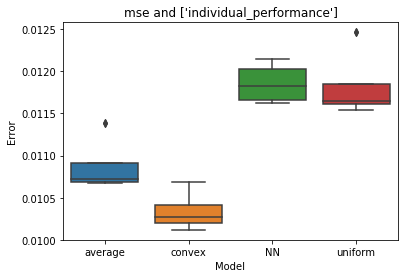

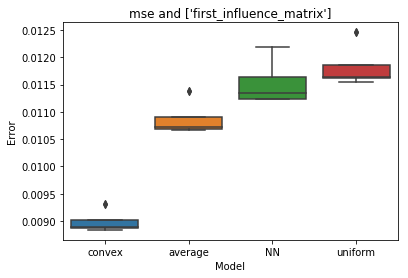

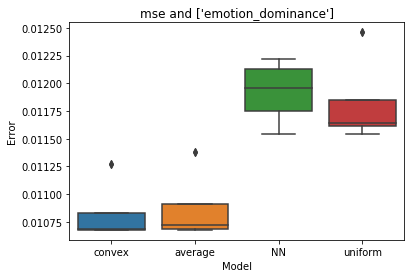

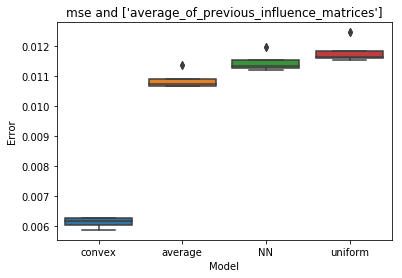

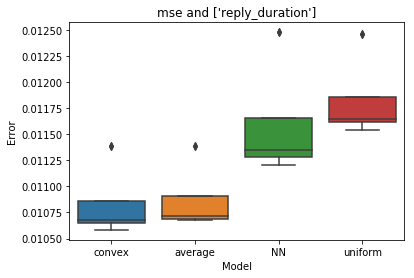

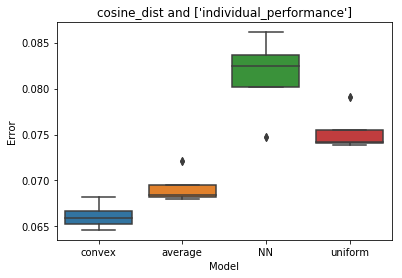

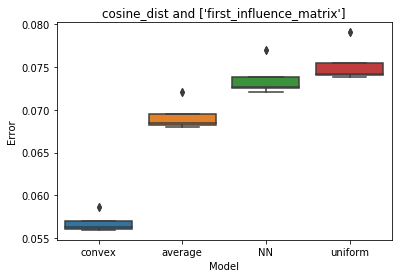

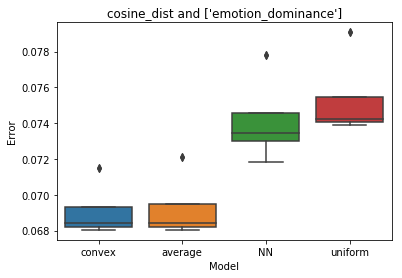

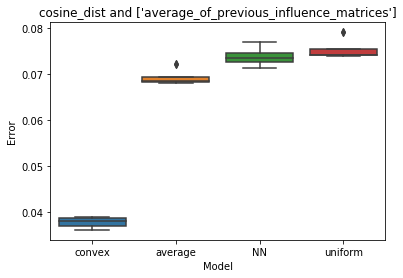

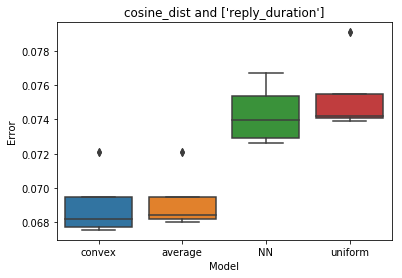

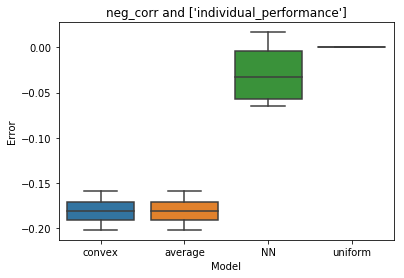

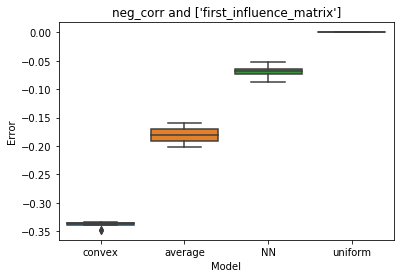

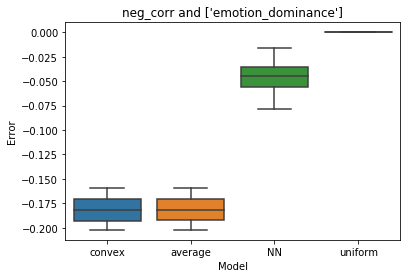

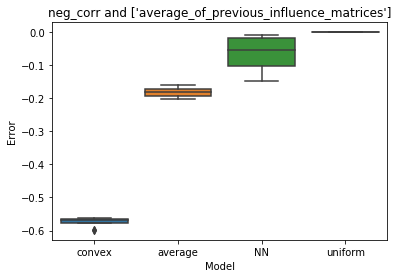

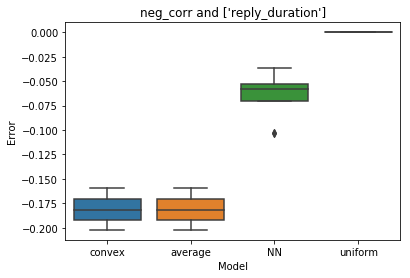

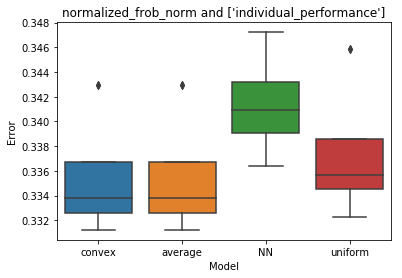

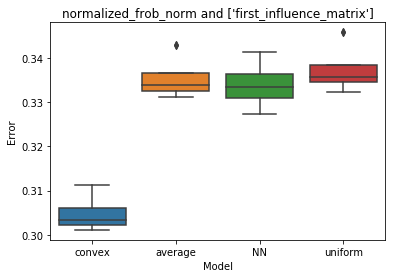

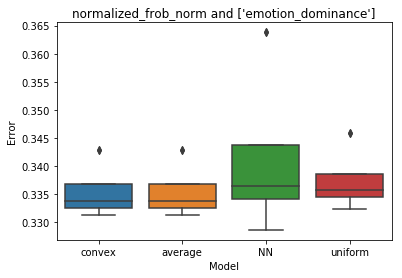

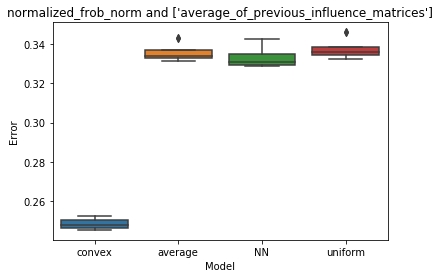

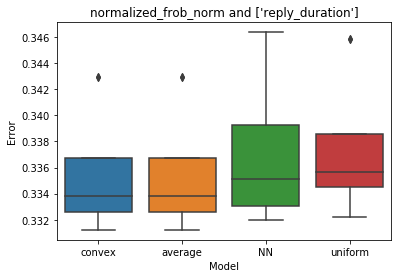

In [59]:
plot_all_results(train_errors_in_runs1, train_errors_in_runs2)

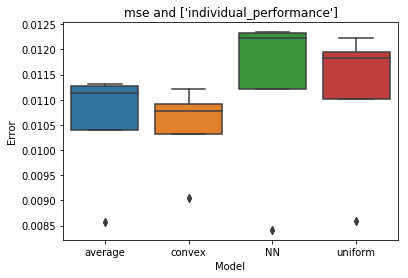

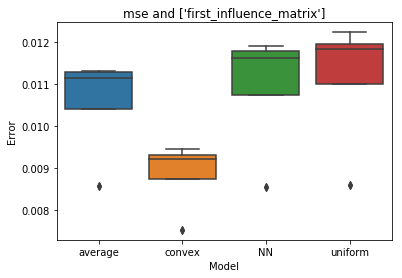

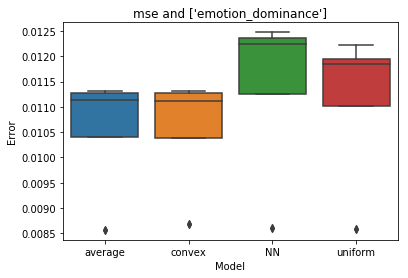

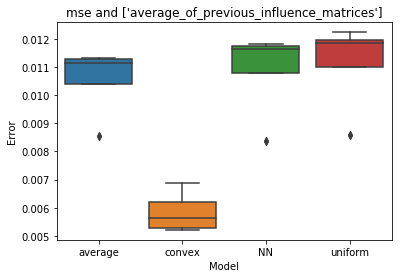

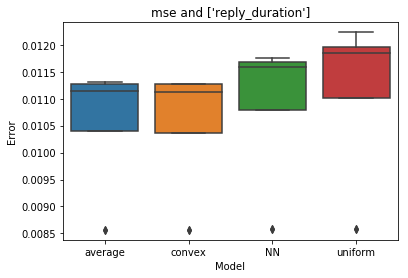

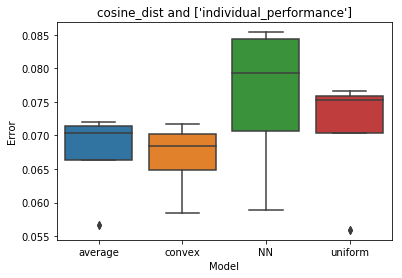

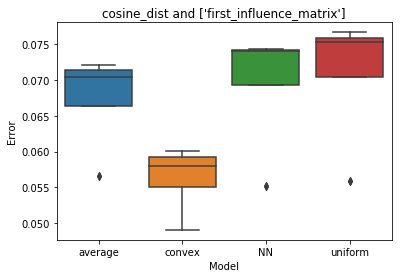

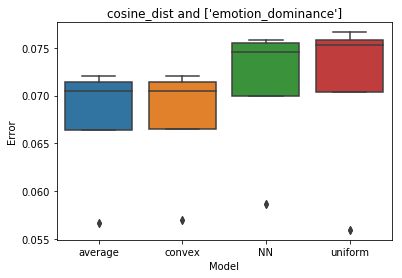

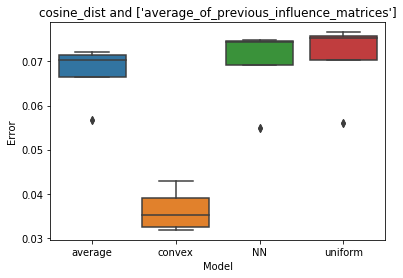

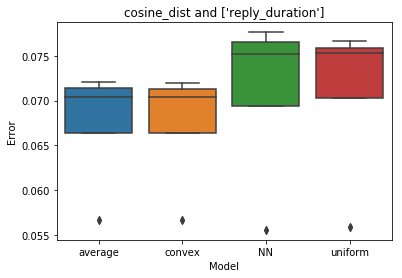

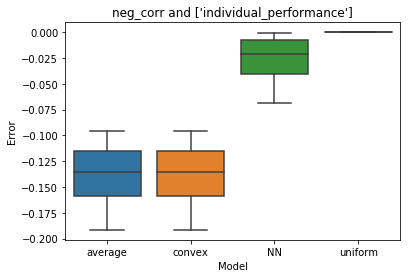

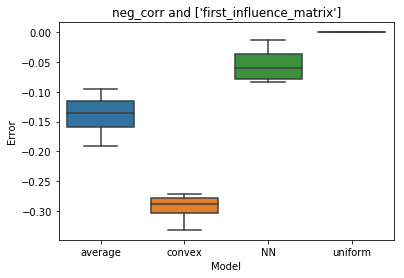

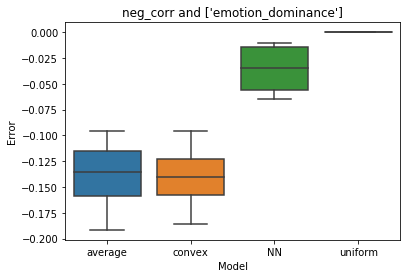

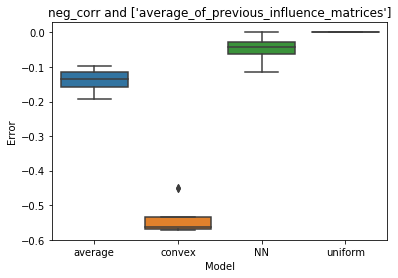

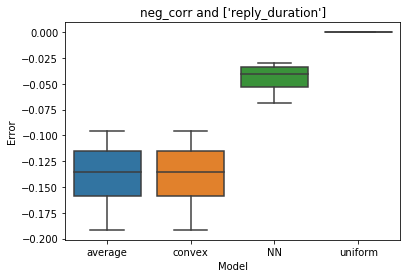

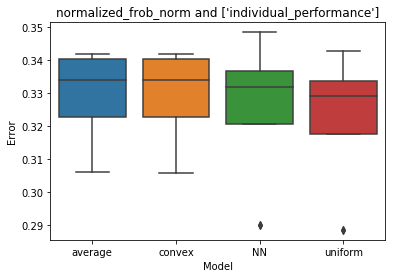

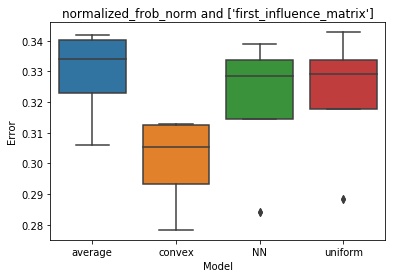

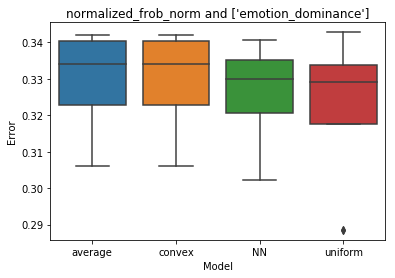

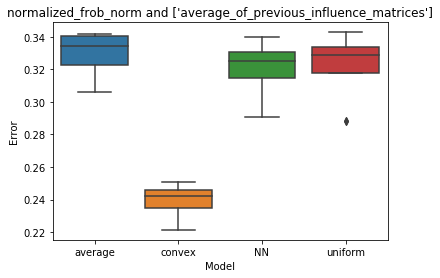

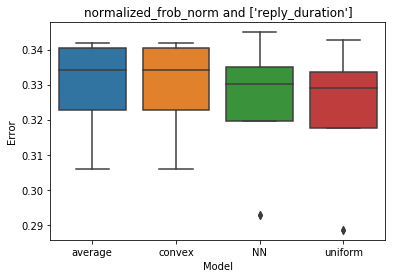

In [60]:
plot_all_results(test_errors_in_runs1, test_errors_in_runs2)

### Different feature sets

In [69]:
LAMBDAS = [0, 0.1, 1, 10, 100, 1000]
WITH_REPLICATION = True
ERROR_TYPE_STRS = ['mse']
TUNE_HYPERPARAMETERS_BY_VALIDATION = True
RUNS = 6
SELECTED_MODEL_FUNCS = ['average', 'uniform', 'random', convex_optimization_model_func, concatinated_deep_neural_network_model_func]
FEATURE_NAMES_SET = [['first_influence_matrix'], ['first_influence_matrix', 'individual_performance'], ['first_influence_matrix', 'individual_performance', 'reply_duration'], ['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance'], ['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance', 'average_of_previous_influence_matrices']]  # ['content_embedding_matrix'],
ESTIMATION_NAME = 'influence_matrix' #'most_influentials'

TO_WRITE_LOGS_ON_FILE = True

In [70]:
train_errors6 = utils.load_it('Outputs/train_errors6_multiple_features.pkl.dill')
test_errors6 = utils.load_it('Outputs/test_errors6_multiple_features.pkl.dill')

In [75]:
def plot_all_result_from_errors_in_runs(errors_in_runs):
    for error_type_str, features_dt in errors_in_runs.items():
        for feature_set, models_dt in features_dt.items():
            this_error_dt = []
            for model_str, errors in models_dt.items():
#                 if model_str == 'random':
#                     continue  # Ignores the random model.
                    
                if model_str == 'concatinated_deep_neural_network_model_func':
                    model_str = 'NN'
                elif model_str == 'convex_optimization_model_func':
                    model_str = 'convex'
                for err in errors:
                    this_error_dt.append([model_str, err])
            df = pd.DataFrame(this_error_dt, columns=['Model', 'Error'])
            sns.boxplot(x='Model', y='Error', data=df)
            plt.title('{} and {}'.format(error_type_str, feature_set))
            plt.show()
            print('\n')

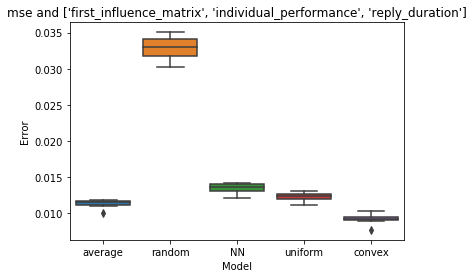

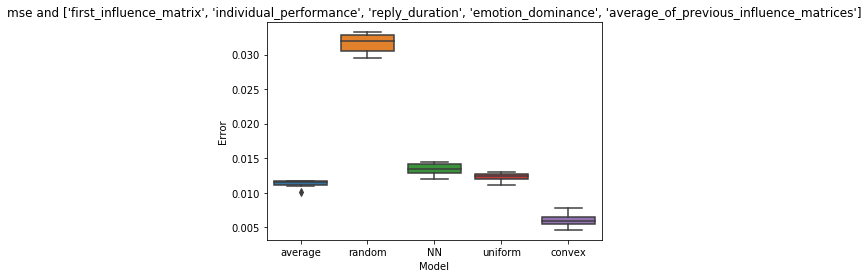

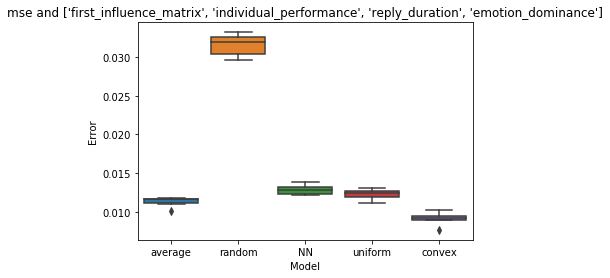

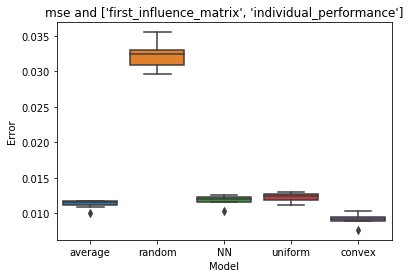

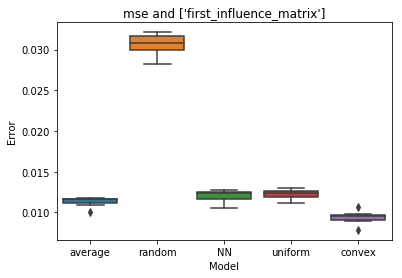

In [76]:
plot_all_result_from_errors_in_runs(test_errors6)

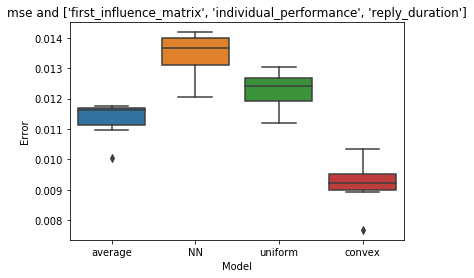

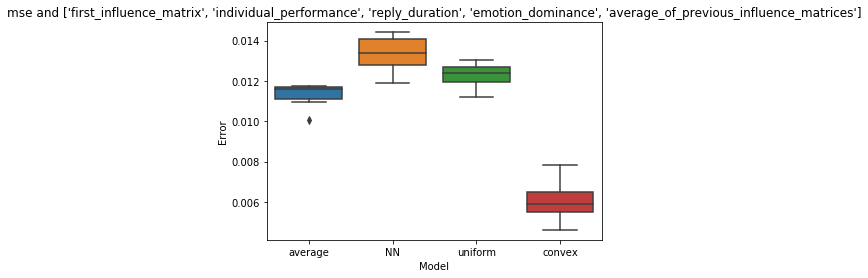

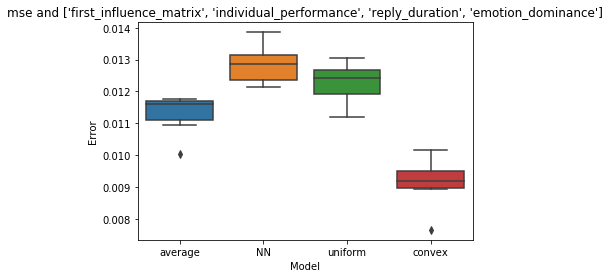

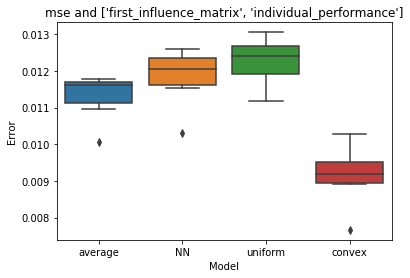

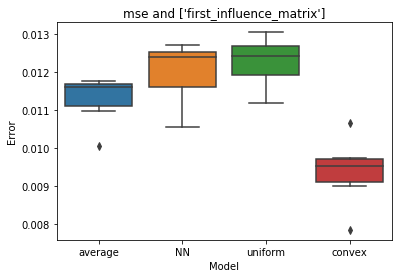

In [72]:
plot_all_result_from_errors_in_runs(test_errors6)

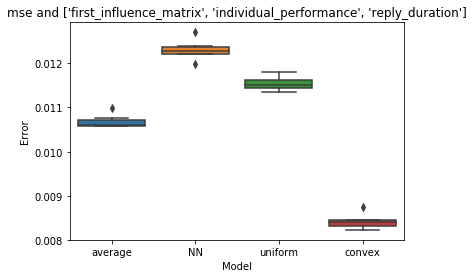

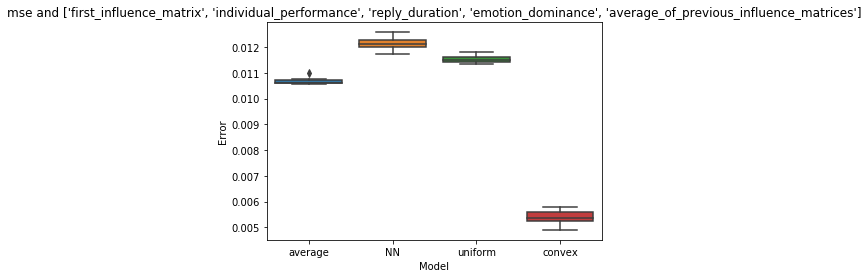

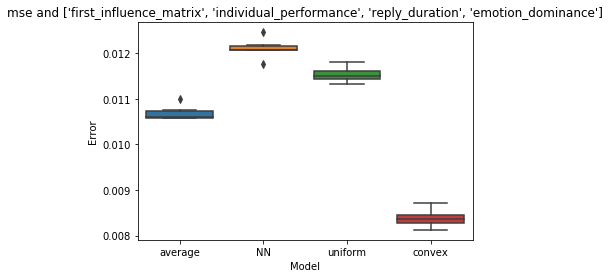

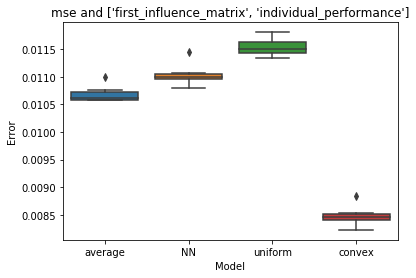

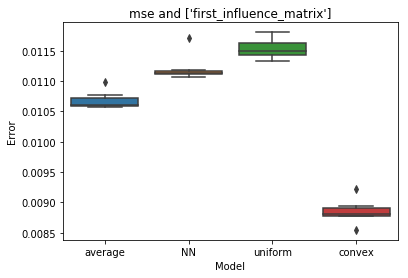

In [73]:
plot_all_result_from_errors_in_runs(train_errors6)

In [53]:
# X_train, X_test, y_train, y_test = train_test_split(
#     np.array(data['X']), np.array(data['y']), test_size=TEST_FRACTION)

In [54]:
# a, b, c = model_builder(
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     feature_names=['average_of_previous_influence_matrices'],
#     estimation_name=ESTIMATION_NAME,
#     error_type_str='normalized_frob_norm',
#     tune_hyperparameters_by_validation=True,
#     with_replication=False,
#     lambdas=LAMBDAS,
#     model_func=convex_optimization_model_func,
#     params={'with_constraints': False, 'n_splits': 3, 'n_epochs': 10, 'batch_size': 32})

In [55]:
# a

In [56]:
# b

In [57]:
# c